<a href="https://colab.research.google.com/github/bentson1187/dsc-phase-4-project/blob/main/Phase_4_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project Submission

* Student name: **Brian Bentson**
* Student pace: self paced / part time / full time: **Full Time**
* Scheduled project review date/time: 6/23/21 @ 2pm CST
* Instructor name: **James Irving**
* Blog post URL:
* Video of 5-min Non-Technical Presentation:

# Table of Contents

*Click to jump to matching Markdown Header*

- **[INTRODUCTION](#INTRODUCTION)**<br>
- **[DATA COLLECTION](#DATA-COLLECTION)**<br>
- **[DATA CLEANING](#DATA-CLEANING)**<br>
- **[DATA EXPLORATION](#DATA-EXPLORATION)**<br>
- **[DATA MODELING](#DATA-MODELING)**<br>
- **[DATA INTERPRETATION](#DATA-INTERPRETATION)**<br>
- **[RECOMMENDATIONS AND CONCLUSIONS](#RECOMMENDATIONS-AND-CONCLUSIONS)**

# INTRODUCTION

HIT Investments is looking to leverage advanced analytics to aid in their decision-making process of identifying high-value, low cost stocks to invest in for their clients. Their specialty is finding and investing in micro-cap stocks which have been undervalued by others but otherwise show strong financial metrics. 

Historically, HIT Investments has leveraged their expertise to determine a Value Ranking of these stocks which takes into account multiple financial performance metrics. This analysis will take the next step and investigate how the top value stocks are projected to grow into the future to help further aid in their decision to buy a stock. 

## Business Statement

HIT Investments is a hedge fund company which strives to maximize after-tax returns for their clients by actively identifying and capitalizing on proven inefficiencies in the stock market using quantitative analysis. 

A market is said to be "efficient" if the price of a stock reflects all available and relevant information. This theory holds true for larger companies that are thoroughly tracked by investment firms. However, HIT Investments believes the market has inefficiencies, specifically in the Micro-Cap segment, which can be exploited to outpeform the stock market and deliver maximum return on investment. Micro-Cap stocks encompass more than one-half of the nationally traded companies so there are many opportunities to examine these stocks for value and growth potential. 

This analysis will investigate stocks from the [FMP](https://financialmodelingprep.com/) API, rank the stocks based on HIT Investments' "value" metrics and then forecast future growth of the top value stocks. This will provide HIT Investments with a new "growth" metric to utilize alongside the "value" metric to further quantify which stocks may be inefficient and therefore provide value to an investor.



 

## Analysis Methodology

This analysis will examine stocks based on 5 key performance metrics that define its' "value":
- Price to Expense Ratio (`pe_ratio`)
- Enterprise Value to Operating Cashflow (`ev_to_operating_cashflow`)
- Enterprise Value Over Earnings Before Interest, Taxes, Depreciation, and Amortization (`enterprise_value_over_EBITDA`)
- Enterprise Value to Free Cashflow (`ev_to_free_cashflow`)
- Price to Sales Ratio (`price_to_sales_ratio`)

The stocks will then be ranked comparitively based on these value metrics. For the top "value" stocks, the historical performance on reveneue per share (`revenue_per_share`) will be analyzed and modeled to forecast future growth. This will produce a second ranking of stocks based soley on growth. Lastly, the "Value" and "Growth" rankings will be consolidated in order to 

To simplify the analysis, I will perform the value rankings first and will delete the `date` feature in order to remove duplicate values for the `symbol_id`. Once the top "value" stocks are identified, I will bring the `date` feature back in to model and forecast the `revenue_per_share`. 

# DATA COLLECTION

## Import Packages

In [ ]:
#install pmdarima
!pip install pmdarima

In [ ]:
#data wrangling and visualization packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import scipy.stats as stats

#feature engineering packages
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

#modeling packages
from pmdarima import auto_arima
from statsmodels.tsa import api as tsa
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
#modeling evaluation packages
from statsmodels.tools.eval_measures import rmse

In [ ]:
#notebook settings
pd.set_option("display.max_columns", 40)
pd.options.display.float_format = '{:,}'.format

from pylab import rcParams
rcParams['figure.figsize'] = 18,8

import warnings
warnings.filterwarnings('ignore')

## Global Functions

In [ ]:
def col_eval(df, num_col=None, cat_cols=None, y_col='status_group', label_count=25, thresh=0.025):
    '''
    This function evaluates a single numeric feature or a list of categorical 
    features for feature engineering. It takes in a dataframe, a feature(s)
    and provides detailed descriptive statistics and draws 4 informative graphs. 
    Keyword Arguments:
    - df: A dataframe
    - num_col: A single column of numeric data
    - cat_cols: A list of categorical columns
    - y_col: A dependent variable column. Default is 'status_group'
    - label_count: Number of labels to draw in bar graph
    - thresh: A threshold line drawn on the bar graph to indicate percentage
    '''
    if num_col != None:
        #print the column name
        print(f'Column Name: {num_col}')
        #print the number of unique values
        print(f'Number of unique values: {df[num_col].nunique()}')
        #print the number of duplicate values
        print(f'There are {df[num_col].duplicated().sum()} duplicates')
        #print the number of null values
        print(f'There are {df[num_col].isna().sum()} null values')
        #print the number of negative values
        print(f'There are {(df[num_col] < 0).sum()} negative values')
        print('\n')
        #print descriptive statistics
        print('Descriptive Metrics:','\n',
              df[num_col].describe())
        #plot boxplot, histogram         
        fig, ax = plt.subplots(ncols=2, figsize=(15,10))
        
        histogram = df[num_col].hist(ax=ax[0])
        ax[0].set_title(f'Distribution of {num_col}');
        
        boxplot = df.boxplot(column=num_col, ax=ax[1]);
        ax[1].set_title(f'Boxplot of {num_col}');

        plt.tight_layout()

        plt.show()
        print('\n')
        
        return
    
    else:
        
        for col in cat_cols:
            print('=============================================================')
            #print the column name
            print(f'Column Name: {col}')
            print('\n')
            #print the number of unique values
            print(f'Number of unique values: {df[col].nunique()}')
            print('\n')
            #print the number of duplicate values
            print(f'There are {df[col].duplicated().sum()} duplicates')
            print('\n')
            #print the number of null values
            print(f'There are {df[col].isna().sum()} null values')
            print('\n')
            #print the number of values equal to '0'
            print(f'There are {(df[col] == "0").sum()} zeros')
            print('\n')
            #print the value counts percentage
            print('Value Counts Percentage', '\n', 
                  df[col].value_counts(dropna=False).round(2))
            print('\n')

            #plot barplot, histogram         
            fig, ax = plt.subplots(figsize=(15,10))

            bar_graph = df[col].value_counts(normalize=True, 
                                             dropna=False)[:label_count].plot.bar(label=f'{col} Percentage')
            ax.axhline(y=thresh, color='red', linestyle='--', 
                        label=f'{thresh*100}% Threshold')
            ax.set_title(f'{col} Value Counts')
            ax.set_xlabel(f'{col} Labels')
            ax.set_ylabel('Percentage')
            ax.legend()

            plt.tight_layout()

            plt.show()
        return

In [ ]:
def timeseries_creation(df, symbol_id):
  '''
  This function takes in a dataframe and a symbol_id and create a dataframe
  which is then plotted to show the time series data
  '''
  #create dataframe
  df = df.loc[df['symbol_id'] == symbol_id]
  df.sort_index(inplace=True)
  display(df)

  #plot 
  df['revenue_per_share'].plot(legend=True);
  plt.title(f"{df['company_name'][0]}")
  plt.ylabel('Revenue Per Share')

  return df

In [ ]:
def seasonality_stationarity_check(series, decomp_model='add'):
    """
    This function takes in a time series and returns a seasonal decompose to check
    for seasonality and the result of the Augmented Dickey-Fuller Test to check 
    for stationarity
    """
    result = seasonal_decompose(series, model=decomp_model)
    result.plot();
    plt.show()
    
    print('Augmented Dickey-Fuller Test Results')
    #run the test
    result = adfuller(series.dropna(),autolag='AIC')
    
    #create labels for the results
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[0:4],index=labels)
    
    #print the results
    print(output.to_string())
    print('\n')
    if result[1] <= 0.05:
        print("The data is stationary")
        
    else:
        print("The data is not stationary")

In [ ]:
def create_eval_model(df, ts_col, test_size=5, start_p=0, start_q=0, d=None, 
                      seasonal=False, m=1, trace=False, train_whole=False,
                      plot_diagnostics=False, auto=True, order=None, 
                      seasonal_order=None):

  #train-test split
  train = df.iloc[:-test_size]
  test = df.iloc[-test_size:]
  
  if auto == True:
    #get the best model using auto-arima function on training
    auto_model_train = auto_arima(train[ts_col], start_p=start_p, start_q=start_q, 
                              d=d, seasonal=seasonal, m=m, trace=trace) 
       
    #fit model auto-arima model
    best_model_train = tsa.SARIMAX(train[ts_col], order=auto_model_train.order, 
                           seasonal_order=auto_model_train.seasonal_order).fit()
    
    best_model_ts = tsa.SARIMAX(df[ts_col], order=auto_model_train.order, 
                           seasonal_order=auto_model_train.seasonal_order).fit()

  else:
    #fit user specified model
    best_model_train = tsa.SARIMAX(train[ts_col], order=order, 
                            seasonal_order=seasonal_order).fit()

    best_model_ts = tsa.SARIMAX(df[ts_col], order=order, 
                            seasonal_order=seasonal_order).fit()

  #print model summary
  print(best_model_train.summary())
    
  #print model diagnostics  
  if plot_diagnostics == True:
    print(results.plot_diagnostics())
  else:
    pass

  #get model predictions for test set
  forecast = best_model_train.get_forecast(steps=len(test))
  #create dataframe for forecast plus confidence intervals
  forecast_df = forecast.conf_int()
  forecast_df.columns = ['Lower CI','Upper CI']
  forecast_df['Forecast'] = forecast.predicted_mean
  
  #plot test and forecast
  fig,ax = plt.subplots()
  train.plot(label='Train Data', ax=ax)                    
  test.plot(label='Test Data', ax=ax)
  forecast_df['Forecast'].plot(ax=ax,label='Forecast')
  ax.fill_between(forecast_df.index,
                forecast_df['Lower CI'], 
                forecast_df['Upper CI'],color='g',alpha=0.3)
  ax.set(ylabel=ts_col)
  plt.legend(['Train','Test','Forecast'])
  plt.title('Forecast vs Test')
  
  #eval model
  predictions = forecast_df['Forecast']
  error = rmse(test['revenue_per_share'],predictions)
  print('\n')
  print(f'The error of this model is {error.round(2)}')
  print(f'The mean of {ts_col} is {round(df[ts_col].mean(),2)}')

  return best_model_train, train, test, best_model_ts

In [ ]:
def forecast(df, ts_col, best_model_ts, forecast_len, forecast_table=False):

  best_model = best_model_ts

  #get model predictions for test set
  forecast = best_model.get_forecast(steps=forecast_len+1)
  #create dataframe for forecast plus confidence intervals
  forecast_df = forecast.conf_int()
  forecast_df.columns = ['Lower CI','Upper CI']
  forecast_df['Forecast'] = forecast.predicted_mean
  
  ts_end = pd.DataFrame(data=[[np.nan, np.nan, df.iloc[-1,1]]], 
                        columns=['Lower CI','Upper CI','Forecast'], 
                        index=[pd.to_datetime('2020-12-31')])
  
  forecast_df = forecast_df.append(ts_end).sort_index()
  
  #plot test and forecast
  fig,ax = plt.subplots()
  df[ts_col].plot(label='Original Timeseries', ax=ax)                    
  forecast_df['Forecast'].plot(ax=ax,label='Forecast', c='orange')
  ax.axvline(df.index[-1], ls=':', label='Timeseries-Forecast Split', alpha=0.5, 
             c='orange')
  ax.fill_between(forecast_df.index,
                forecast_df['Lower CI'], 
                forecast_df['Upper CI'],color='g',alpha=0.3)
  ax.set(ylabel=ts_col)
  plt.legend(['Original Timeseries','Forecast', 'Timeseries-Forecast Split'])
  plt.title(f'Forecast {forecast_len+1} year(s) Into the Future')
  plt.show()

  ts_endpoint = df.iloc[-1, 1]
  forecast_endpoint = forecast_df.iloc[-1,-1]
  percent_change = round((forecast_endpoint - ts_endpoint) / 
                         ts_endpoint * 100,2)

  print('\n')
  print(f'The percent change {forecast_len+1} year(s) into the future is {percent_change}%')
  
  if forecast_table == True:
    display(forecast_df)
  else:
    pass  
  
  return percent_change

## Import Data into Pandas

In [ ]:
#create initial dataframe
df_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Phase 4 Project/Data/stocks_info_HIT_phase 4 project.csv')

df_original

,symbol_id,date,peRatio,evToOperatingCashFlow,enterpriseValueOverEBITDA,evToFreeCashFlow,priceToSalesRatio,revenuePerShare,marketCap,companyName,industry,exchange,sector,country,symbol
0,1,2020-12-31,7.106,5.485,5.096,9.207,0.777,69.082,"207,080,118,706.24103",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
1,1,2019-12-31,6.768,6.902,5.325,14.498,0.9009999999999999,77.542,"269,551,218,662.48102",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
2,1,2018-12-31,7.8229999999999995,9.373,8.073,28.721999999999998,1.101,71.847,"305,105,833,018.26697",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
3,1,2017-12-31,11.550999999999998,10.831,11.057,19.558,1.631,64.421,"405,442,002,634.64294",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
4,1,2016-12-31,10.927,12.710999999999999,9.615,32.469,1.3880000000000001,67.32600000000001,"360,664,786,130.276",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200633,20816,2019-12-31,13.597999999999999,6.702999999999999,6.9239999999999995,9.162,1.0590000000000002,19.214000000000002,"754,125,840.0",Sleep Country Canada Holdings Inc,Specialty Retail,Toronto,Consumer Cyclical,CA,ZZZ.TO
200634,20816,2018-12-31,12.995,13.437000000000001,7.872999999999999,22.359,1.244,16.824,"775,016,970.0",Sleep Country Canada Holdings Inc,Specialty Retail,Toronto,Consumer Cyclical,CA,ZZZ.TO
200635,20816,2017-12-31,20.699,14.106,11.856,20.257,2.079,15.634,"1,222,733,610.0",Sleep Country Canada Holdings Inc,Specialty Retail,Toronto,Consumer Cyclical,CA,ZZZ.TO
200636,20816,2016-12-31,21.835,21.824,12.409,31.962,2.0669999999999997,13.915999999999999,"1,082,468,880.0",Sleep Country Canada Holdings Inc,Specialty Retail,Toronto,Consumer Cyclical,CA,ZZZ.TO


## Data Schema

Data was sourced from [FMP](https://financialmodelingprep.com/) and converted to a .csv file format. This data is not currently live. Formulas for the performance metrics can be found [HERE](https://financialmodelingprep.com/developer/docs/formula).



## Investigate Data

In [ ]:
#check dataframe
df_original

,symbol_id,date,peRatio,evToOperatingCashFlow,enterpriseValueOverEBITDA,evToFreeCashFlow,priceToSalesRatio,revenuePerShare,marketCap,companyName,industry,exchange,sector,country,symbol
0,1,2020-12-31,7.106,5.485,5.096,9.207,0.777,69.082,"207,080,118,706.24103",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
1,1,2019-12-31,6.768,6.902,5.325,14.498,0.9009999999999999,77.542,"269,551,218,662.48102",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
2,1,2018-12-31,7.8229999999999995,9.373,8.073,28.721999999999998,1.101,71.847,"305,105,833,018.26697",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
3,1,2017-12-31,11.550999999999998,10.831,11.057,19.558,1.631,64.421,"405,442,002,634.64294",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
4,1,2016-12-31,10.927,12.710999999999999,9.615,32.469,1.3880000000000001,67.32600000000001,"360,664,786,130.276",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200633,20816,2019-12-31,13.597999999999999,6.702999999999999,6.9239999999999995,9.162,1.0590000000000002,19.214000000000002,"754,125,840.0",Sleep Country Canada Holdings Inc,Specialty Retail,Toronto,Consumer Cyclical,CA,ZZZ.TO
200634,20816,2018-12-31,12.995,13.437000000000001,7.872999999999999,22.359,1.244,16.824,"775,016,970.0",Sleep Country Canada Holdings Inc,Specialty Retail,Toronto,Consumer Cyclical,CA,ZZZ.TO
200635,20816,2017-12-31,20.699,14.106,11.856,20.257,2.079,15.634,"1,222,733,610.0",Sleep Country Canada Holdings Inc,Specialty Retail,Toronto,Consumer Cyclical,CA,ZZZ.TO
200636,20816,2016-12-31,21.835,21.824,12.409,31.962,2.0669999999999997,13.915999999999999,"1,082,468,880.0",Sleep Country Canada Holdings Inc,Specialty Retail,Toronto,Consumer Cyclical,CA,ZZZ.TO


In [ ]:
#look at dataframe information
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200638 entries, 0 to 200637
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   symbol_id                  200638 non-null  int64  
 1   date                       200638 non-null  object 
 2   peRatio                    198212 non-null  float64
 3   evToOperatingCashFlow      197510 non-null  float64
 4   enterpriseValueOverEBITDA  181451 non-null  float64
 5   evToFreeCashFlow           199255 non-null  float64
 6   priceToSalesRatio          189757 non-null  float64
 7   revenuePerShare            199382 non-null  float64
 8   marketCap                  199372 non-null  float64
 9   companyName                200638 non-null  object 
 10  industry                   195297 non-null  object 
 11  exchange                   200638 non-null  object 
 12  sector                     195161 non-null  object 
 13  country                    20

> **OBSERVATOINS**
> - There are null values that need to be further investigated
> - Need to standardize feature names
> - `symbol_id` should be changed to an object
> - `date` should be changed to datetime object
> - `date` creates duplicates for `symbol_id` for each reporting year. I will grab only the stocks which have entries for '2020-12-31' to minimize the number of stocks and get the most recent performance metrics
> - Some stocks have only a few years of data, need to focus on stocks with at least 10 years of history for forecasting

> **ACTIONS**
> - Investigate removal of null values
> - Rename features
> - Change `symbol_id` to object
> - Change `date` to datetime object
> - Filter dataframe to eliminate dates outside '2020-12-31'
> - Filter dataframe to stocks with at least 10 years of data

In [ ]:
#investigate numeric data
df_original.describe()

,symbol_id,peRatio,evToOperatingCashFlow,enterpriseValueOverEBITDA,evToFreeCashFlow,priceToSalesRatio,revenuePerShare,marketCap
count,"200,638.0","198,212.0","197,510.0","181,451.0","199,255.0","189,757.0","199,382.0","199,372.0"
mean,"10,122.107357529481","2,516,460,421.687086","-1,212,146.3352497807","-12,997,569,116.885164","-356,779.1848743116","65,334,578.23667662","22,525.607289825526","139,234,593,610,383.25"
std,"5,968.909309853393","647,354,986,094.3778","1,111,994,450.218779","5,537,944,021,908.352","1,111,136,752.681556","10,670,258,485.679958","4,512,844.311049463",2.028102196451377e+16
min,1.0,"-829,722,865,953.1641","-348,413,920,917.389","-2,359,000,000,000,010.0","-347,372,013,259.143","-34,544,818.345","-52,901,000.0",-7.018927382394985e+16
25%,"5,090.0",-1.44825,-0.615,1.261,-9.95,0.614,1.1079999999999999,"147,915,632.5"
50%,"10,130.0",11.217,8.731,7.476,6.5729999999999995,1.733,6.928999999999999,"905,820,488.245625"
75%,"15,138.0",24.100250000000003,20.302,15.435,24.753,5.6979999999999995,29.326,"6,242,128,097.125"
max,"20,816.0","264,162,027,080,000.0","206,356,880,725.375","1,760,018,200,512.99","206,356,880,725.375","2,915,356,923,409.09","1,878,257,872.671",5.808060061672145e+18


> **OBSERVATIONS**
> - There are are negative values for each performance metric
> - Range of the data is large

> **ACTIONS**
> - Evaluate the negative values
> - Plot the distributions of the data

# DATA CLEANING

In this section, I will focus on understanding the raw data quality and cleaning the data in preparation for data exploration, visualization and modeling. Specifically, I will refine the list of stocks to rank based on the value metrics. I will then take the top X amount of these stocks to model their growth based on `revenue_per_share` to further refine the best stocks based on both value and future growth.

HIT Investments believe that companies in the Financial, BioTech and Project Management/Construction sectors may be hard to evaluate based on various factors. I will remove these industries from this analysis to be consistent with my stakeholders domain experience. 

In [ ]:
#create df_clean dataframe
df_clean = df_original.copy()

In [ ]:
#view the dataframe
df_clean.head()

,symbol_id,date,peRatio,evToOperatingCashFlow,enterpriseValueOverEBITDA,evToFreeCashFlow,priceToSalesRatio,revenuePerShare,marketCap,companyName,industry,exchange,sector,country,symbol
0,1,2020-12-31,7.106,5.485,5.096,9.207,0.777,69.082,"207,080,118,706.24103",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
1,1,2019-12-31,6.768,6.902,5.325,14.498,0.9009999999999999,77.542,"269,551,218,662.48102",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
2,1,2018-12-31,7.8229999999999995,9.373,8.073,28.721999999999998,1.101,71.847,"305,105,833,018.26697",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
3,1,2017-12-31,11.550999999999998,10.831,11.057,19.558,1.631,64.421,"405,442,002,634.64294",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
4,1,2016-12-31,10.927,12.710999999999999,9.615,32.469,1.3880000000000001,67.32600000000001,"360,664,786,130.276",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK


In [ ]:
#change symbol_id to a string
df_clean['symbol_id'] = df_clean['symbol_id'].astype('str')

In [ ]:
#change date to datetime object
df_clean['date'] = pd.to_datetime(df_clean['date'])

In [ ]:
#standardize feature names
df_clean.rename(columns={'peRatio':'pe_ratio',
                         'evToOperatingCashFlow':'ev_to_operating_cashflow',
                         'enterpriseValueOverEBITDA':'enterprise_value_over_EBITDA',
                         'evToFreeCashFlow':'ev_to_free_cashflow',
                         'priceToSalesRatio':'price_to_sales_ratio',
                         'revenuePerShare':'revenue_per_share',
                         'companyName':'company_name', 'marketCap':'market_cap'}
                ,inplace=True)

In [ ]:
#filter based on stocks with a reporting date in 2020
stocks_2020 = df_clean.loc[df_clean['date'] == '2020-12-31', 'symbol_id'].tolist()

df_clean = df_clean.loc[df_clean['symbol_id'].isin(stocks_2020)]

In [ ]:
#filter based on stocks with at least 10 years of history
df_10_year = pd.DataFrame(df_clean.groupby('symbol_id').count()['date'])
stocks_10_year = df_10_year.loc[df_10_year['date'] >= 10].index.tolist()

df_clean = df_clean.loc[df_clean['symbol_id'].isin(stocks_10_year)]

In [ ]:
df_clean

,symbol_id,date,pe_ratio,ev_to_operating_cashflow,enterprise_value_over_EBITDA,ev_to_free_cashflow,price_to_sales_ratio,revenue_per_share,market_cap,company_name,industry,exchange,sector,country,symbol
0,1,2020-12-31,7.106,5.485,5.096,9.207,0.777,69.082,"207,080,118,706.24103",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
1,1,2019-12-31,6.768,6.902,5.325,14.498,0.9009999999999999,77.542,"269,551,218,662.48102",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
2,1,2018-12-31,7.8229999999999995,9.373,8.073,28.721999999999998,1.101,71.847,"305,105,833,018.26697",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
3,1,2017-12-31,11.550999999999998,10.831,11.057,19.558,1.631,64.421,"405,442,002,634.64294",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
4,1,2016-12-31,10.927,12.710999999999999,9.615,32.469,1.3880000000000001,67.32600000000001,"360,664,786,130.276",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200627,20815,2011-12-31,0.48200000000000004,-1.5859999999999999,-10.066,-1.6130000000000002,0.001,900.475,"42,800.0","ZZLL Information Technology, Inc.",Internet Content & Information,Other OTC,Communication Services,HK,ZZLL
200628,20815,2010-12-31,240.972,14.255,46.641999999999996,14.652000000000001,0.203,714.9630000000001,"6,206,000.0","ZZLL Information Technology, Inc.",Internet Content & Information,Other OTC,Communication Services,HK,ZZLL
200629,20815,2009-12-31,82.962,24.944000000000003,726.602,25.68,0.018000000000000002,567.938,"428,000.0","ZZLL Information Technology, Inc.",Internet Content & Information,Other OTC,Communication Services,HK,ZZLL
200630,20815,2008-12-31,-30.0,-56.894,-33.188,-36.205,0.16699999999999998,628.0,"4,200,000.0","ZZLL Information Technology, Inc.",Internet Content & Information,Other OTC,Communication Services,HK,ZZLL


In [ ]:
#remove sectors
df_clean = df_clean.loc[df_clean['sector'] != 'Financial Services']
df_clean = df_clean.loc[df_clean['sector'] != 'Biotechnology']
df_clean = df_clean.loc[df_clean['sector'] != 'Construction']
df_clean = df_clean.loc[df_clean['sector'] != 'Professional Services']
df_clean = df_clean.loc[df_clean['sector'] != 'Banking']

In [ ]:
#remove industries
df_clean = df_clean.loc[df_clean['industry'] != 'Residential Construction']
df_clean = df_clean.loc[df_clean['industry'] != 'Diversified Financials']
df_clean = df_clean.loc[df_clean['industry'] != 'Biotechnology']
df_clean = df_clean.loc[df_clean['industry'] != 'Pharmaceuticals, Biotechnology & Life Sciences']
df_clean = df_clean.loc[df_clean['industry'] != 'Commercial and Professional Services']
df_clean = df_clean.loc[df_clean['industry'] != 'Capital Goods']

In [ ]:
#check the dataframe
df_clean

,symbol_id,date,pe_ratio,ev_to_operating_cashflow,enterprise_value_over_EBITDA,ev_to_free_cashflow,price_to_sales_ratio,revenue_per_share,market_cap,company_name,industry,exchange,sector,country,symbol
0,1,2020-12-31,7.106,5.485,5.096,9.207,0.777,69.082,"207,080,118,706.24103",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
1,1,2019-12-31,6.768,6.902,5.325,14.498,0.9009999999999999,77.542,"269,551,218,662.48102",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
2,1,2018-12-31,7.8229999999999995,9.373,8.073,28.721999999999998,1.101,71.847,"305,105,833,018.26697",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
3,1,2017-12-31,11.550999999999998,10.831,11.057,19.558,1.631,64.421,"405,442,002,634.64294",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
4,1,2016-12-31,10.927,12.710999999999999,9.615,32.469,1.3880000000000001,67.32600000000001,"360,664,786,130.276",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200627,20815,2011-12-31,0.48200000000000004,-1.5859999999999999,-10.066,-1.6130000000000002,0.001,900.475,"42,800.0","ZZLL Information Technology, Inc.",Internet Content & Information,Other OTC,Communication Services,HK,ZZLL
200628,20815,2010-12-31,240.972,14.255,46.641999999999996,14.652000000000001,0.203,714.9630000000001,"6,206,000.0","ZZLL Information Technology, Inc.",Internet Content & Information,Other OTC,Communication Services,HK,ZZLL
200629,20815,2009-12-31,82.962,24.944000000000003,726.602,25.68,0.018000000000000002,567.938,"428,000.0","ZZLL Information Technology, Inc.",Internet Content & Information,Other OTC,Communication Services,HK,ZZLL
200630,20815,2008-12-31,-30.0,-56.894,-33.188,-36.205,0.16699999999999998,628.0,"4,200,000.0","ZZLL Information Technology, Inc.",Internet Content & Information,Other OTC,Communication Services,HK,ZZLL


## Duplicates

In [ ]:
#check for duplicates
df_clean.duplicated().sum()

0

## Nulls

In [ ]:
#check for null values
round(df_clean.isna().sum()/len(df_clean),2)*100

symbol_id                      0.0
date                           0.0
pe_ratio                       1.0
ev_to_operating_cashflow       2.0
enterprise_value_over_EBITDA   3.0
ev_to_free_cashflow            1.0
price_to_sales_ratio           4.0
revenue_per_share              1.0
market_cap                     1.0
company_name                   0.0
industry                       2.0
exchange                       0.0
sector                         2.0
country                        0.0
symbol                         0.0
dtype: float64

> **OBSERVATIONS**
> - Nulls should be dropped for performance metrics `pe_ratio`, `ev_to_operating_cashflow`, `enterprise_value_over_EBITDA`, `ev_to_free_cashflow`, `price_to_sales_ratio` and `revenue_per_share` as these stocks will not be able to be ranked for value if they are missing these KPI's

> **ACTIONS**
> - I will remove any nulls in the performance metrics and impute values in the others: `industry` and `sector`

In [ ]:
#filter dataframe by removing a symbol which has a null in any of the performance metrics
#create lists of symbol_ids
pe_ratio_nulls = df_clean.loc[df_clean['pe_ratio'].isna() == True,'symbol_id'].tolist()
ev_to_operating_cashflow_nulls = df_clean.loc[df_clean['ev_to_operating_cashflow'].isna() == True,'symbol_id'].tolist()
enterprise_value_over_EBITDA_nulls = df_clean.loc[df_clean['enterprise_value_over_EBITDA'].isna() == True,'symbol_id'].tolist()
ev_to_free_cashflow_nulls = df_clean.loc[df_clean['ev_to_free_cashflow'].isna() == True,'symbol_id'].tolist()
price_to_sales_ratio_nulls = df_clean.loc[df_clean['price_to_sales_ratio'].isna() == True,'symbol_id'].tolist()
market_cap_nulls = df_clean.loc[df_clean['market_cap'].isna() == True,'symbol_id'].tolist()
#combine symbol_ids to a single list
nulls_symbol_id_list = pe_ratio_nulls + ev_to_operating_cashflow_nulls + \
enterprise_value_over_EBITDA_nulls + ev_to_free_cashflow_nulls + \
price_to_sales_ratio_nulls + market_cap_nulls
#create a set to remove duplicate symbol_ids
nulls_symbol_id_list = set(nulls_symbol_id_list)
#filter dataframe where the symbol_ids are not in the null symbol_ids list
df_clean = df_clean.loc[~df_clean['symbol_id'].isin(nulls_symbol_id_list)]
df_clean

,symbol_id,date,pe_ratio,ev_to_operating_cashflow,enterprise_value_over_EBITDA,ev_to_free_cashflow,price_to_sales_ratio,revenue_per_share,market_cap,company_name,industry,exchange,sector,country,symbol
0,1,2020-12-31,7.106,5.485,5.096,9.207,0.777,69.082,"207,080,118,706.24103",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
1,1,2019-12-31,6.768,6.902,5.325,14.498,0.9009999999999999,77.542,"269,551,218,662.48102",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
2,1,2018-12-31,7.8229999999999995,9.373,8.073,28.721999999999998,1.101,71.847,"305,105,833,018.26697",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
3,1,2017-12-31,11.550999999999998,10.831,11.057,19.558,1.631,64.421,"405,442,002,634.64294",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
4,1,2016-12-31,10.927,12.710999999999999,9.615,32.469,1.3880000000000001,67.32600000000001,"360,664,786,130.276",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200553,20807,2015-12-31,-7.102,-0.192,-0.594,-0.27699999999999997,0.083,47.375,"202,886,250.0",China Zenix Auto International Limited,Auto Parts,Other OTC,Consumer Cyclical,CN,ZXAIY
200554,20807,2014-12-31,4.652,3.1460000000000004,1.473,5.957999999999999,0.111,64.58800000000001,"368,576,687.5",China Zenix Auto International Limited,Auto Parts,Other OTC,Consumer Cyclical,CN,ZXAIY
200555,20807,2013-12-31,4.1419999999999995,2.737,1.896,3.5180000000000002,0.253,73.657,"963,646,012.6575",China Zenix Auto International Limited,Auto Parts,Other OTC,Consumer Cyclical,CN,ZXAIY
200556,20807,2012-12-31,3.64,1.068,1.6480000000000001,1.9380000000000002,0.35200000000000004,72.355,"1,316,314,641.863",China Zenix Auto International Limited,Auto Parts,Other OTC,Consumer Cyclical,CN,ZXAIY


In [ ]:
#check nulls
df_clean.isna().sum()

symbol_id                         0
date                              0
pe_ratio                          0
ev_to_operating_cashflow          0
enterprise_value_over_EBITDA      0
ev_to_free_cashflow               0
price_to_sales_ratio              0
revenue_per_share                 0
market_cap                        0
company_name                      0
industry                         60
exchange                          0
sector                          159
country                           0
symbol                            0
dtype: int64

> **OBSERVATIONS**
> - `industry` and `sector` have nulls

> **ACTIONS**
> - Will impute these with "Unknown"

In [ ]:
#impute industry and sector features
df_clean.loc[df_clean['industry'].isna(),'industry'] = "Unknown"
df_clean.loc[df_clean['sector'].isna(),'sector'] = "Unknown"

In [ ]:
#check nulls
df_clean.isna().sum()

symbol_id                       0
date                            0
pe_ratio                        0
ev_to_operating_cashflow        0
enterprise_value_over_EBITDA    0
ev_to_free_cashflow             0
price_to_sales_ratio            0
revenue_per_share               0
market_cap                      0
company_name                    0
industry                        0
exchange                        0
sector                          0
country                         0
symbol                          0
dtype: int64

## Feature Evaluation

In [ ]:
#feature names
df_clean.columns

Index(['symbol_id', 'date', 'pe_ratio', 'ev_to_operating_cashflow',
       'enterprise_value_over_EBITDA', 'ev_to_free_cashflow',
       'price_to_sales_ratio', 'revenue_per_share', 'market_cap',
       'company_name', 'industry', 'exchange', 'sector', 'country', 'symbol'],
      dtype='object')

In [ ]:
#create numeric features variable
num_cols = df_clean.select_dtypes(exclude='object').columns.tolist()
num_cols.remove('date')
num_cols

['pe_ratio',
 'ev_to_operating_cashflow',
 'enterprise_value_over_EBITDA',
 'ev_to_free_cashflow',
 'price_to_sales_ratio',
 'revenue_per_share',
 'market_cap']

Column Name: pe_ratio
Number of unique values: 35424
There are 11749 duplicates
There are 0 null values
There are 10283 negative values


Descriptive Metrics: 
 count                47,173.0
mean       88,242.86542623902
std      107,656,976.27369174
min       -14,625,362,334.212
25%                     3.218
50%                    13.922
75%        25.686999999999998
max     18,237,274,112.018997
Name: pe_ratio, dtype: float64


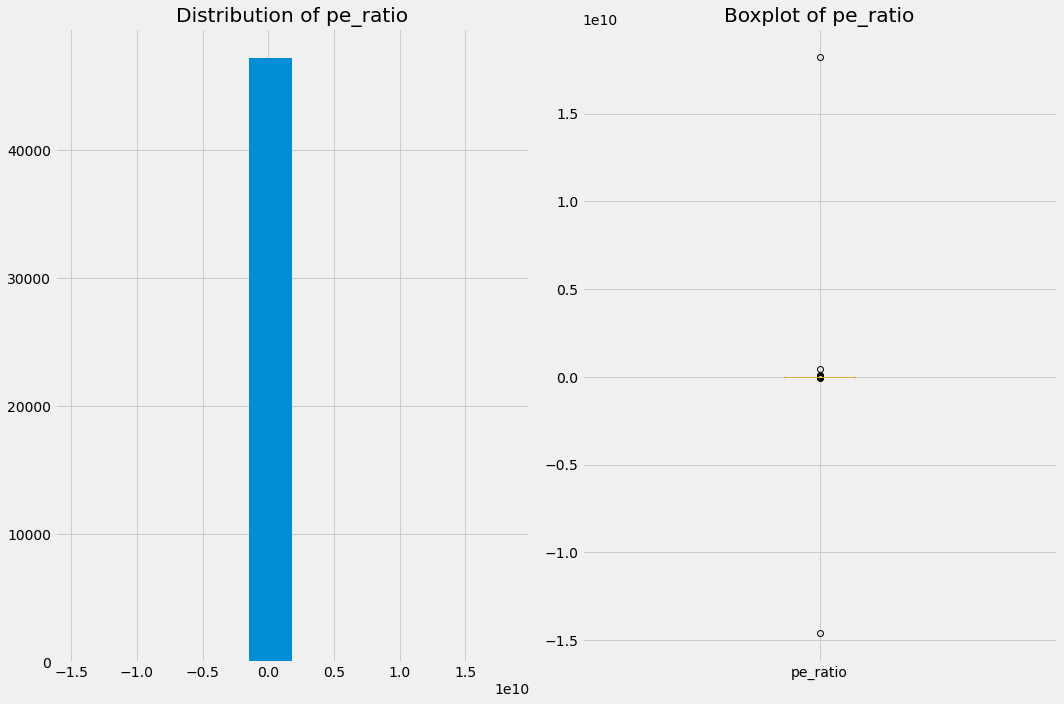



Column Name: ev_to_operating_cashflow
Number of unique values: 31417
There are 15756 duplicates
There are 0 null values
There are 6116 negative values


Descriptive Metrics: 
 count                47,173.0
mean    -1,819,784.6965878434
std       315,568,945.5884349
min       -65,289,224,937.391
25%                     5.331
50%        11.149000000000001
75%                    20.671
max            76,768,461.098
Name: ev_to_operating_cashflow, dtype: float64


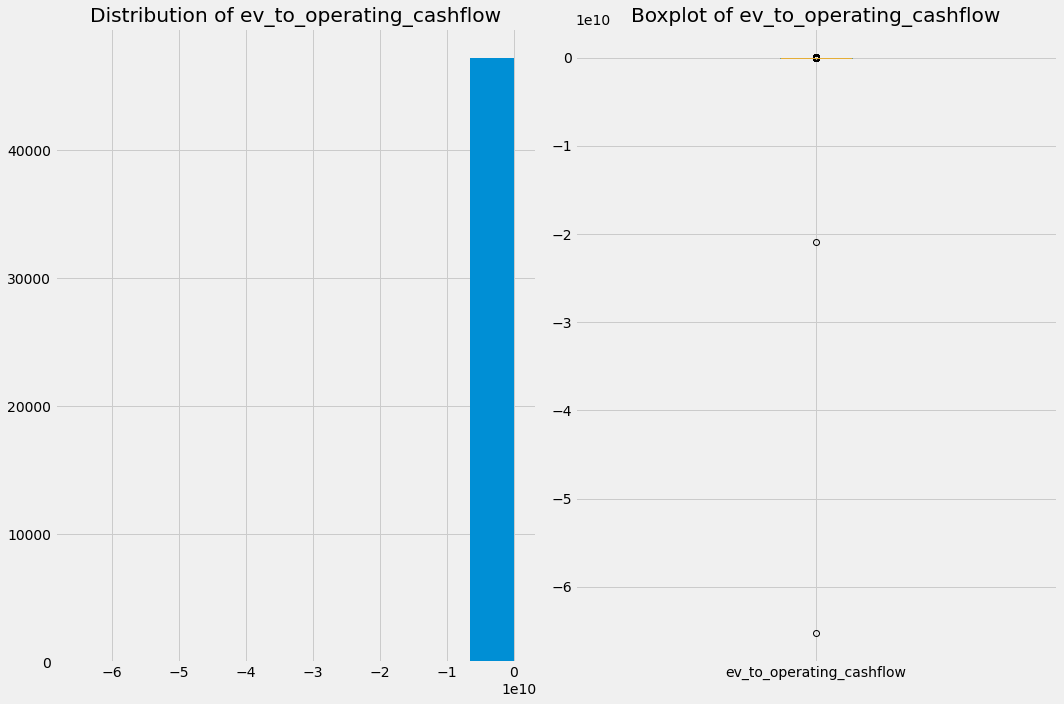



Column Name: enterprise_value_over_EBITDA
Number of unique values: 27969
There are 19204 duplicates
There are 0 null values
There are 5674 negative values


Descriptive Metrics: 
 count               47,173.0
mean    2,657,775.0617892547
std      657,196,531.6825166
min      -16,652,682,010.439
25%                     4.77
50%                    8.791
75%       15.357000000000001
max       141,763,679,909.14
Name: enterprise_value_over_EBITDA, dtype: float64


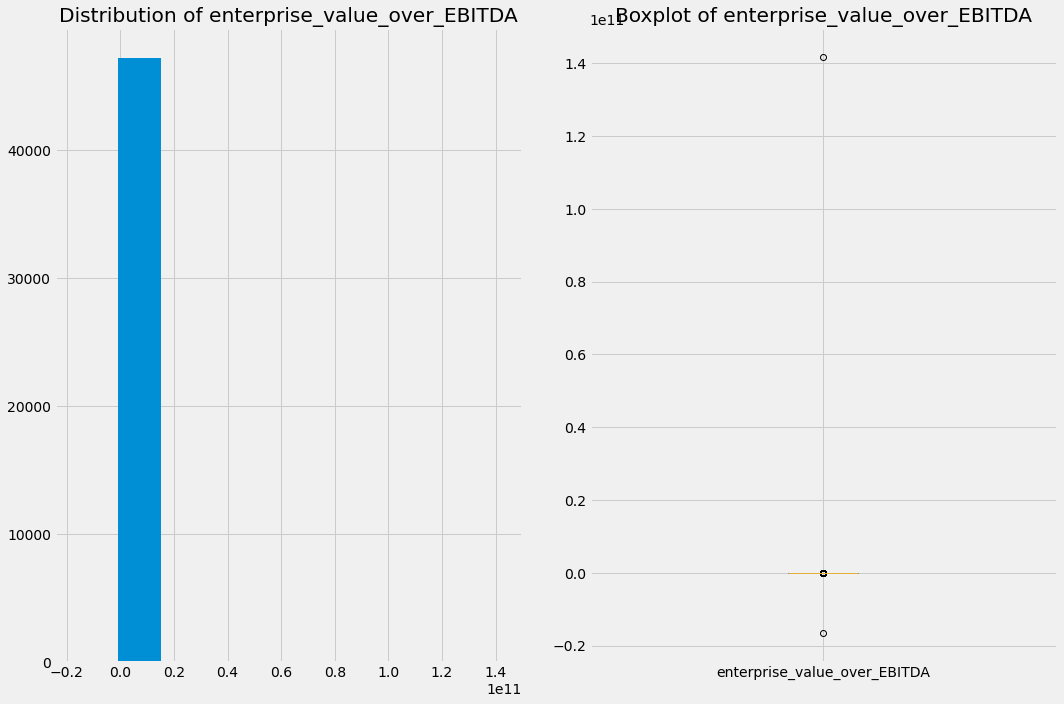



Column Name: ev_to_free_cashflow
Number of unique values: 38965
There are 8208 duplicates
There are 0 null values
There are 15380 negative values


Descriptive Metrics: 
 count               47,173.0
mean    -1,669,181.116258231
std     288,388,448.79745424
min      -59,597,041,608.012
25%                   -7.145
50%                    12.55
75%                   29.309
max           76,455,157.824
Name: ev_to_free_cashflow, dtype: float64


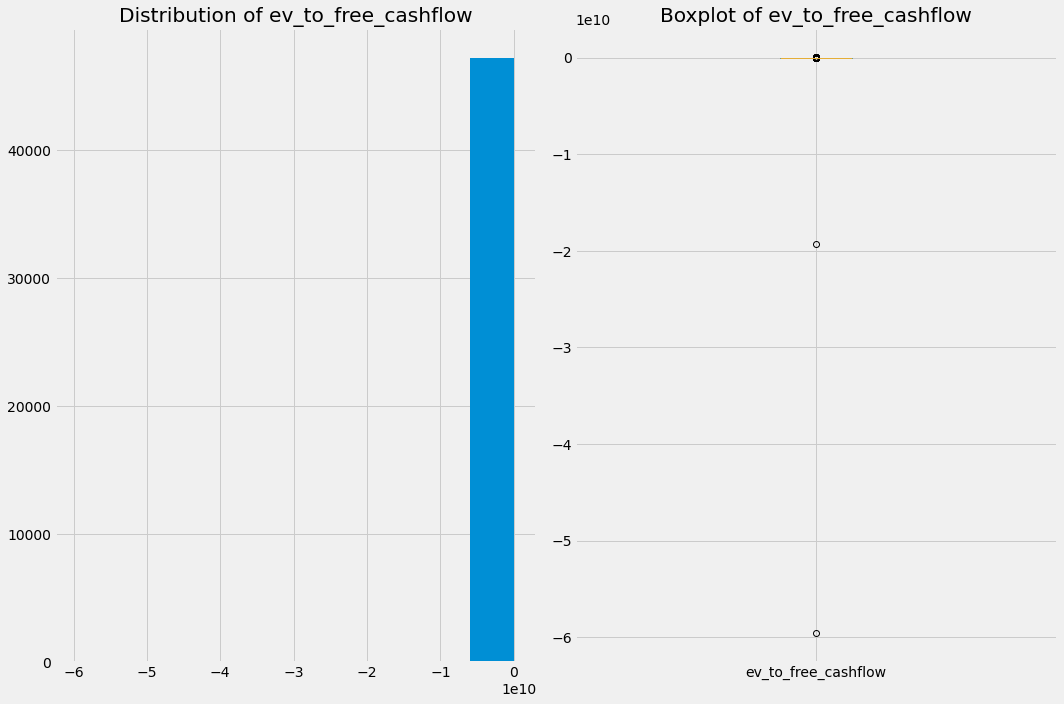



Column Name: price_to_sales_ratio
Number of unique values: 12814
There are 34359 duplicates
There are 0 null values
There are 41 negative values


Descriptive Metrics: 
 count                47,173.0
mean      409,686.60470474284
std       61,574,456.46524066
min                -3,445.136
25%                     0.605
50%                     1.446
75%                     3.804
max     10,027,869,719.786999
Name: price_to_sales_ratio, dtype: float64


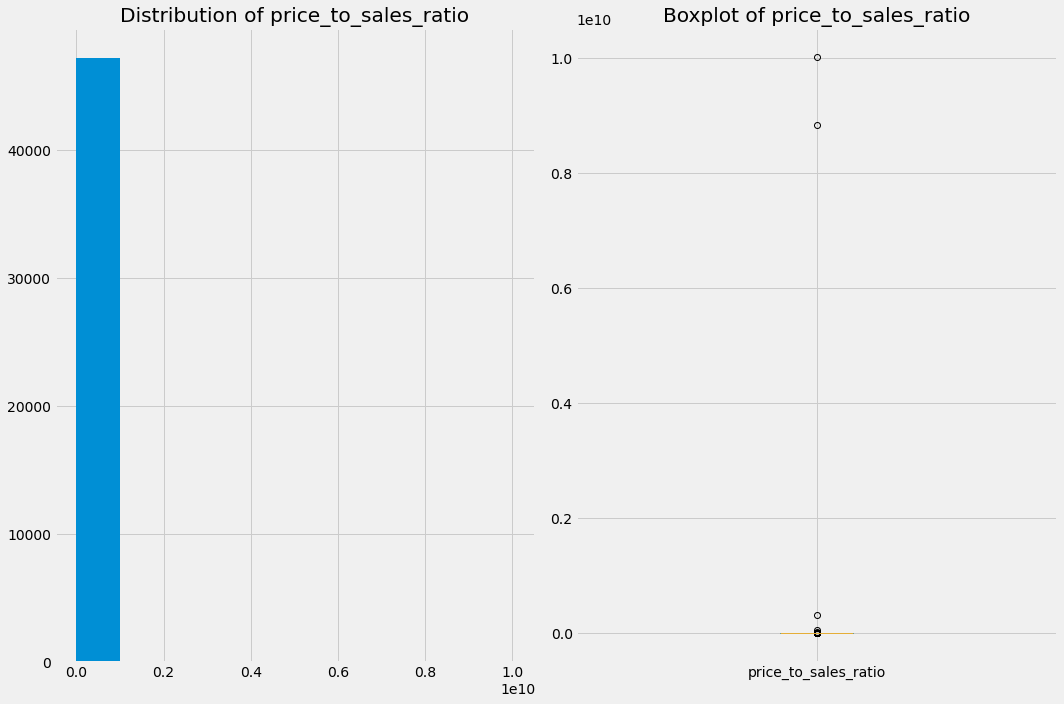



Column Name: revenue_per_share
Number of unique values: 27665
There are 19508 duplicates
There are 0 null values
There are 36 negative values


Descriptive Metrics: 
 count              47,173.0
mean      491.9352726135728
std      32,155.66552630915
min                  -3.717
25%      3.2060000000000004
50%      11.229000000000001
75%                  30.763
max     6,011,429.978999999
Name: revenue_per_share, dtype: float64


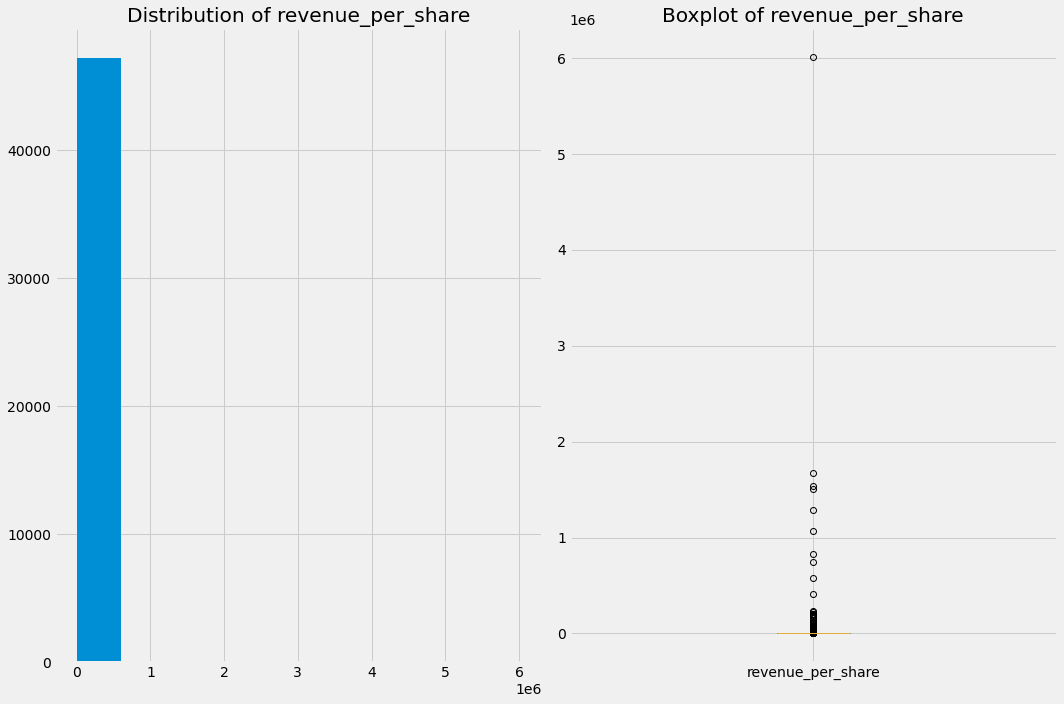



Column Name: market_cap
Number of unique values: 46975
There are 198 duplicates
There are 0 null values
There are 14 negative values


Descriptive Metrics: 
 count                  47,173.0
mean       9,742,905,661,503.35
std     1,610,643,407,761,348.0
min       -9,445,639,594,476.58
25%               279,567,250.0
50%             1,483,178,090.0
75%             8,886,588,480.0
max           3.30167610524e+17
Name: market_cap, dtype: float64


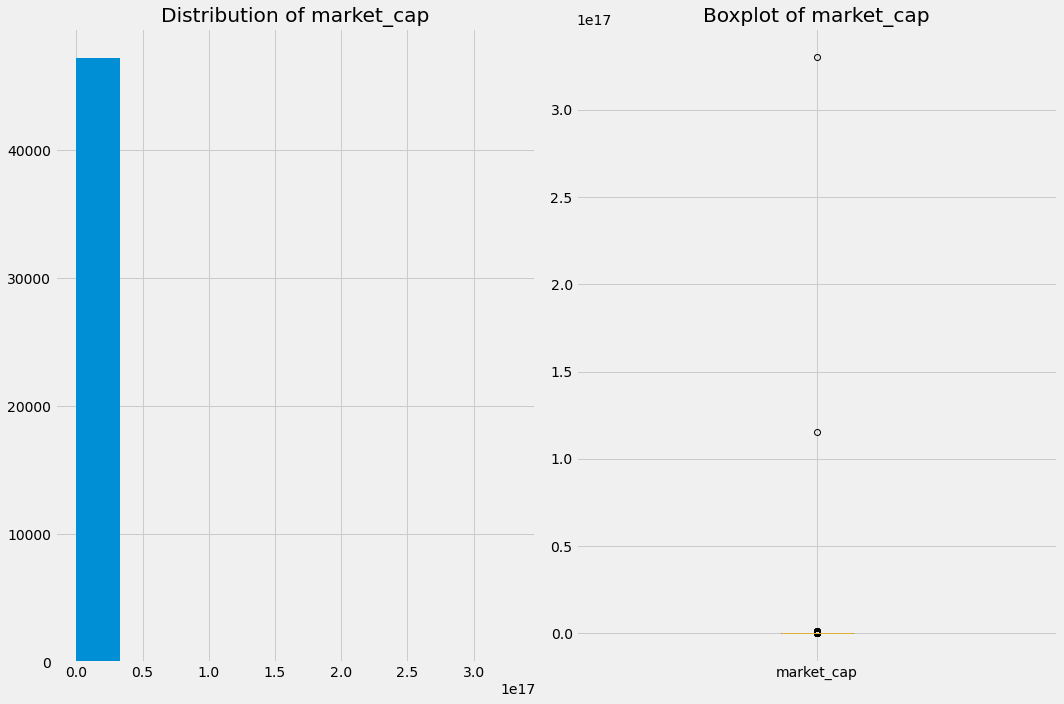

In [ ]:
#eval numerical features
for col in num_cols:
  col_eval(df_clean, num_col=col)

> **OBSERVATIONS**
> - All numeric features show outliers on the high end. This distorts the distributions but should not require remediation as each stock will be modeled separately.

# Feature Engineering 

## Market Cap Groupings

In [ ]:
#create a copy of dataframe for timeseries
df_clean_ts = df_clean.copy()

In [ ]:
#create market cap grouping
df_clean['market_cap_group'] = None

In [ ]:
#fill in market_cap_group based on market_cap value
df_clean.loc[df_clean['market_cap'] > 200_000_000_000, 'market_cap_group'] = 'Mega-Cap'

df_clean.loc[(df_clean['market_cap'] <= 200_000_000_000) &
             (df_clean['market_cap'] > 10_000_000_000), 'market_cap_group'] = 'Large-Cap'

df_clean.loc[(df_clean['market_cap'] <= 10_000_000_000) &
             (df_clean['market_cap'] > 2_000_000_000), 'market_cap_group'] = 'Mid-Cap'

df_clean.loc[(df_clean['market_cap'] <= 2_000_000_000) &
             (df_clean['market_cap'] > 300_000_000), 'market_cap_group'] = 'Small-Cap'

df_clean.loc[df_clean['market_cap'] <= 300_000_000, 'market_cap_group'] = 'Micro-Cap'

In [ ]:
#filter dataframe to only include 2020 performance
df_clean = df_clean.loc[df_clean['date'] == '2020-12-31']

In [ ]:
#remove the date column
df_clean.drop(columns='date', inplace=True)

In [ ]:
#filter dataframe to only micro-cap companies
df_clean = df_clean.loc[df_clean['market_cap_group'] == 'Micro-Cap']

## Value Ranking

In [ ]:
#create value_ranking
performance_cols = ['pe_ratio','ev_to_operating_cashflow',
                    'enterprise_value_over_EBITDA','ev_to_free_cashflow',
                    'price_to_sales_ratio']

for col in performance_cols:
  df_clean[col+'_rank'] = None
  df_clean.sort_values(by=col, ascending=False, inplace=True)
  df_clean.reset_index(inplace=True, drop=True)
  for row in df_clean:
    df_clean[col+'_rank'] = df_clean[row].index + 1

#create value score feature
df_clean['value_score'] = df_clean['pe_ratio_rank'] + \
                            df_clean['ev_to_operating_cashflow_rank'] + \
                            df_clean['enterprise_value_over_EBITDA_rank'] + \
                            df_clean['ev_to_free_cashflow_rank'] + \
                            df_clean['price_to_sales_ratio_rank']

#create value ranking feature
df_clean.sort_values(by='value_score', ascending=True, inplace=True)
df_clean.reset_index(inplace=True, drop=True)
for row in df_clean:
  df_clean['2020_value_ranking'] = df_clean.index + 1

#print the top 20 value companies
df_clean[['company_name', 'symbol', 'symbol_id', 'market_cap_group', 'sector', 
          'industry', '2020_value_ranking']]

,company_name,symbol,symbol_id,market_cap_group,sector,industry,2020_value_ranking
0,CKX Lands Inc,CKX,6179,Micro-Cap,Real Estate,Real Estate Services,1
1,"Global Healthcare REIT, Inc.",GBCS,9192,Micro-Cap,Real Estate,REIT—Healthcare Facilities,2
2,Transcontinental Realty Investors Inc,TCI,18476,Micro-Cap,Real Estate,Real Estate Services,3
3,Smith Micro Software Inc,SMSI,17611,Micro-Cap,Technology,Software Application,4
4,"Where Food Comes From, Inc.",WFCF,20212,Micro-Cap,Technology,Software,5
...,...,...,...,...,...,...,...
421,Ashford Hospitality Trust Inc,AHT,3008,Micro-Cap,Real Estate,REIT Hotel & Motel,422
422,Points International Ltd,PTS.TO,15845,Micro-Cap,Communication Services,Internet Content & Information,423
423,Points International Ltd,PCOM,15072,Micro-Cap,Communication Services,Internet Content & Information,424
424,Hudson Global Inc,HSON,10496,Micro-Cap,Industrials,Staffing & Employment Services,425


In [ ]:
#drop ranking rows
df_clean.drop(columns=['pe_ratio_rank','ev_to_operating_cashflow_rank',
                       'enterprise_value_over_EBITDA_rank', 'ev_to_free_cashflow_rank',
                       'price_to_sales_ratio_rank', 'value_score'], inplace=True)

In [ ]:
df_clean

,symbol_id,pe_ratio,ev_to_operating_cashflow,enterprise_value_over_EBITDA,ev_to_free_cashflow,price_to_sales_ratio,revenue_per_share,market_cap,company_name,industry,exchange,sector,country,symbol,market_cap_group,2020_value_ranking
0,6179,59.297,97.464,510.13800000000003,104.40700000000001,29.949,0.34600000000000003,"20,124,248.2",CKX Lands Inc,Real Estate Services,NYSE American,Real Estate,US,CKX,Micro-Cap,1
1,9192,"5,702.679",19.238,"10,615.416000000001",30.084,807.192,0.001,"16,893,469.22","Global Healthcare REIT, Inc.",REIT—Healthcare Facilities,Other OTC,Real Estate,US,GBCS,Micro-Cap,2
2,18476,27.961,110.756,42.349,110.756,3.27,6.541,"186,473,027.412233",Transcontinental Realty Investors Inc,Real Estate Services,New York Stock Exchange,Real Estate,US,TCI,Micro-Cap,3
3,17611,62.31399999999999,29.503,32.826,35.417,5.059,1.2570000000000001,"259,538,880.0",Smith Micro Software Inc,Software Application,Nasdaq Capital Market,Technology,US,SMSI,Micro-Cap,4
4,20212,60.958999999999996,33.071,30.134,40.789,4.205,3.281,"84,428,400.0","Where Food Comes From, Inc.",Software,Other OTC,Technology,US,WFCF,Micro-Cap,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,3008,-0.054000000000000006,-24.511,-43.528999999999996,-24.511,0.057,50.907,"29,152,404.0",Ashford Hospitality Trust Inc,REIT Hotel & Motel,New York Stock Exchange,Real Estate,US,AHT,Micro-Cap,422
422,15845,-42.331,-33.565,-459.671,-23.068,1.043,16.44,"226,769,425.05",Points International Ltd,Internet Content & Information,Toronto,Communication Services,CA,PTS.TO,Micro-Cap,423
423,15072,-33.495,-24.147,-330.68699999999995,-16.595,0.825,16.44,"179,432,133.99",Points International Ltd,Internet Content & Information,Nasdaq Capital Market,Communication Services,CA,PCOM,Micro-Cap,424
424,10496,-39.446,-21.252,-12.284,-20.929000000000002,0.483,32.400999999999996,"49,031,460.0",Hudson Global Inc,Staffing & Employment Services,Nasdaq Global Select,Industrials,US,HSON,Micro-Cap,425


# DATA EXPLORATION

In [ ]:
df_explore = df_clean.copy()

# MODELING

I will now create a dataframe with only the top 10 value stocks and recombine their historical data to begin modeling for forecasting their growth based on `revenue_per_share`.

In [ ]:
#create a ts copy
df_model_ts = df_clean_ts.copy()

In [ ]:
#create a list of the top 10 stocks for modeling
modeling_symbol_ids = df_clean['symbol_id'][:10].tolist()
modeling_symbol_ids

['6179',
 '9192',
 '18476',
 '17611',
 '20212',
 '6560',
 '3918',
 '13703',
 '11068',
 '13895']

In [ ]:
#filter timeseries dataframe to include only the top 10 value symbol_ids
df_model_ts = df_model_ts.loc[df_model_ts['symbol_id'].isin(modeling_symbol_ids)]

In [ ]:
#set index to date column
df_model_ts.set_index('date', inplace=True)

In [ ]:
#remove all columns except for ones needed for modeling
df_model_ts.drop(columns=['pe_ratio','ev_to_operating_cashflow',
                          'enterprise_value_over_EBITDA', 'ev_to_free_cashflow',
                          'price_to_sales_ratio', 'market_cap'], inplace=True)

In [ ]:
df_model_ts.head()

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
2020-12-31,3918,3.69,American Realty Investors Inc,Real Estate Development,New York Stock Exchange,Real Estate,US,ARL
2019-12-31,3918,2.9989999999999997,American Realty Investors Inc,Real Estate Development,New York Stock Exchange,Real Estate,US,ARL
2018-12-31,3918,7.568,American Realty Investors Inc,Real Estate Development,New York Stock Exchange,Real Estate,US,ARL
2017-12-31,3918,8.136000000000001,American Realty Investors Inc,Real Estate Development,New York Stock Exchange,Real Estate,US,ARL
2016-12-31,3918,7.712999999999999,American Realty Investors Inc,Real Estate Development,New York Stock Exchange,Real Estate,US,ARL


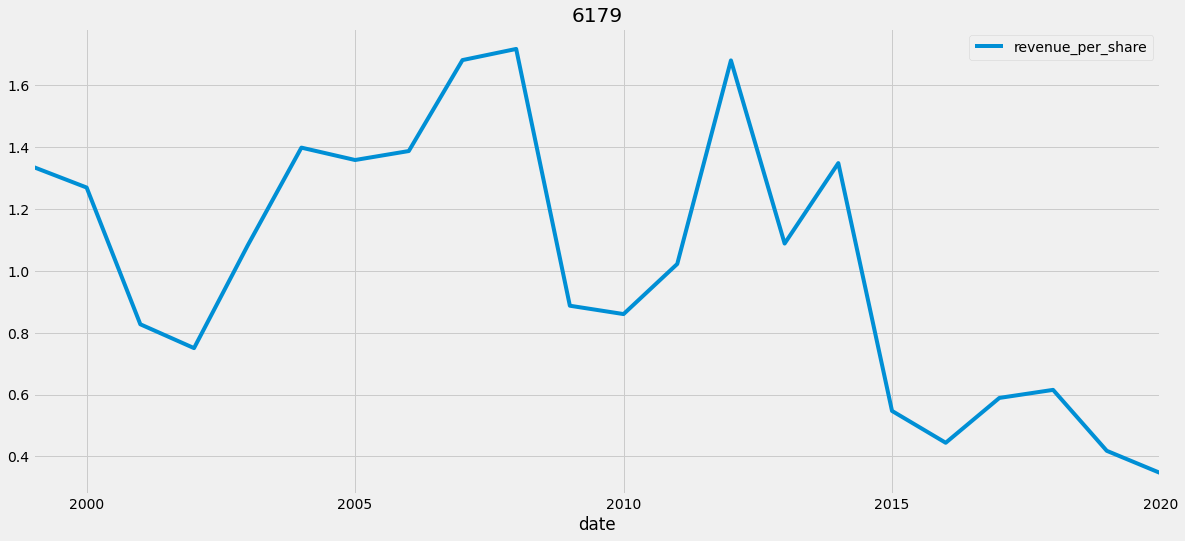

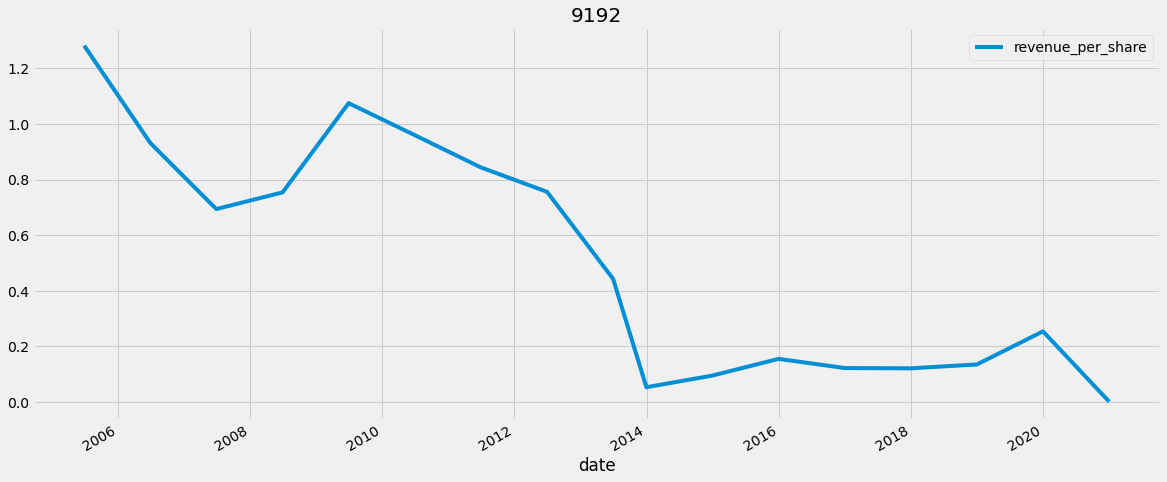

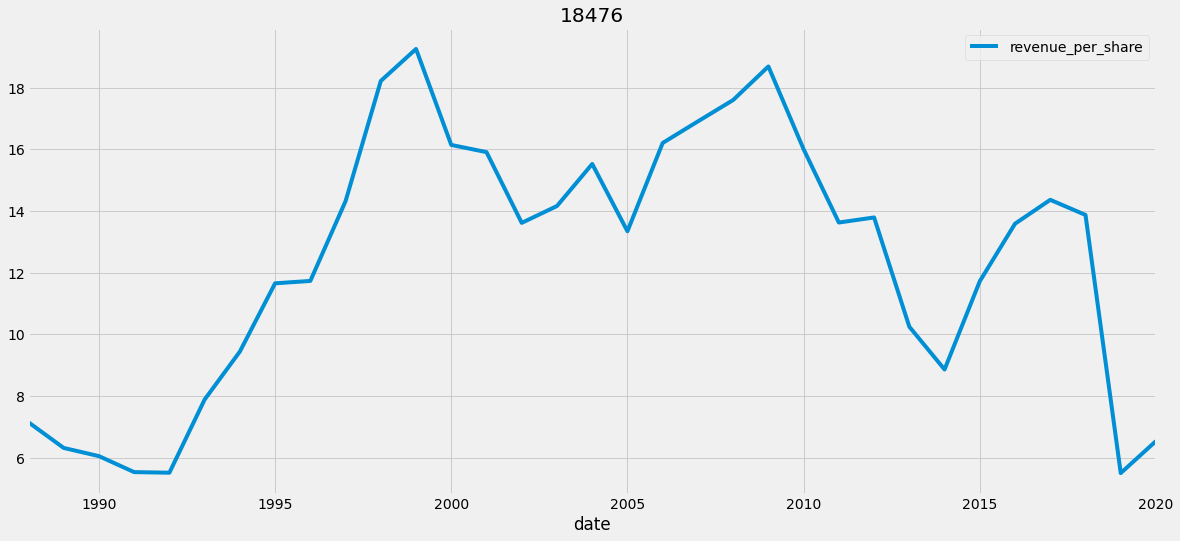

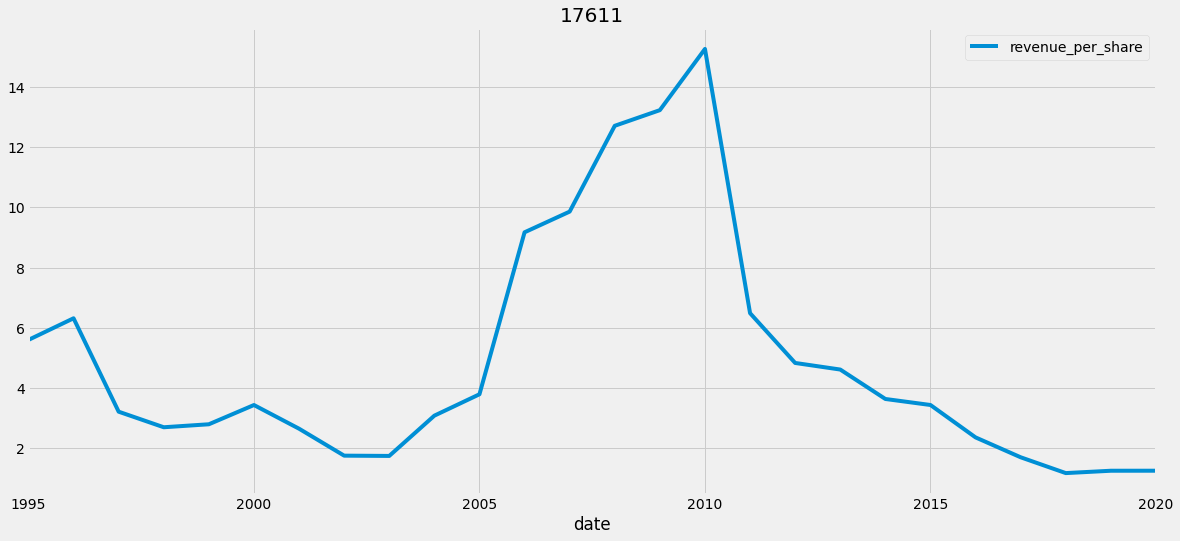

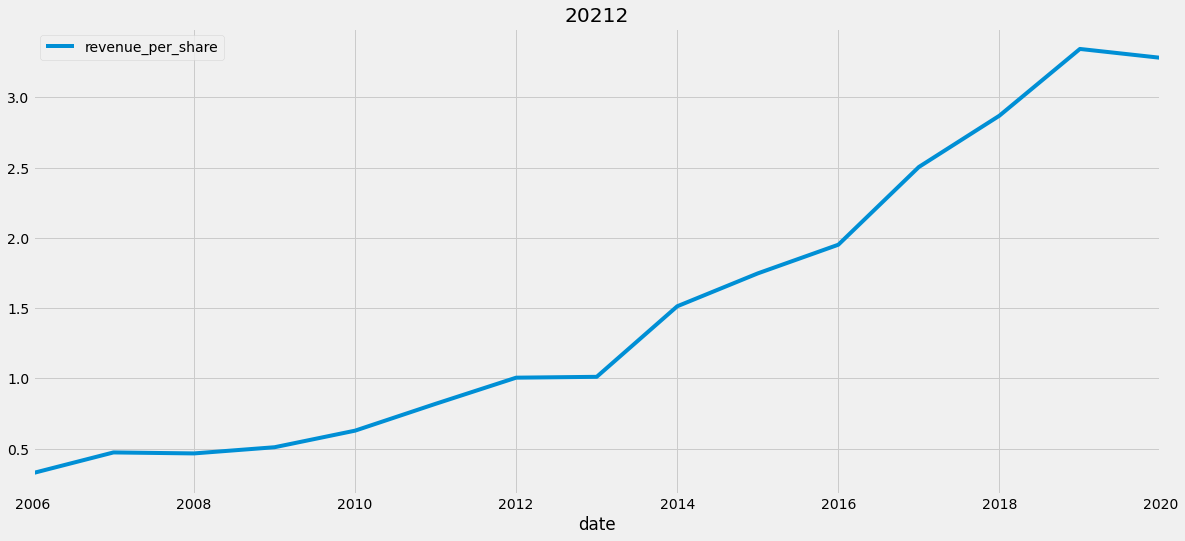

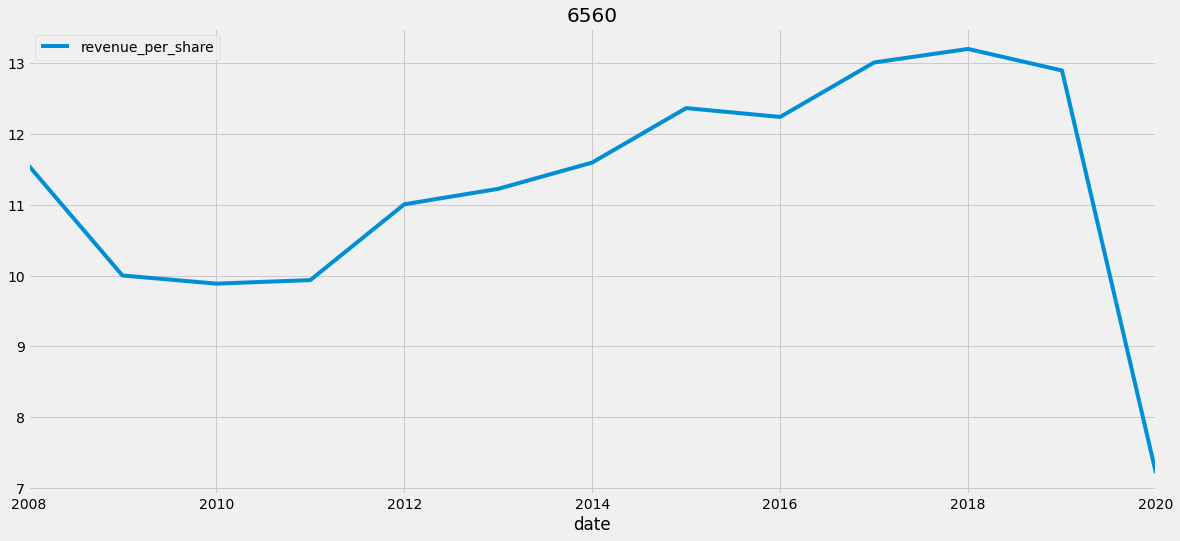

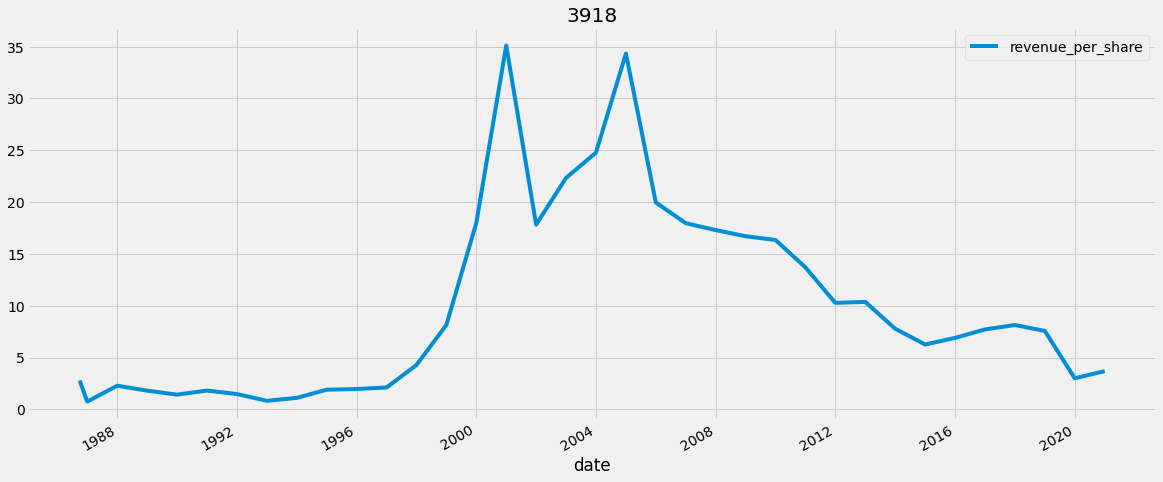

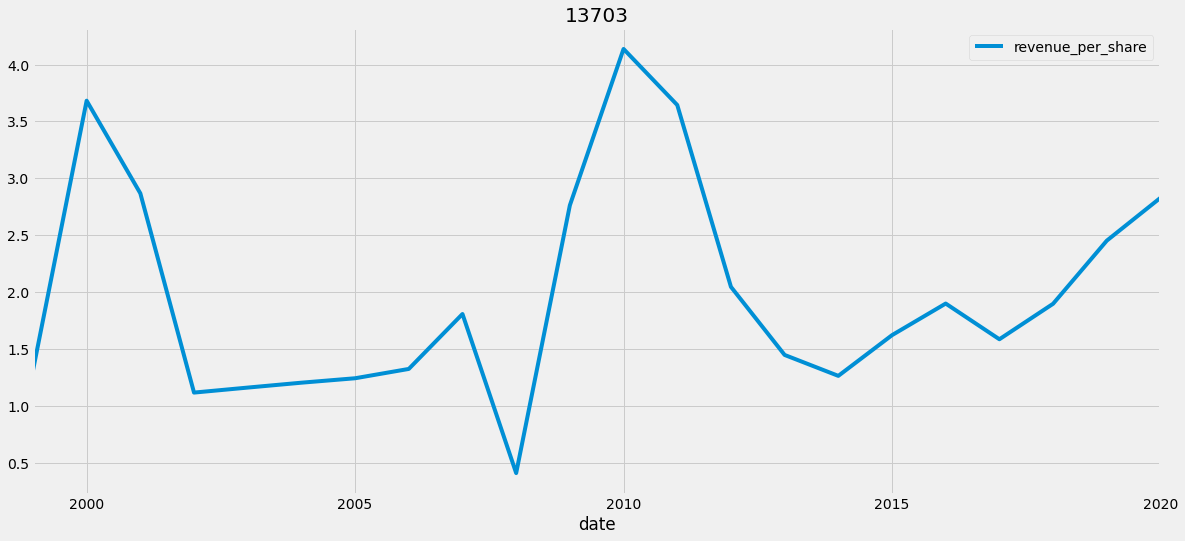

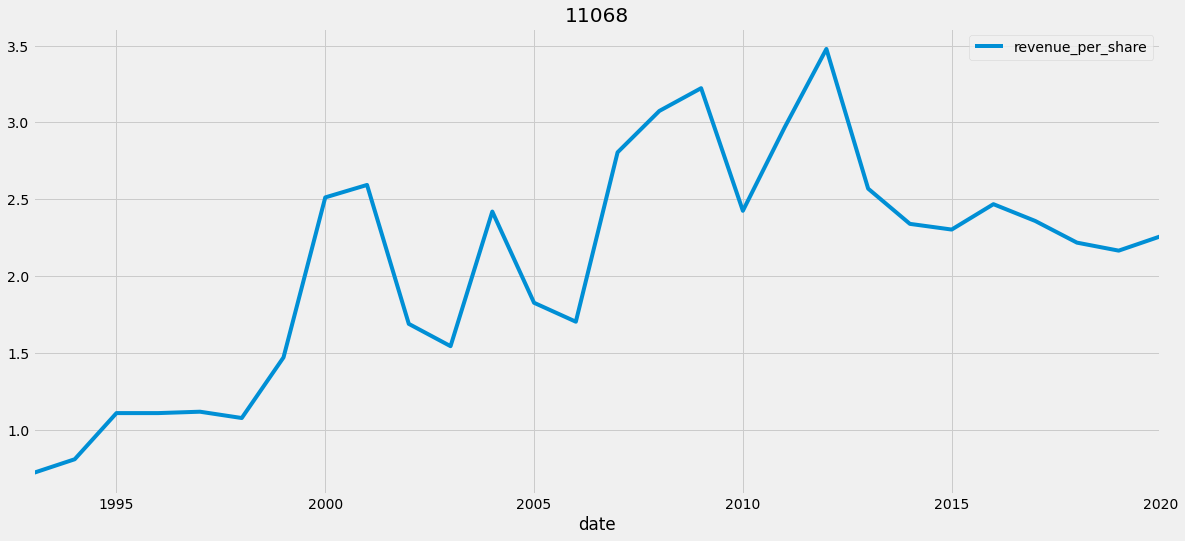

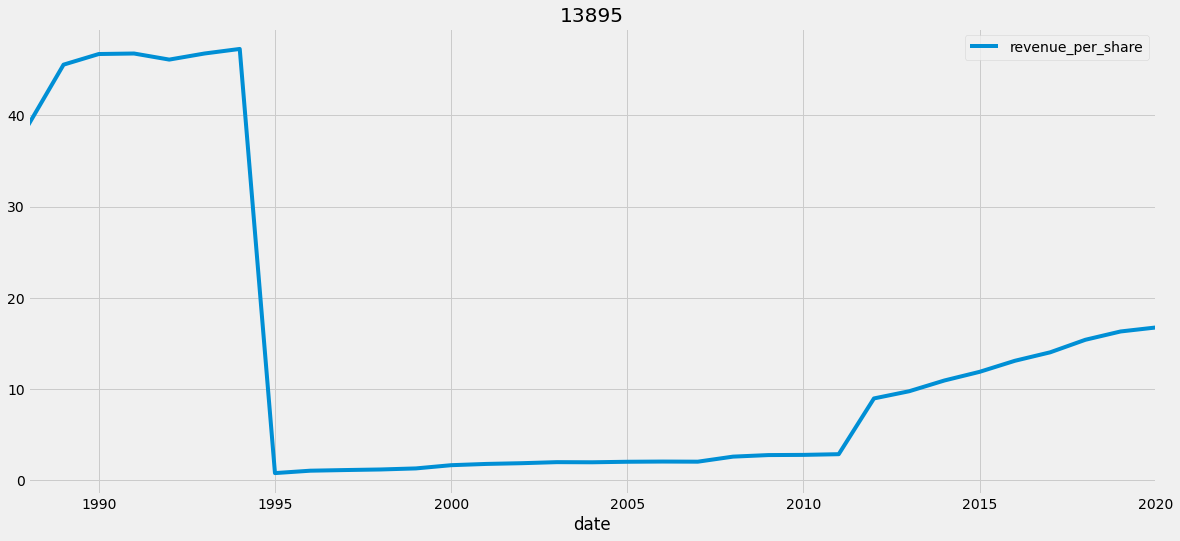

In [ ]:
#plot all time series for top 10 value stocks
for symbol in modeling_symbol_ids:
  df_model_ts.loc[df_model_ts['symbol_id'] == symbol].plot()
  plt.title(f'{symbol}')
  

## Model Symbol ID 6179

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
1999-12-31,6179,1.3359999999999999,CKX Lands Inc,Real Estate Services,NYSE American,Real Estate,US,CKX
2000-12-31,6179,1.2690000000000001,CKX Lands Inc,Real Estate Services,NYSE American,Real Estate,US,CKX
2001-12-31,6179,0.8270000000000001,CKX Lands Inc,Real Estate Services,NYSE American,Real Estate,US,CKX
2002-12-31,6179,0.75,CKX Lands Inc,Real Estate Services,NYSE American,Real Estate,US,CKX
2003-12-31,6179,1.082,CKX Lands Inc,Real Estate Services,NYSE American,Real Estate,US,CKX
2004-12-31,6179,1.3980000000000001,CKX Lands Inc,Real Estate Services,NYSE American,Real Estate,US,CKX
2005-12-31,6179,1.358,CKX Lands Inc,Real Estate Services,NYSE American,Real Estate,US,CKX
2006-12-31,6179,1.3869999999999998,CKX Lands Inc,Real Estate Services,NYSE American,Real Estate,US,CKX
2007-12-31,6179,1.681,CKX Lands Inc,Real Estate Services,NYSE American,Real Estate,US,CKX


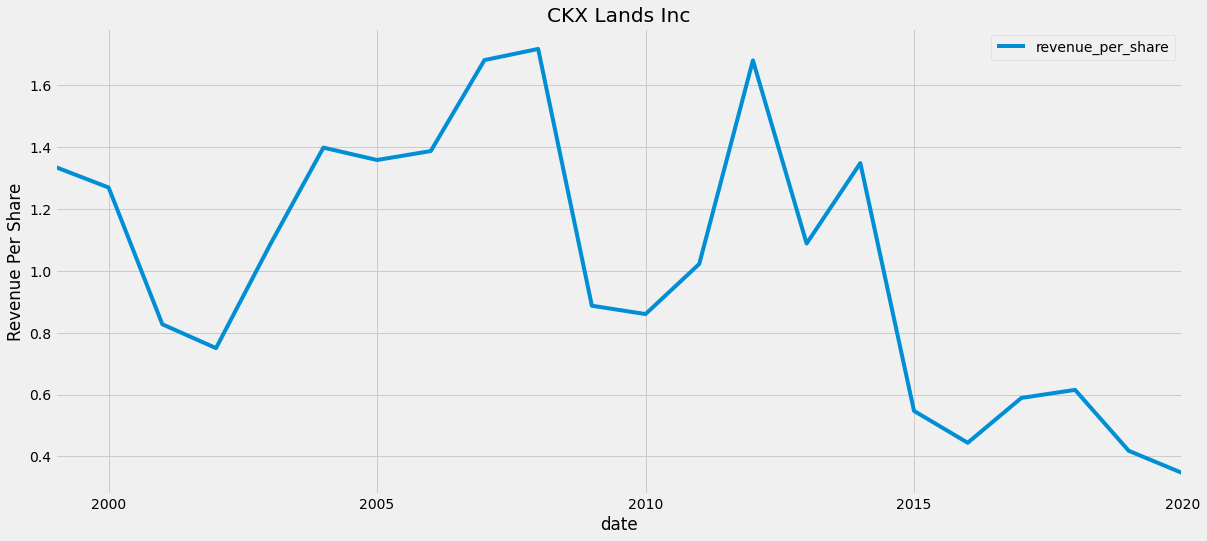

In [ ]:
#create dataframe and plot
df_model_ts_6179 = timeseries_creation(df_model_ts, '6179')

### Seasonality & Stationarity

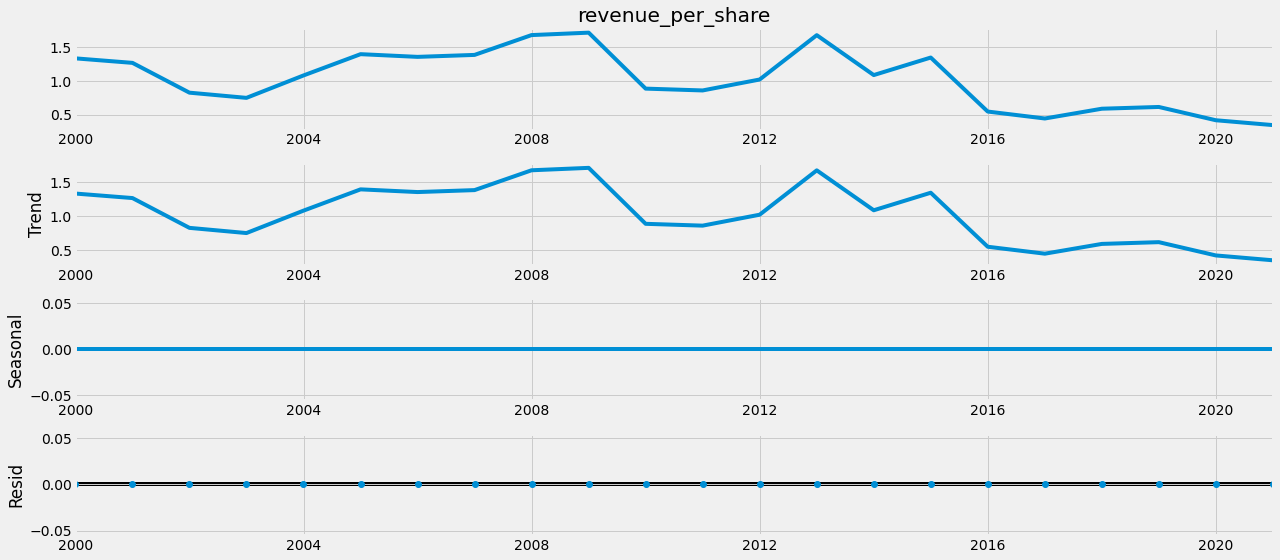

Augmented Dickey-Fuller Test Results
ADF test statistic   -0.014985470150465013
p-value                 0.9572751129953195
# lags used                            9.0
# observations                        12.0


The data is not stationary


In [ ]:
#check for seasonality and stationarity
seasonality_stationarity_check(df_model_ts_6179['revenue_per_share'])

> **OBSERVATIONS**
> - The ADFuller test shows the data is not stationary and will require differencing. There is no seasonality.

> **ACTIONS**
> - I will evaluate how differincing will impact the models performance

### Model Creation & Evaluation

                               SARIMAX Results                                
Dep. Variable:      revenue_per_share   No. Observations:                   19
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  -9.835
Date:                Sun, 20 Jun 2021   AIC                             23.670
Time:                        16:53:14   BIC                             25.559
Sample:                    12-31-1999   HQIC                            23.989
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9393      0.072     12.964      0.000       0.797       1.081
sigma2         0.1473      0.061      2.397      0.017       0.027       0.268
Ljung-Box (L1) (Q):                   0.53   Jarque-

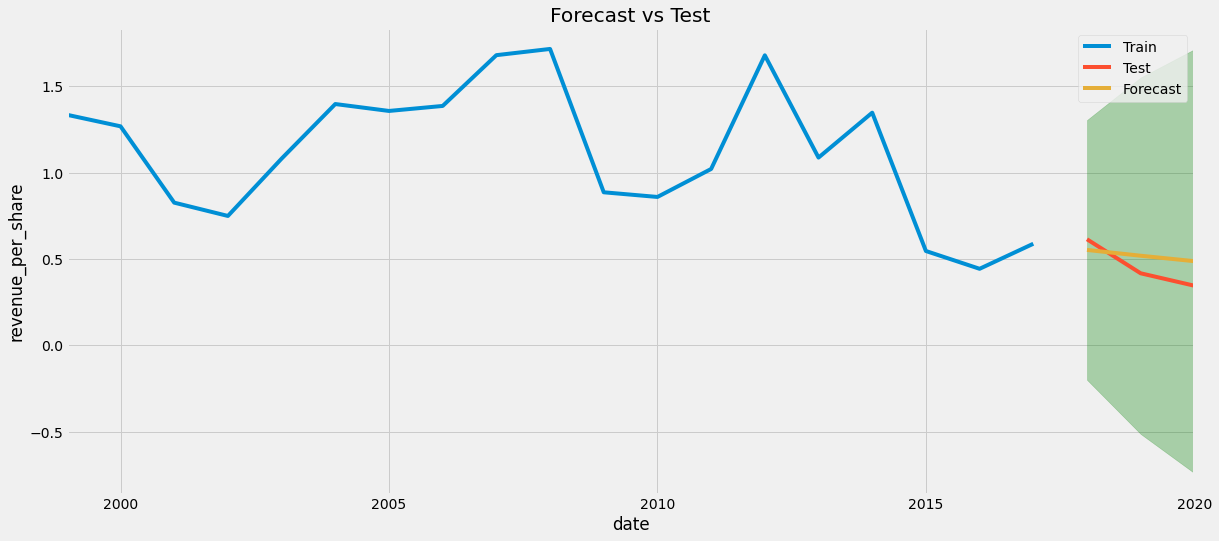

In [ ]:
#create and evaluate the auto model
auto_model, train, test, auto_model_ts = create_eval_model(df=df_model_ts_6179, 
                                            ts_col='revenue_per_share', 
                                            test_size=3, auto=True)


                               SARIMAX Results                                
Dep. Variable:      revenue_per_share   No. Observations:                   18
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  -8.361
Date:                Sun, 20 Jun 2021   AIC                             20.723
Time:                        16:53:14   BIC                             22.389
Sample:                    12-31-1999   HQIC                            20.888
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1485      0.339     -0.439      0.661      -0.812       0.515
sigma2         0.1564      0.060      2.616      0.009       0.039       0.274
Ljung-Box (L1) (Q):                   0.02   Jarque-

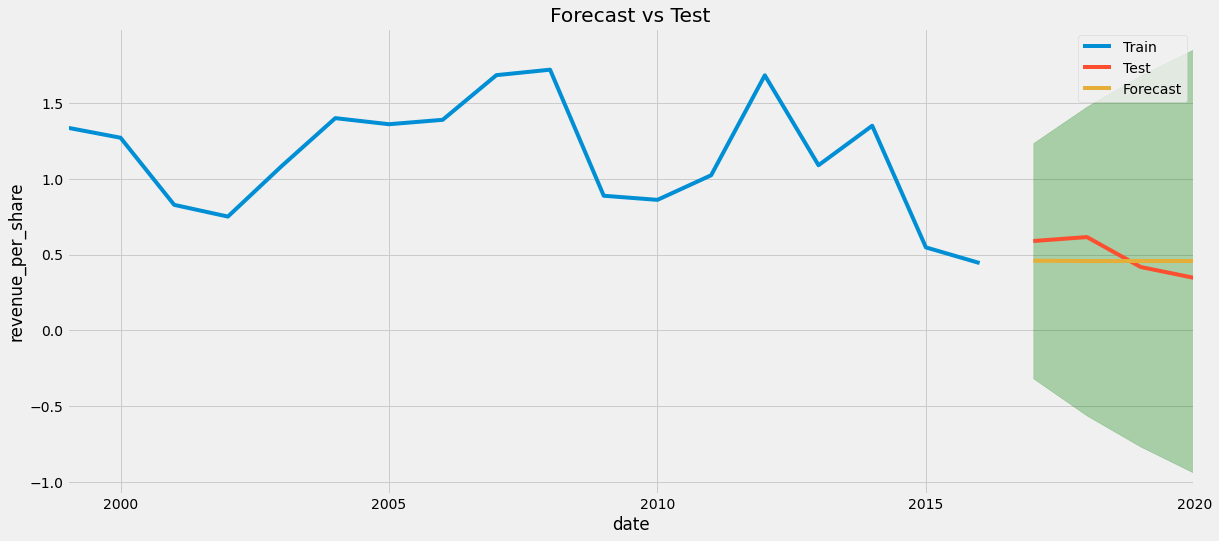

In [ ]:
#create and evaluate ARIMA(1,1,0) model
user_model = create_eval_model(df=df_model_ts_6179, 
                                            ts_col='revenue_per_share', 
                                            test_size=4, order=(1,1,0), auto=False)

> **OBSERVATIONS**
> - The rmse is pretty good for both models considering it is less than 12% of the mean value of the timeseries. However, the auto-arima model (1,0,0) did perform best with a 3 year train-test split.

> **ACTIONS**
> - I will utilize the auto-arima model to forecast into the future

### Model Forecast

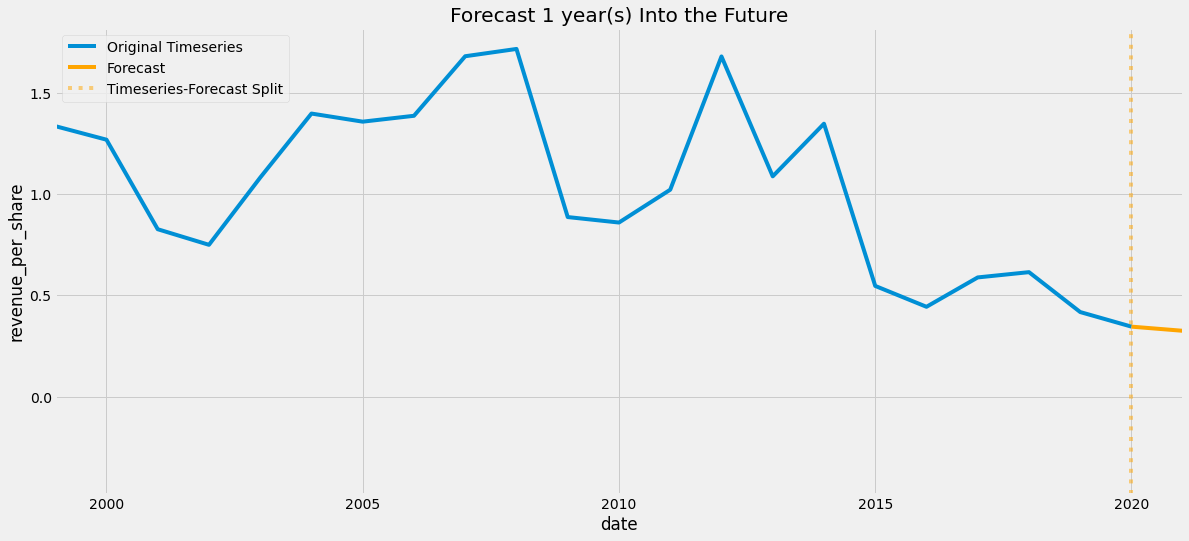



The percent change 1 year(s) into the future is -5.91%


In [ ]:
#forecast 1 year into the future and save percent change
percent_change_6179 = forecast(df_model_ts_6179, ts_col='revenue_per_share', 
                               best_model_ts=auto_model_ts, forecast_len=0);

> **OBSERVATIONS**
> - The forecast shows a decrease in revenue per share of 5.91% between 2020 and 2021.

## Model Symbol ID 9192

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
2005-06-30,9192,1.2819999999999998,"Global Healthcare REIT, Inc.",REIT—Healthcare Facilities,Other OTC,Real Estate,US,GBCS
2006-06-30,9192,0.932,"Global Healthcare REIT, Inc.",REIT—Healthcare Facilities,Other OTC,Real Estate,US,GBCS
2007-06-30,9192,0.6940000000000001,"Global Healthcare REIT, Inc.",REIT—Healthcare Facilities,Other OTC,Real Estate,US,GBCS
2008-06-30,9192,0.754,"Global Healthcare REIT, Inc.",REIT—Healthcare Facilities,Other OTC,Real Estate,US,GBCS
2009-06-30,9192,1.075,"Global Healthcare REIT, Inc.",REIT—Healthcare Facilities,Other OTC,Real Estate,US,GBCS
2010-06-30,9192,0.96,"Global Healthcare REIT, Inc.",REIT—Healthcare Facilities,Other OTC,Real Estate,US,GBCS
2011-06-30,9192,0.8440000000000001,"Global Healthcare REIT, Inc.",REIT—Healthcare Facilities,Other OTC,Real Estate,US,GBCS
2012-06-30,9192,0.7559999999999999,"Global Healthcare REIT, Inc.",REIT—Healthcare Facilities,Other OTC,Real Estate,US,GBCS
2013-06-30,9192,0.44299999999999995,"Global Healthcare REIT, Inc.",REIT—Healthcare Facilities,Other OTC,Real Estate,US,GBCS


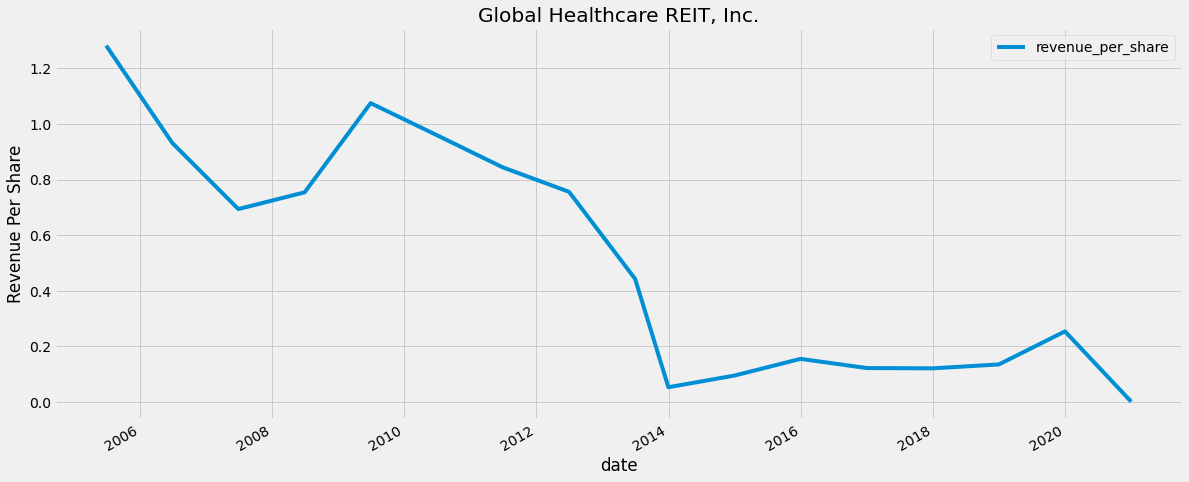

In [ ]:
#create dataframe and plot
df_model_ts_9192 = timeseries_creation(df_model_ts, '9192')

> **OBSERVATIONS**
> - Different cadence to the dates, therefore will skip modeling for this stock

## Model Symbol ID 18476

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
1988-12-31,18476,7.152,Transcontinental Realty Investors Inc,Real Estate Services,New York Stock Exchange,Real Estate,US,TCI
1989-12-31,18476,6.319,Transcontinental Realty Investors Inc,Real Estate Services,New York Stock Exchange,Real Estate,US,TCI
1990-12-31,18476,6.053,Transcontinental Realty Investors Inc,Real Estate Services,New York Stock Exchange,Real Estate,US,TCI
1991-12-31,18476,5.535,Transcontinental Realty Investors Inc,Real Estate Services,New York Stock Exchange,Real Estate,US,TCI
1992-12-31,18476,5.515,Transcontinental Realty Investors Inc,Real Estate Services,New York Stock Exchange,Real Estate,US,TCI
1993-12-31,18476,7.888,Transcontinental Realty Investors Inc,Real Estate Services,New York Stock Exchange,Real Estate,US,TCI
1994-12-31,18476,9.443999999999999,Transcontinental Realty Investors Inc,Real Estate Services,New York Stock Exchange,Real Estate,US,TCI
1995-12-31,18476,11.657,Transcontinental Realty Investors Inc,Real Estate Services,New York Stock Exchange,Real Estate,US,TCI
1996-12-31,18476,11.735,Transcontinental Realty Investors Inc,Real Estate Services,New York Stock Exchange,Real Estate,US,TCI


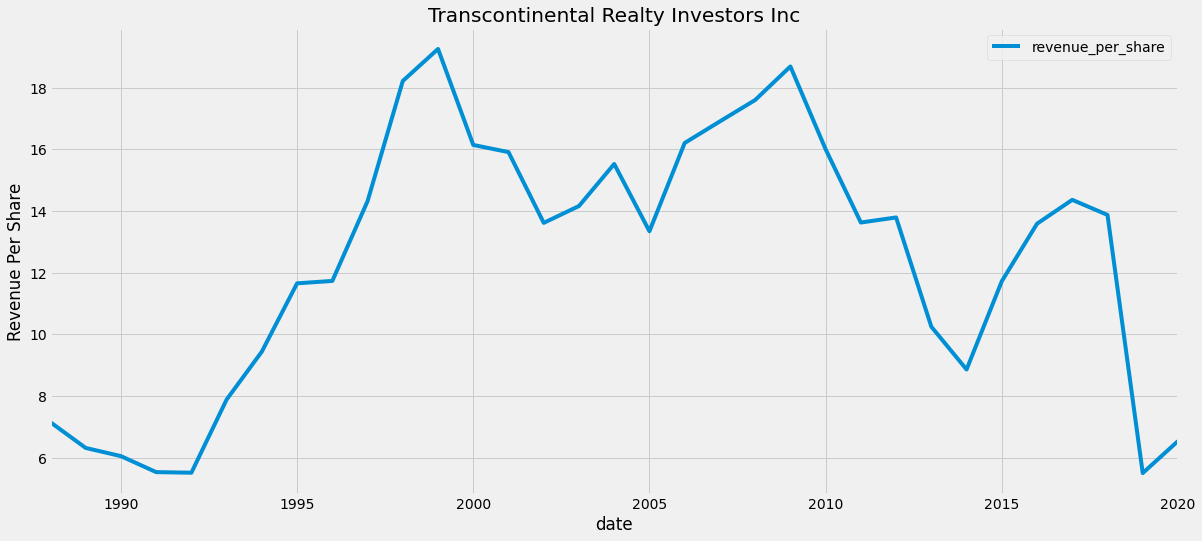

In [ ]:
#create dataframe and plot
df_model_ts_18476 = timeseries_creation(df_model_ts, '18476')

### Seasonality & Stationarity

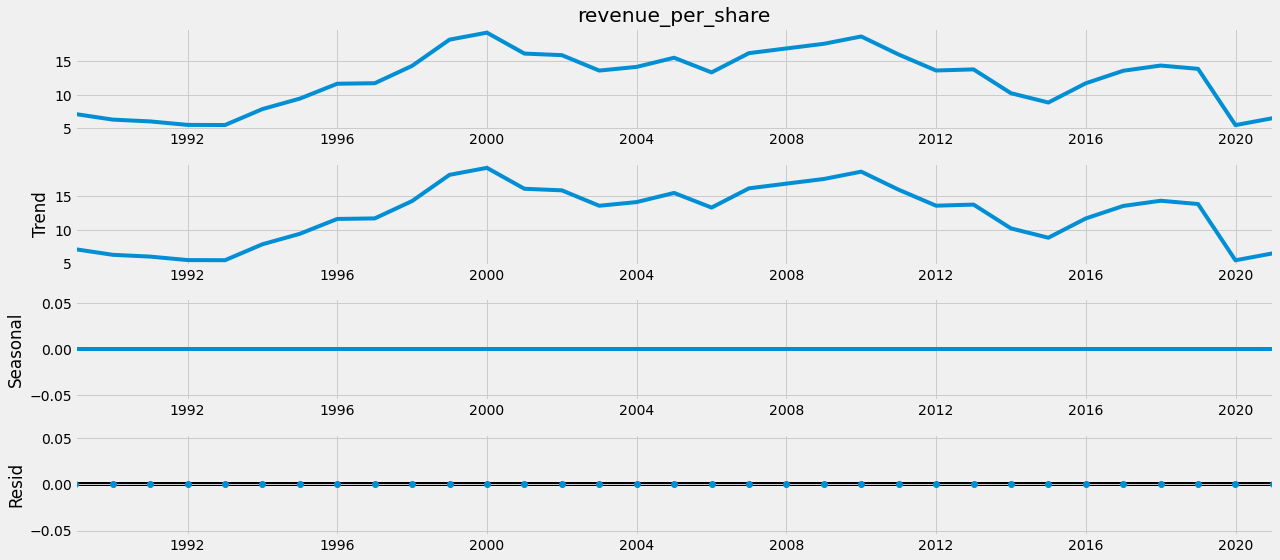

Augmented Dickey-Fuller Test Results
ADF test statistic   -1.5750485120839313
p-value              0.49611416830183536
# lags used                          0.0
# observations                      32.0


The data is not stationary


In [ ]:
#check for seasonality and stationarity
seasonality_stationarity_check(df_model_ts_18476['revenue_per_share'])

> **OBSERVATIONS**
> - The ADFuller test shows the data is not stationary and will require differencing. There is no seasonality.

> **ACTIONS**
> - I will evaluate how differincing will impact the models performance

### Model Creation & Evaluation

                               SARIMAX Results                                
Dep. Variable:      revenue_per_share   No. Observations:                   26
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -52.117
Date:                Sun, 20 Jun 2021   AIC                            106.234
Time:                        16:53:17   BIC                            107.453
Sample:                    12-31-1988   HQIC                           106.572
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.7866      1.369      2.766      0.006       1.103       6.470
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.40   Pr

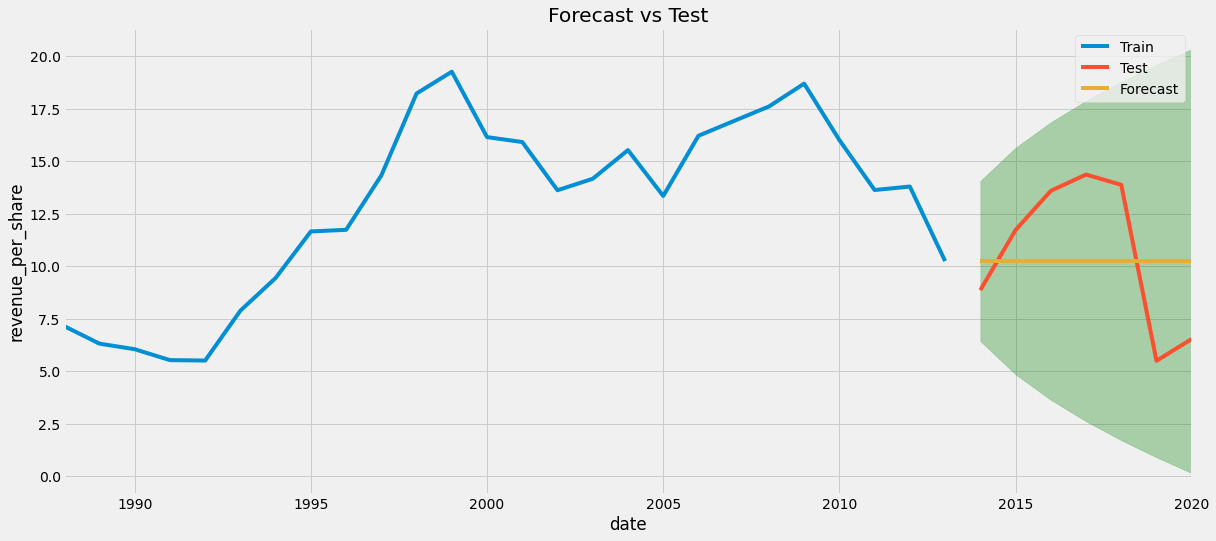

In [ ]:
#create and evaluate the auto model
auto_model, train, test, auto_model_ts = create_eval_model(df=df_model_ts_18476, 
                                            ts_col='revenue_per_share', 
                                            test_size=7, auto=True)

> **OBSERVATIONS**
> - The best fitting model is an ARIMA (0,1,0) with a test size of 7 years. 
> - The mse is 3.41 which is a bit high (30%) when compared to the average timeseries value. This is due to the volatility in the last 7 years of this stock

> **ACTIONS**
> - Will continue with this model for forecasting

### Model Forecast

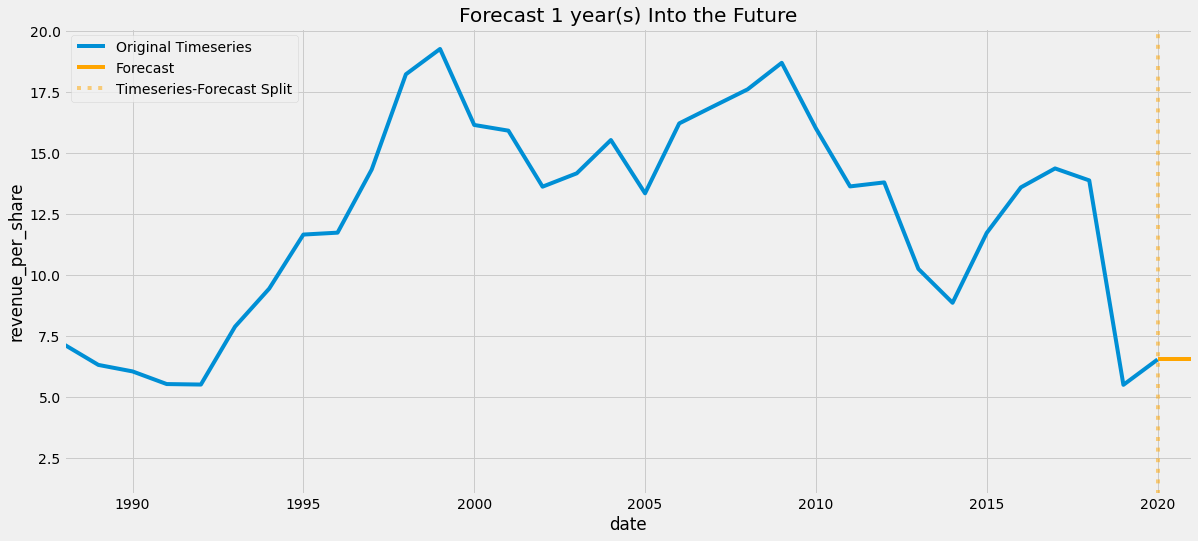



The percent change 1 year(s) into the future is 0.0%


In [ ]:
#forecast 1 year into the future and save percent change
percent_change_18476 = forecast(df_model_ts_18476, ts_col='revenue_per_share', 
                               best_model_ts=auto_model_ts, forecast_len=0);

> **OBSERVATIONS**
> - Due to the high volatility in the stock, the predicted trend is flat with a mean of 10.25.

## Model Symbol ID 17611

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
1995-12-31,17611,5.6,Smith Micro Software Inc,Software Application,Nasdaq Capital Market,Technology,US,SMSI
1996-12-31,17611,6.318,Smith Micro Software Inc,Software Application,Nasdaq Capital Market,Technology,US,SMSI
1997-12-31,17611,3.217,Smith Micro Software Inc,Software Application,Nasdaq Capital Market,Technology,US,SMSI
1998-12-31,17611,2.7,Smith Micro Software Inc,Software Application,Nasdaq Capital Market,Technology,US,SMSI
1999-12-31,17611,2.799,Smith Micro Software Inc,Software Application,Nasdaq Capital Market,Technology,US,SMSI
2000-12-31,17611,3.438,Smith Micro Software Inc,Software Application,Nasdaq Capital Market,Technology,US,SMSI
2001-12-31,17611,2.6519999999999997,Smith Micro Software Inc,Software Application,Nasdaq Capital Market,Technology,US,SMSI
2002-12-31,17611,1.757,Smith Micro Software Inc,Software Application,Nasdaq Capital Market,Technology,US,SMSI
2003-12-31,17611,1.7480000000000002,Smith Micro Software Inc,Software Application,Nasdaq Capital Market,Technology,US,SMSI


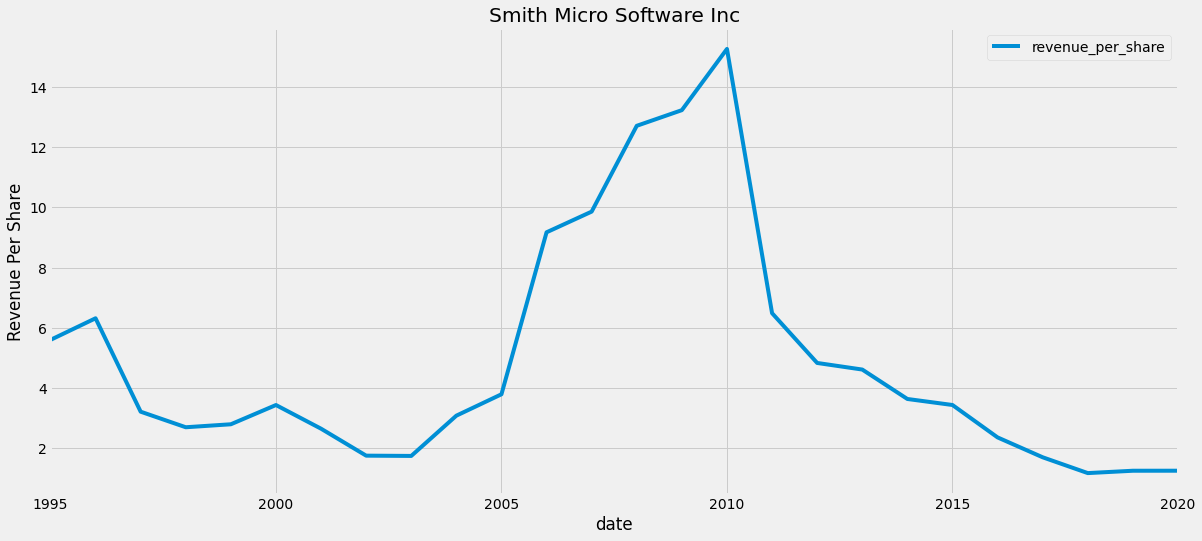

In [ ]:
#create dataframe and plot
df_model_ts_17611 = timeseries_creation(df_model_ts, '17611')

### Seasonality & Stationarity

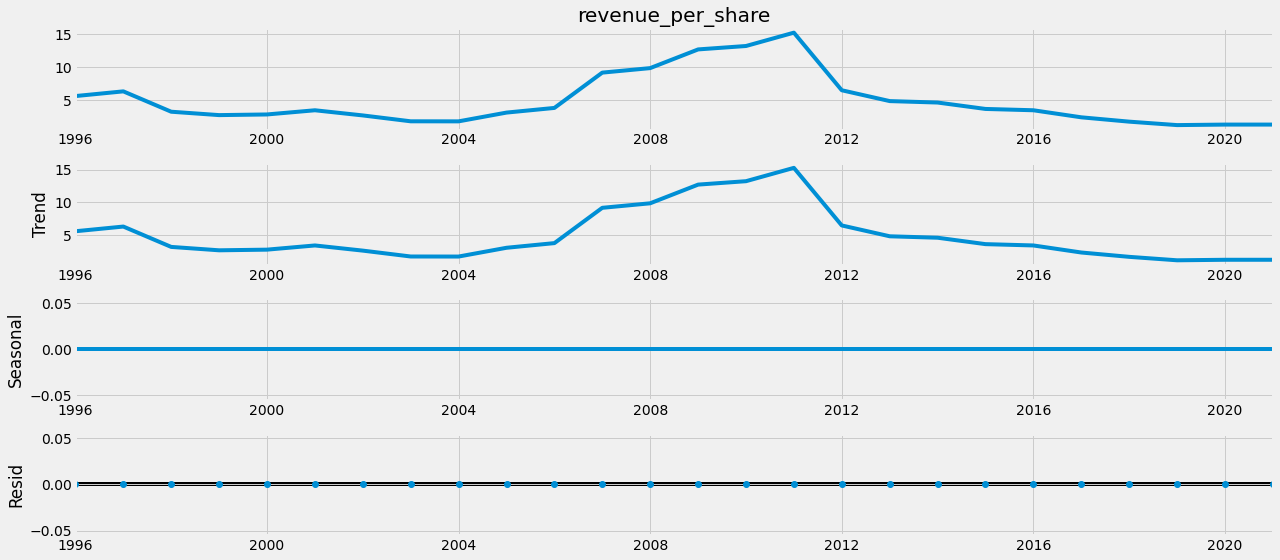

Augmented Dickey-Fuller Test Results
ADF test statistic   -1.3638597102734862
p-value               0.5994744281273899
# lags used                          0.0
# observations                      25.0


The data is not stationary


In [ ]:
#check for seasonality and stationarity
seasonality_stationarity_check(df_model_ts_17611['revenue_per_share'])

> **OBSERVATIONS**
> - The data is not stationary and has no seasonality

> **ACTIONS**
> - Evaluate differencing if auto-arima doesn't

### Model Creation & Evaluation

                               SARIMAX Results                                
Dep. Variable:      revenue_per_share   No. Observations:                   23
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -54.064
Date:                Sun, 20 Jun 2021   AIC                            112.127
Time:                        16:53:20   BIC                            114.398
Sample:                    12-31-1995   HQIC                           112.698
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9134      0.056     16.451      0.000       0.805       1.022
sigma2         5.9605      1.439      4.142      0.000       3.140       8.781
Ljung-Box (L1) (Q):                   0.29   Jarque-

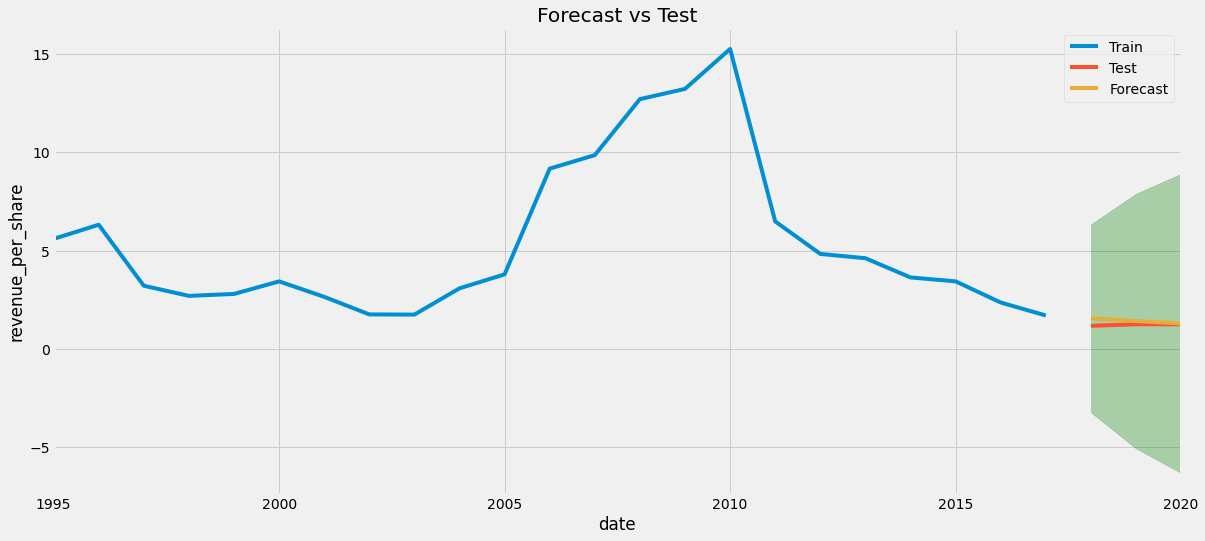

In [ ]:
#create and evaluate the auto model
auto_model = create_eval_model(df=df_model_ts_17611, 
                                            ts_col='revenue_per_share', 
                                            test_size=3, auto=True)

                               SARIMAX Results                                
Dep. Variable:      revenue_per_share   No. Observations:                   23
Model:               SARIMAX(2, 1, 0)   Log Likelihood                 -51.124
Date:                Sun, 20 Jun 2021   AIC                            108.247
Time:                        16:53:20   BIC                            111.521
Sample:                    12-31-1995   HQIC                           109.019
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0609      0.411      0.148      0.882      -0.744       0.866
ar.L2          0.1601      0.345      0.465      0.642      -0.515       0.835
sigma2         6.0929      1.382      4.409      0.0

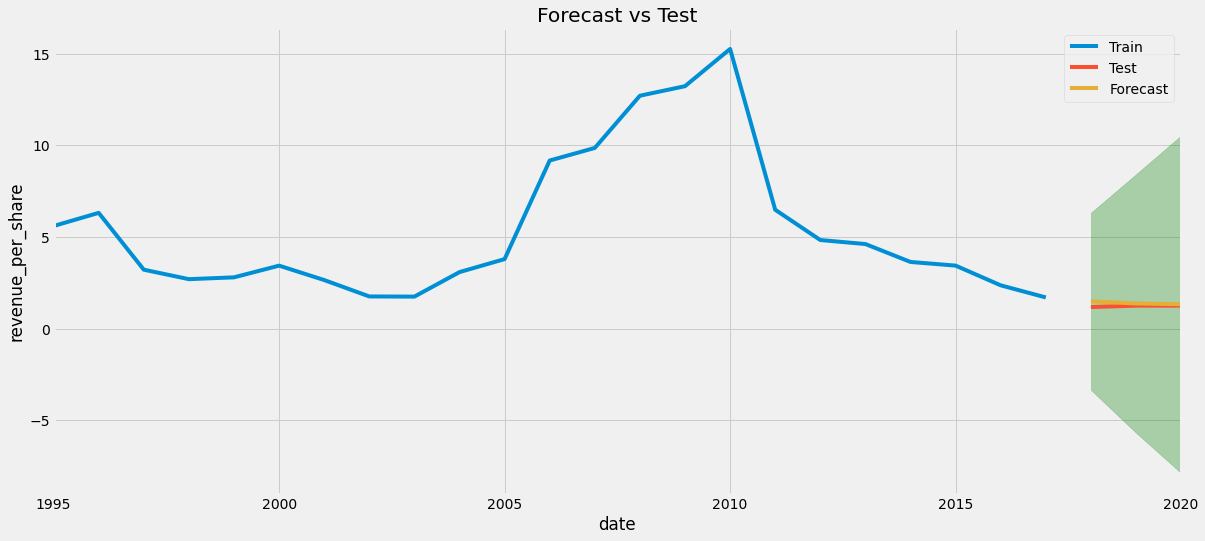

In [ ]:
#create and evaluate the manual model
user_model, train, test, user_model_ts = create_eval_model(df=df_model_ts_17611, 
                                            ts_col='revenue_per_share', 
                                            test_size=3, auto=False, order=(2,1,0))

> **OBSERVATIONS**
> - The auto-arima model ARIMA (1,0,0) had a MSE of .24 with a 3 year test size. The manual model ARIMA (2,1,0) has a MSE of .2 with a 3 year test size.

> **ACTIONS**
> - I will proceed with the manual ARIMA (2,1,0)

### Model Forecast

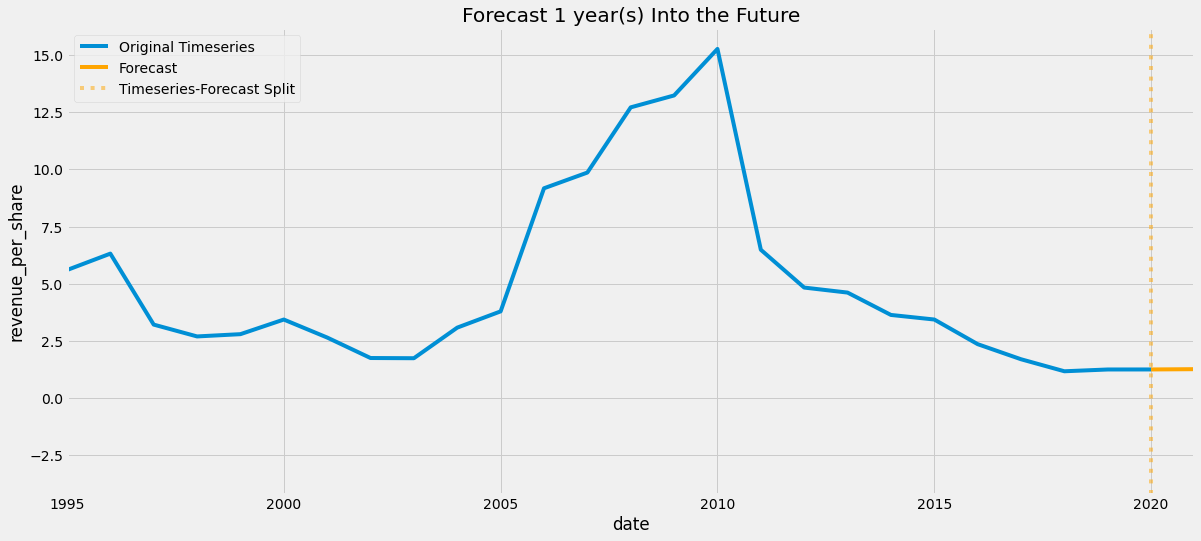



The percent change 1 year(s) into the future is 1.02%


In [ ]:
#forecast 1 year into the future and save percent change
percent_change_17611 = forecast(df_model_ts_17611, ts_col='revenue_per_share', 
                               best_model_ts=user_model_ts, forecast_len=0);

> **OBSERVATIONS**
> - The model forecasts a 1.02% increase in revenue per share between 2020 and 2021.

## Model Symbol ID 20212

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
2006-12-31,20212,0.326,"Where Food Comes From, Inc.",Software,Other OTC,Technology,US,WFCF
2007-12-31,20212,0.473,"Where Food Comes From, Inc.",Software,Other OTC,Technology,US,WFCF
2008-12-31,20212,0.466,"Where Food Comes From, Inc.",Software,Other OTC,Technology,US,WFCF
2009-12-31,20212,0.51,"Where Food Comes From, Inc.",Software,Other OTC,Technology,US,WFCF
2010-12-31,20212,0.628,"Where Food Comes From, Inc.",Software,Other OTC,Technology,US,WFCF
2011-12-31,20212,0.8190000000000001,"Where Food Comes From, Inc.",Software,Other OTC,Technology,US,WFCF
2012-12-31,20212,1.005,"Where Food Comes From, Inc.",Software,Other OTC,Technology,US,WFCF
2013-12-31,20212,1.011,"Where Food Comes From, Inc.",Software,Other OTC,Technology,US,WFCF
2014-12-31,20212,1.5130000000000001,"Where Food Comes From, Inc.",Software,Other OTC,Technology,US,WFCF


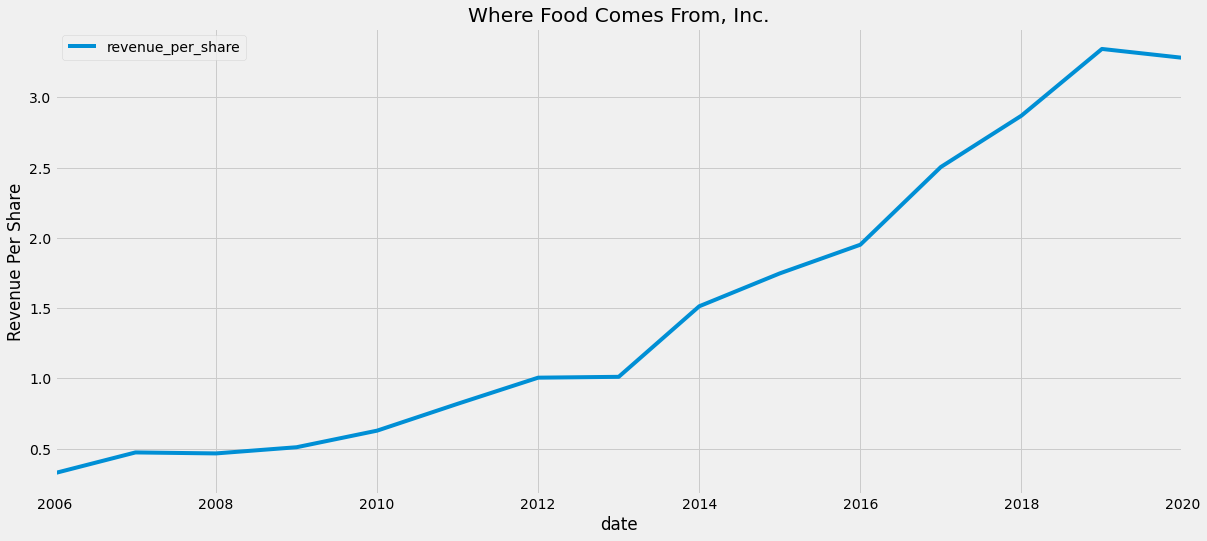

In [ ]:
#create dataframe and plot
df_model_ts_20212 = timeseries_creation(df_model_ts, '20212')

### Seasonality & Stationarity

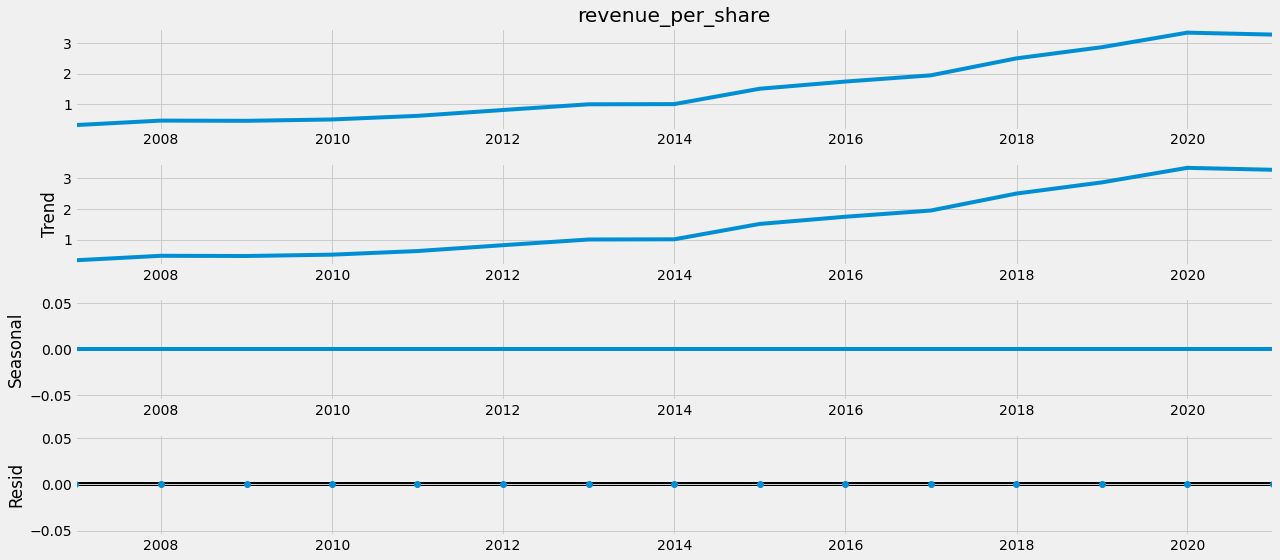

Augmented Dickey-Fuller Test Results
ADF test statistic    -3.2748934802499554
p-value              0.016038721949921085
# lags used                           5.0
# observations                        9.0


The data is stationary


In [ ]:
#check for seasonality and stationarity
seasonality_stationarity_check(df_model_ts_20212['revenue_per_share'])

> **OBSERVATIONS**
> - ADFuller Test shows data is stationary but the trend does not seem stationary. There is no seasonality.

> **ACTIONS**
> - I will manually explore differencing if auto-arima doesn't apply it.

### Model Creation & Evaluation

                               SARIMAX Results                                
Dep. Variable:      revenue_per_share   No. Observations:                   12
Model:               SARIMAX(0, 2, 0)   Log Likelihood                   0.689
Date:                Sun, 20 Jun 2021   AIC                              0.621
Time:                        16:53:23   BIC                              0.924
Sample:                    12-31-2006   HQIC                             0.289
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0510      0.022      2.323      0.020       0.008       0.094
Ljung-Box (L1) (Q):                   2.97   Jarque-Bera (JB):                 0.84
Prob(Q):                              0.08   Pr

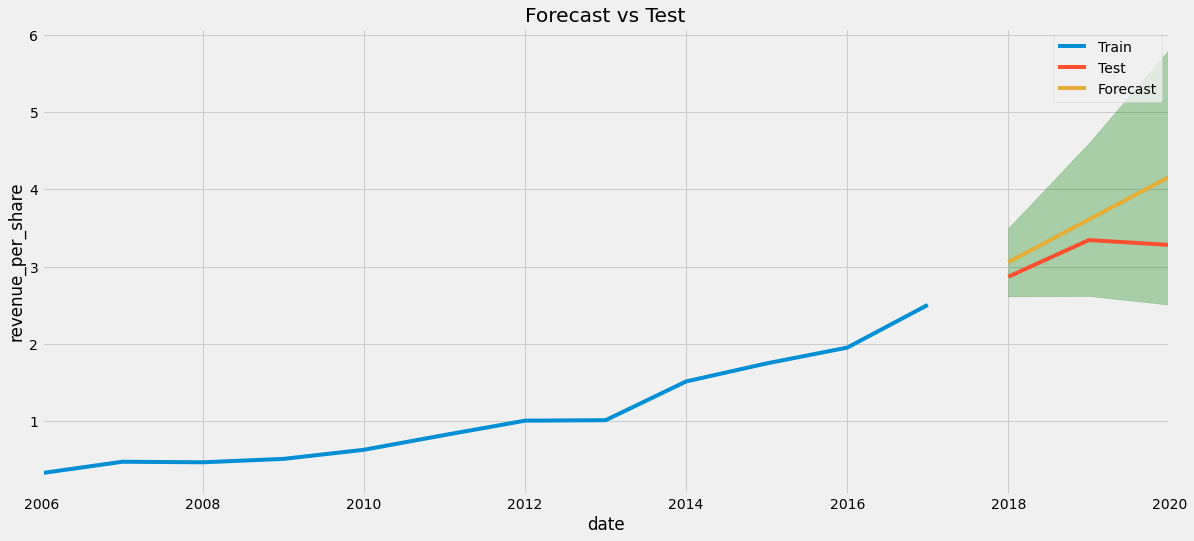

In [ ]:
#create and evaluate auto model
auto_model = create_eval_model(df=df_model_ts_20212, 
                                            ts_col='revenue_per_share', 
                                            test_size=3, 
                                            auto=True)

                               SARIMAX Results                                
Dep. Variable:      revenue_per_share   No. Observations:                   12
Model:               SARIMAX(1, 1, 0)   Log Likelihood                   1.125
Date:                Sun, 20 Jun 2021   AIC                              1.749
Time:                        16:53:23   BIC                              2.545
Sample:                    12-31-2006   HQIC                             1.248
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6659      0.462      1.441      0.150      -0.240       1.571
sigma2         0.0452      0.018      2.560      0.010       0.011       0.080
Ljung-Box (L1) (Q):                   2.23   Jarque-

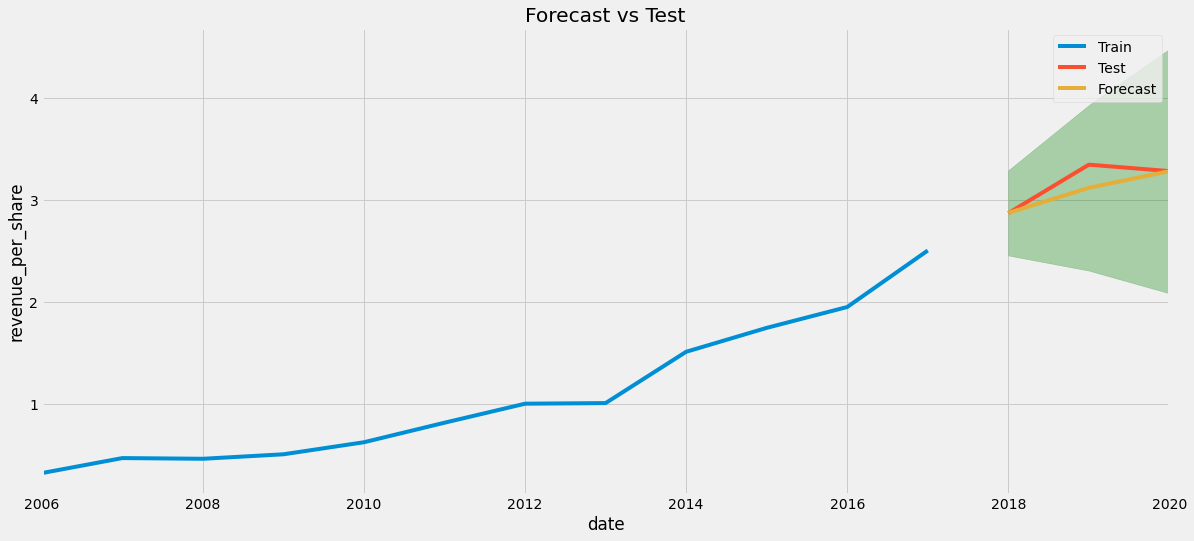

In [ ]:
#create and evaluate manual model
user_model, train, test, user_model_ts = create_eval_model(df=df_model_ts_20212, 
                                            ts_col='revenue_per_share', 
                                            test_size=3, 
                                            auto=False, order=(1,1,0))

> **OBSERVATIONS**
> - The auto-arima model suggested an ARIMA (0,2,0) which gave a MSE of 0.54 with a test size of 3 years. I manually created an ARIMA (1,1,0) which gave a MSE of 0.13 with a test size of 3 years. These are reasonably good MSE's considering the mean revenue per share

> **ACTIONS**
> - I will forecast using the ARIMA (1,1,0) model because it performed better and looks to be more conservative (not as steep of a positive slope)

### Model Forecast

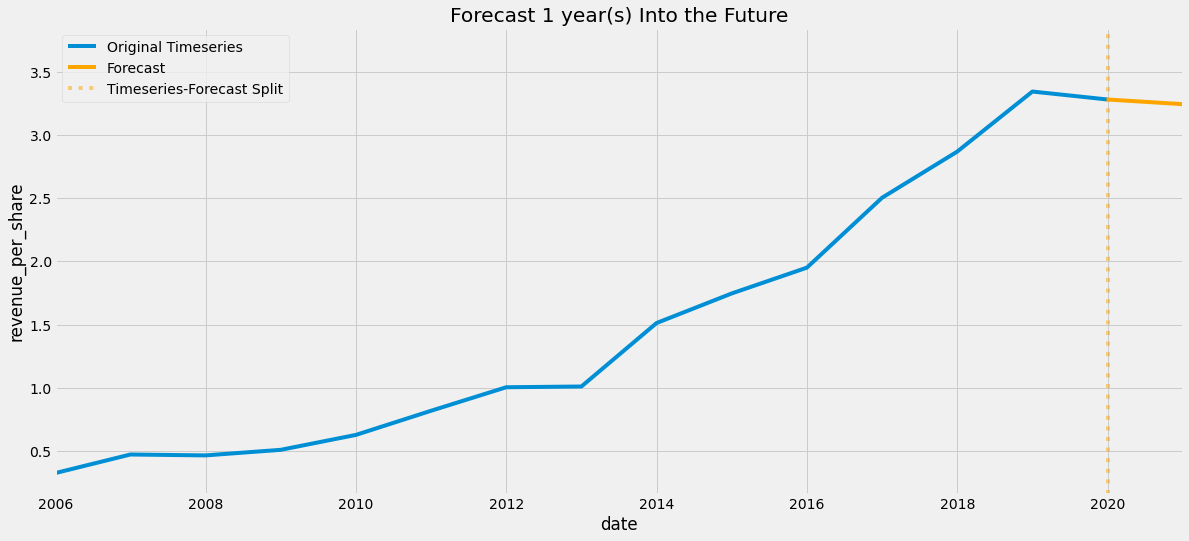



The percent change 1 year(s) into the future is -1.13%


In [ ]:
#forecast 1 year into the future and save the percent change
percent_change_20212 = forecast(df_model_ts_20212, ts_col='revenue_per_share', 
                                best_model_ts=user_model_ts, forecast_len=0);

> **OBSERVATIONS**
> - The model forecasts a 3.31% increase in reveneue per share between 2020 and 2021

## Model Symbol ID 6560

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
2008-12-31,6560,11.554,Canterbury Park Holding Corp,Gambling,Nasdaq Global Market,Consumer Cyclical,US,CPHC
2009-12-31,6560,10.001,Canterbury Park Holding Corp,Gambling,Nasdaq Global Market,Consumer Cyclical,US,CPHC
2010-12-31,6560,9.886000000000001,Canterbury Park Holding Corp,Gambling,Nasdaq Global Market,Consumer Cyclical,US,CPHC
2011-12-31,6560,9.936,Canterbury Park Holding Corp,Gambling,Nasdaq Global Market,Consumer Cyclical,US,CPHC
2012-12-31,6560,11.005,Canterbury Park Holding Corp,Gambling,Nasdaq Global Market,Consumer Cyclical,US,CPHC
2013-12-31,6560,11.222999999999999,Canterbury Park Holding Corp,Gambling,Nasdaq Global Market,Consumer Cyclical,US,CPHC
2014-12-31,6560,11.594000000000001,Canterbury Park Holding Corp,Gambling,Nasdaq Global Market,Consumer Cyclical,US,CPHC
2015-12-31,6560,12.362,Canterbury Park Holding Corp,Gambling,Nasdaq Global Market,Consumer Cyclical,US,CPHC
2016-12-31,6560,12.237,Canterbury Park Holding Corp,Gambling,Nasdaq Global Market,Consumer Cyclical,US,CPHC


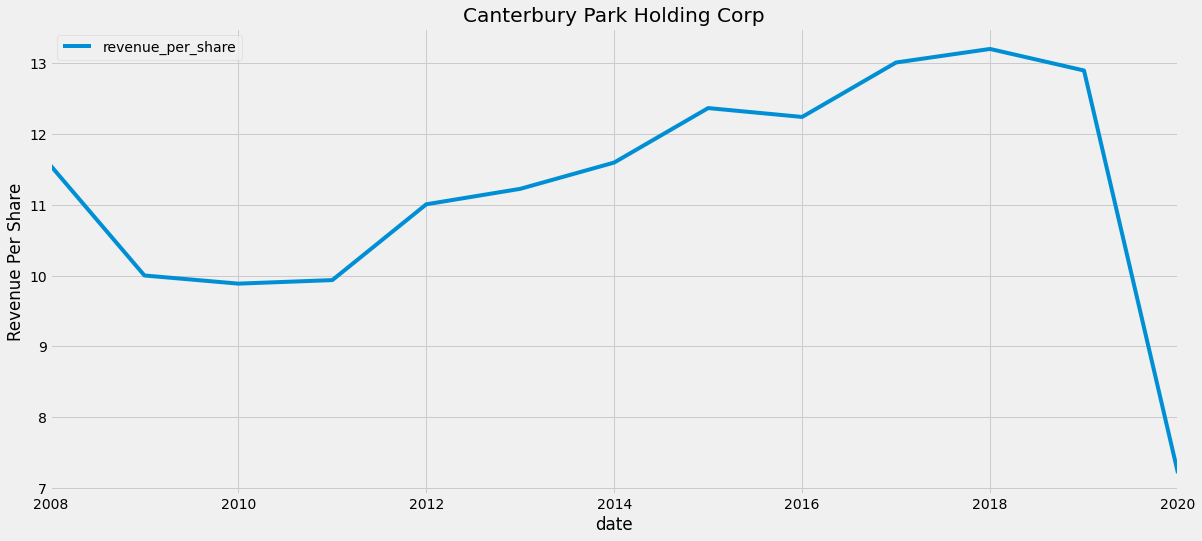

In [ ]:
#create dataframe and plot
df_model_ts_6560 = timeseries_creation(df_model_ts, '6560')

### Seasonality & Stationarity

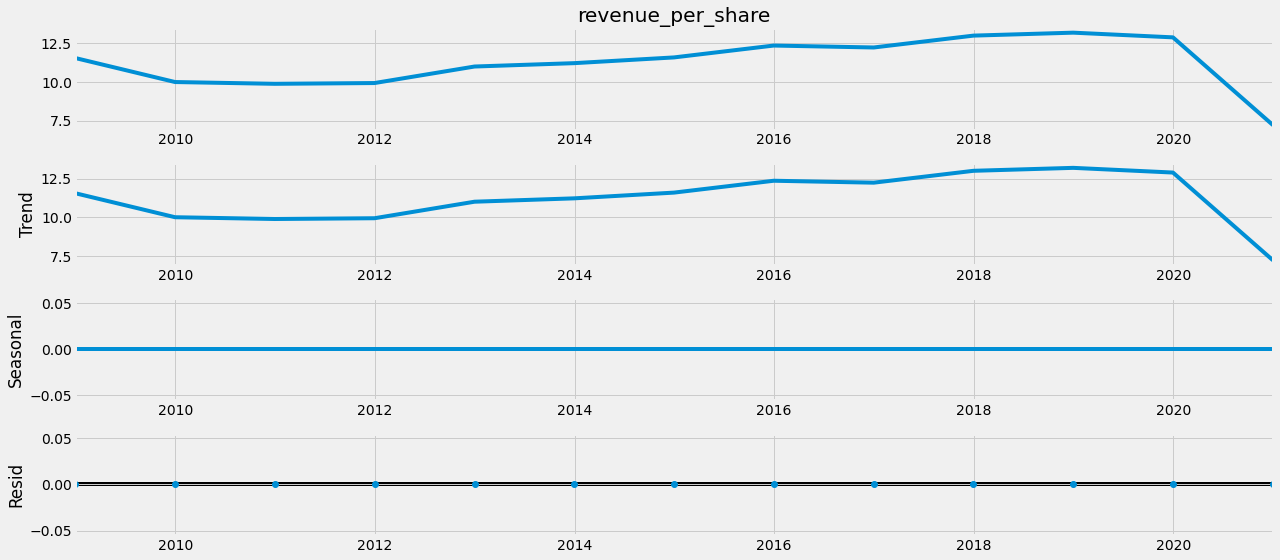

Augmented Dickey-Fuller Test Results
ADF test statistic   -0.8038771660518964
p-value               0.8179805255593915
# lags used                          3.0
# observations                       9.0


The data is not stationary


In [ ]:
#check for seasonality and stationarity
seasonality_stationarity_check(df_model_ts_6560['revenue_per_share'])

### Model Creation & Evaluation

> **OBSERVATIONS**
> - The best model from auto-arima is a ARIMA with order (2,0,1)

> **ACTIONS**
> - Create and evaluate an ARIMA (2,0,1) model

                               SARIMAX Results                                
Dep. Variable:      revenue_per_share   No. Observations:                   10
Model:               SARIMAX(3, 0, 0)   Log Likelihood                 -13.717
Date:                Sun, 20 Jun 2021   AIC                             35.434
Time:                        16:53:28   BIC                             36.644
Sample:                    12-31-2008   HQIC                            34.106
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1385      1.087      1.047      0.295      -0.992       3.269
ar.L2          0.1007      1.349      0.075      0.941      -2.543       2.744
ar.L3         -0.2416      0.553     -0.437      0.6

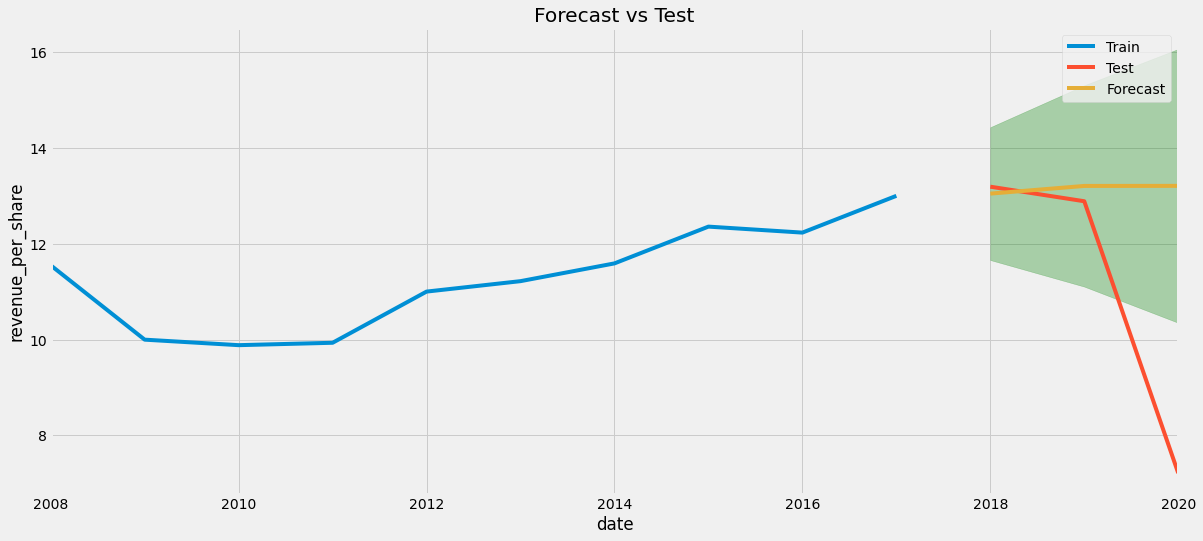

In [ ]:
#create and evaluate auto model
auto_model = create_eval_model(df=df_model_ts_6560, 
                                            ts_col='revenue_per_share', 
                                            auto=True, test_size=3)

                               SARIMAX Results                                
Dep. Variable:      revenue_per_share   No. Observations:                   10
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  -9.933
Date:                Sun, 20 Jun 2021   AIC                             23.865
Time:                        16:53:28   BIC                             24.259
Sample:                    12-31-2008   HQIC                            23.014
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2519      1.019      0.247      0.805      -1.746       2.249
sigma2         0.5284      0.375      1.408      0.159      -0.207       1.264
Ljung-Box (L1) (Q):                   0.55   Jarque-

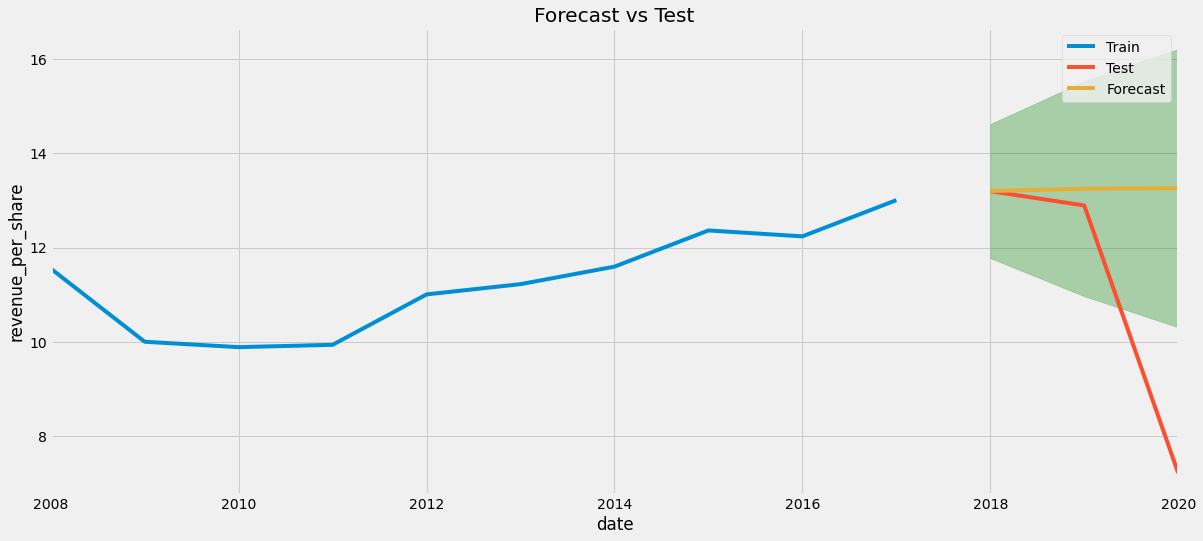

In [ ]:
#create and evaluate manual model
user_model, train, test, user_model_ts = create_eval_model(df=df_model_ts_6560, 
                                            ts_col='revenue_per_share', 
                                            auto=False, test_size=3, order=(1,1,0))

> **OBSERVATIONS**
> - The auto arima model suggested an ARIMA (1,0,0) with a MSE of 3.3. I manually created an ARIMA (1,1,0) model to use differencing for stationarity which gave a MSE of 3.5. The MSE's are quite large, mostly due to the large decrease in revenue per share in 2020. I believe the manually created model is best as it keeps a slight positive trend which I believe better reflects the majority of the history of this stock

> **ACTIONS**
> - Forecast using the ARIMA (1,0,0) model

### Model Forecast

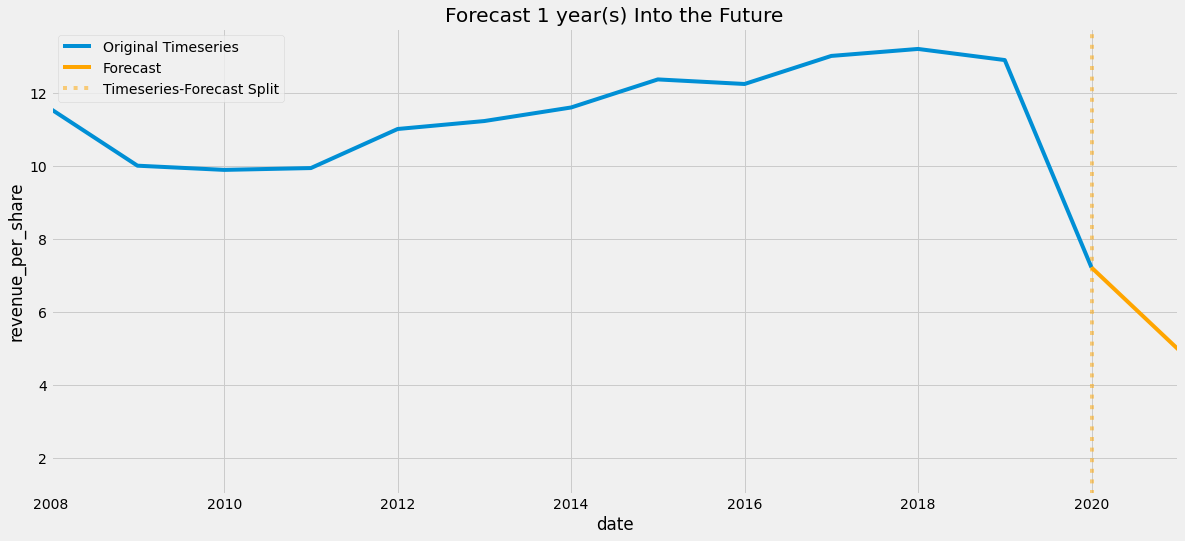



The percent change 1 year(s) into the future is -31.07%


In [ ]:
#forecast 1 year into the future
percent_change_6560 = forecast(df_model_ts_6560, ts_col='revenue_per_share', 
                               best_model_ts=user_model_ts, forecast_len=0);

> **OBSERVATIONS**
> - The model forecasts a .02% increase in revenue per share between 2020 and 2021.

## Model Symbol ID 3918

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
1986-09-30,3918,2.78,American Realty Investors Inc,Real Estate Development,New York Stock Exchange,Real Estate,US,ARL
1986-12-31,3918,0.746,American Realty Investors Inc,Real Estate Development,New York Stock Exchange,Real Estate,US,ARL
1987-12-31,3918,2.281,American Realty Investors Inc,Real Estate Development,New York Stock Exchange,Real Estate,US,ARL
1988-12-31,3918,1.807,American Realty Investors Inc,Real Estate Development,New York Stock Exchange,Real Estate,US,ARL
1989-12-31,3918,1.419,American Realty Investors Inc,Real Estate Development,New York Stock Exchange,Real Estate,US,ARL
1990-12-31,3918,1.8119999999999998,American Realty Investors Inc,Real Estate Development,New York Stock Exchange,Real Estate,US,ARL
1991-12-31,3918,1.482,American Realty Investors Inc,Real Estate Development,New York Stock Exchange,Real Estate,US,ARL
1992-12-31,3918,0.825,American Realty Investors Inc,Real Estate Development,New York Stock Exchange,Real Estate,US,ARL
1993-12-31,3918,1.107,American Realty Investors Inc,Real Estate Development,New York Stock Exchange,Real Estate,US,ARL


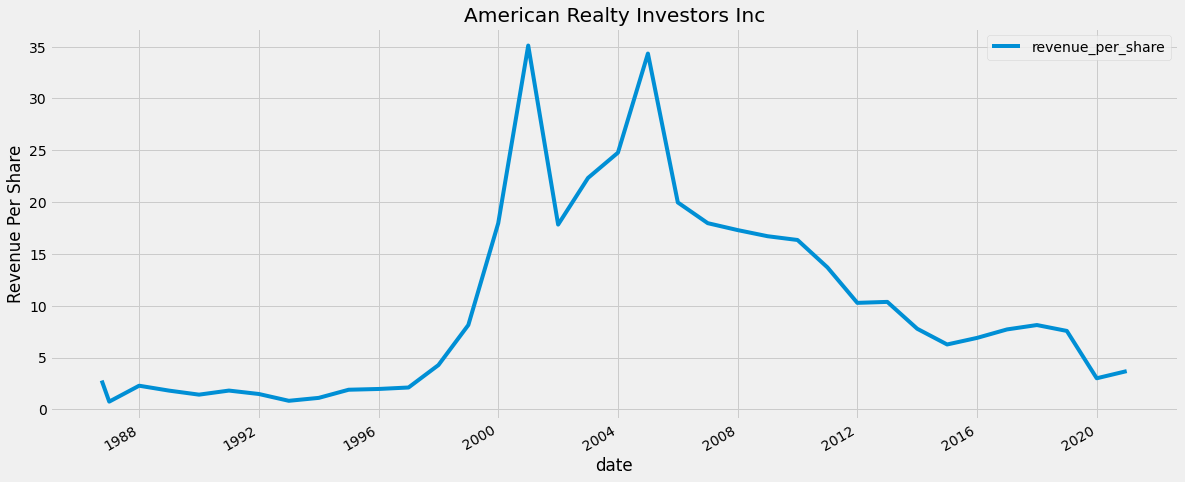

In [ ]:
#create dataframe and plot
df_model_ts_3918 = timeseries_creation(df_model_ts, '3918');
#remove first row as it is a second value for year 1986
df_model_ts_3918 = df_model_ts_3918.iloc[1:]

### Seasonality & Stationarity

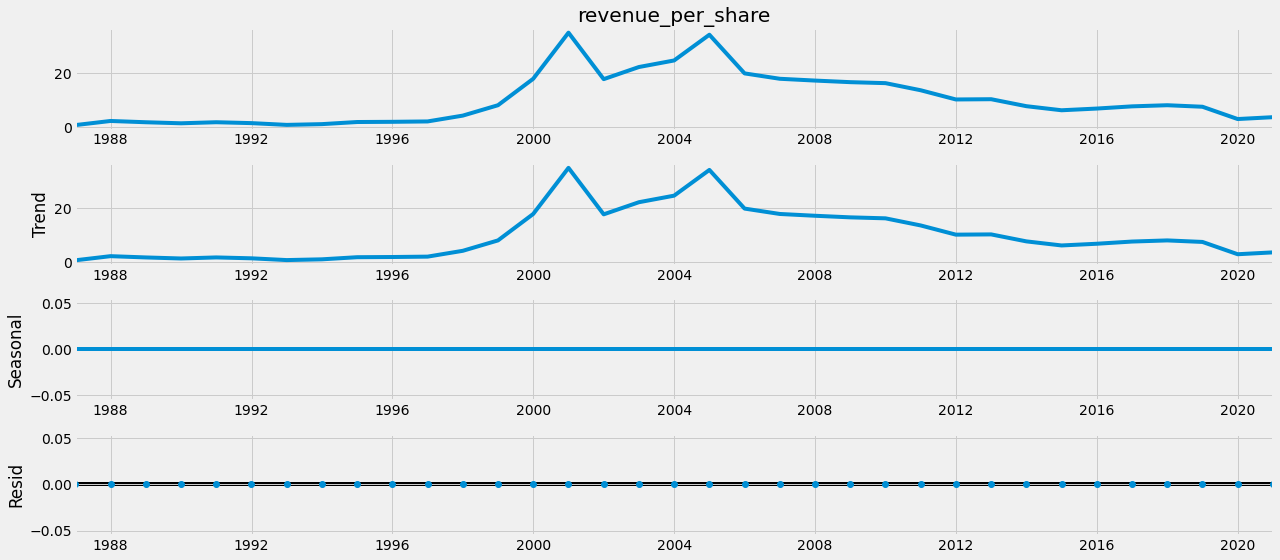

Augmented Dickey-Fuller Test Results
ADF test statistic   -1.8994037832642725
p-value              0.33234164185863524
# lags used                          0.0
# observations                      34.0


The data is not stationary


In [ ]:
#check for seasonality and stationarity
seasonality_stationarity_check(df_model_ts_3918['revenue_per_share'])

> **OBSERVATIONS**
> - The data is not stationary and also shows no seasonality

> **ACTIONS**
> - Will manually create a model with differencing if auto-arima doesn't

### Model Creation & Evaluation

                               SARIMAX Results                                
Dep. Variable:      revenue_per_share   No. Observations:                   31
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -99.171
Date:                Sun, 20 Jun 2021   AIC                            202.343
Time:                        16:53:30   BIC                            205.211
Sample:                    12-31-1986   HQIC                           203.278
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8970      0.042     21.144      0.000       0.814       0.980
sigma2        33.3682      5.291      6.307      0.000      22.998      43.738
Ljung-Box (L1) (Q):                   1.17   Jarque-

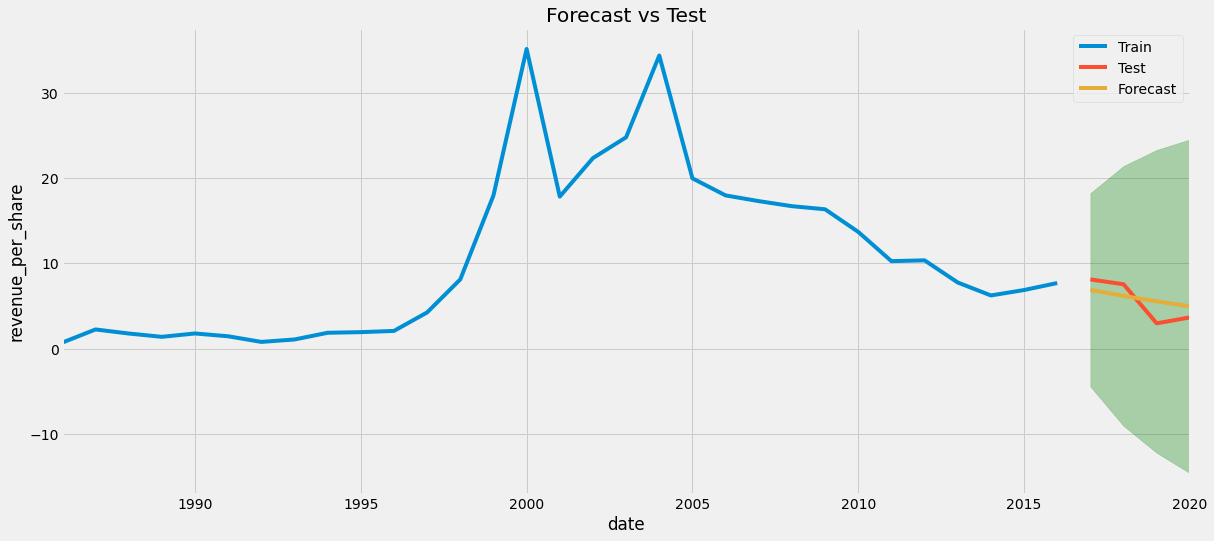

In [ ]:
#create and evaluate auto model
auto_model, train, test, auto_model_ts = create_eval_model(df=df_model_ts_3918, 
                                            ts_col='revenue_per_share', 
                                            auto=True, test_size=4)

                               SARIMAX Results                                
Dep. Variable:      revenue_per_share   No. Observations:                   30
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -92.863
Date:                Sun, 20 Jun 2021   AIC                            189.726
Time:                        16:53:31   BIC                            192.460
Sample:                    12-31-1986   HQIC                           190.582
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1988      0.105     -1.891      0.059      -0.405       0.007
sigma2        35.3414      5.878      6.012      0.000      23.820      46.863
Ljung-Box (L1) (Q):                   0.02   Jarque-

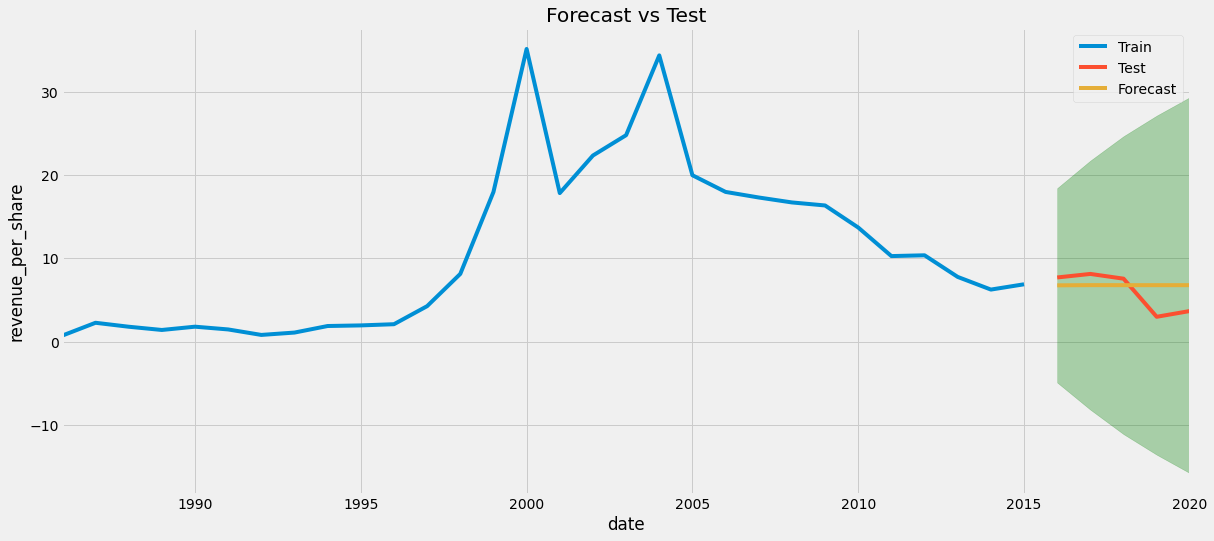

In [ ]:
#create and evaluate manual model
user_model = create_eval_model(df=df_model_ts_3918, 
                                            ts_col='revenue_per_share', 
                                            auto=False, order=(1,1,0), test_size=5)

> **OBSERVATIONS**
> - The auto-arima model suggested a ARIMA (1,0,0) with a MSE of 1.71 and I manually created an ARIMA (1,1,0) to take advantage of differencing and saw a MSE of 2.34. I believe the auto-arima model looks more accurate.

> **ACTIONS**
> - I will forecast using the auto model

### Model Forecast

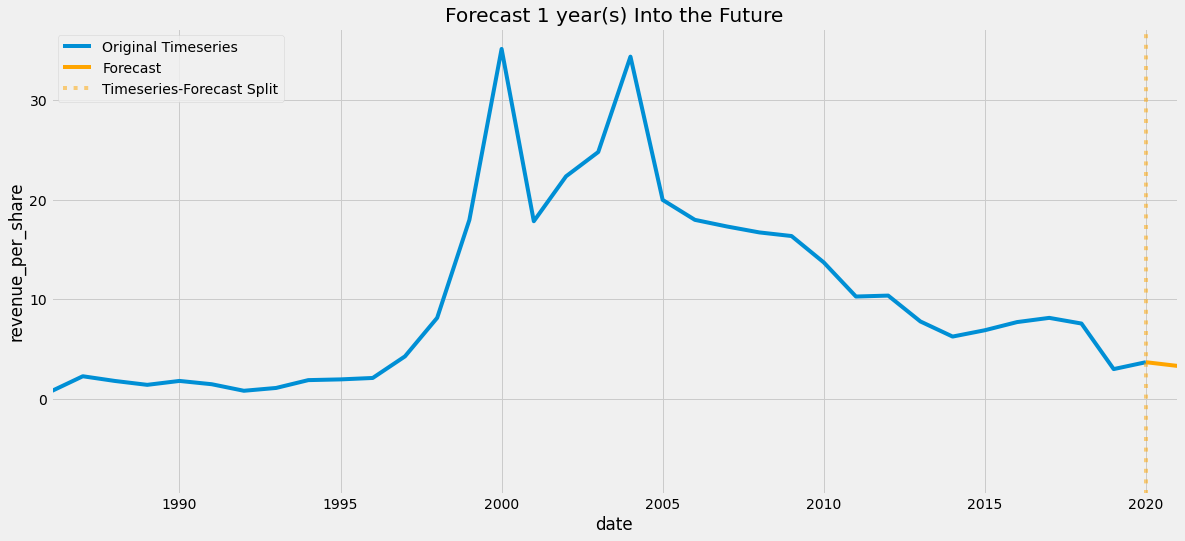



The percent change 1 year(s) into the future is -10.28%


In [ ]:
#forecast 1 year into the future and save percent change
percent_change_3918 = forecast(df_model_ts_3918, ts_col='revenue_per_share', 
                               best_model_ts=auto_model_ts, forecast_len=0)

> **OBSERVATIONS**
> - The model forecasts a 10.3% decrease in revenue per share between 2020 and 2021.

## Model Symbol ID 13703

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
1999-12-31,13703,1.3090000000000002,MyHammer Holding AG,Media & Entertainment,XETRA,Media,DE,MYRK.DE
2000-12-31,13703,3.6830000000000003,MyHammer Holding AG,Media & Entertainment,XETRA,Media,DE,MYRK.DE
2001-12-31,13703,2.8680000000000003,MyHammer Holding AG,Media & Entertainment,XETRA,Media,DE,MYRK.DE
2002-12-31,13703,1.1159999999999999,MyHammer Holding AG,Media & Entertainment,XETRA,Media,DE,MYRK.DE
2003-12-31,13703,1.16,MyHammer Holding AG,Media & Entertainment,XETRA,Media,DE,MYRK.DE
2004-12-31,13703,1.203,MyHammer Holding AG,Media & Entertainment,XETRA,Media,DE,MYRK.DE
2005-12-31,13703,1.242,MyHammer Holding AG,Media & Entertainment,XETRA,Media,DE,MYRK.DE
2006-12-31,13703,1.324,MyHammer Holding AG,Media & Entertainment,XETRA,Media,DE,MYRK.DE
2007-12-31,13703,1.807,MyHammer Holding AG,Media & Entertainment,XETRA,Media,DE,MYRK.DE


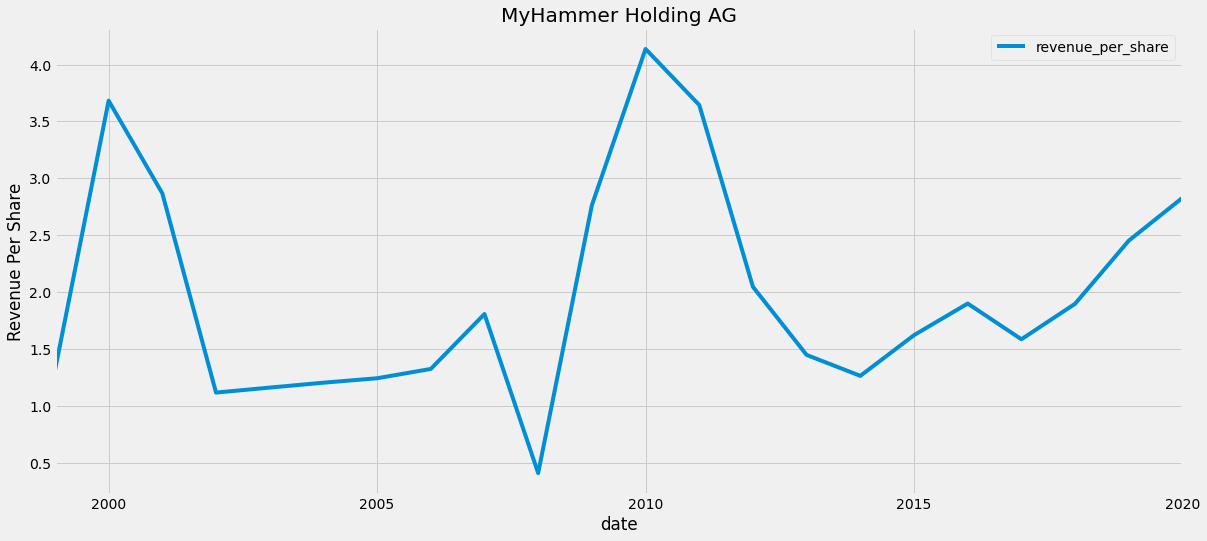

In [ ]:
#create dataframe and plot
df_model_ts_13703 = timeseries_creation(df_model_ts, '13703');

### Seasonality & Stationarity

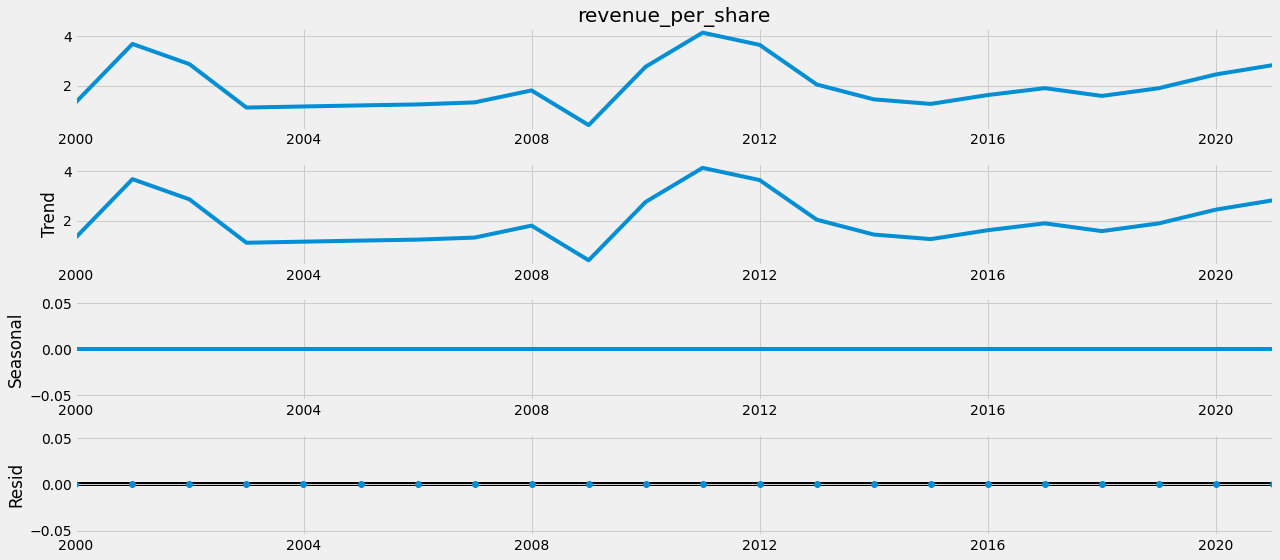

Augmented Dickey-Fuller Test Results
ADF test statistic       -18.66591240421261
p-value              2.0461629038734347e-30
# lags used                             9.0
# observations                         12.0


The data is stationary


In [ ]:
#check for seasonality and stationarity
seasonality_stationarity_check(df_model_ts_13703['revenue_per_share'])

### Model Creation & Evaluation

                               SARIMAX Results                                
Dep. Variable:      revenue_per_share   No. Observations:                   17
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 -26.632
Date:                Sun, 20 Jun 2021   AIC                             59.265
Time:                        16:53:34   BIC                             61.764
Sample:                    12-31-1999   HQIC                            59.513
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9348      0.239      3.908      0.000       0.466       1.404
ar.L2         -0.1130      0.248     -0.455      0.649      -0.600       0.374
sigma2         1.2485      0.424      2.942      0.0

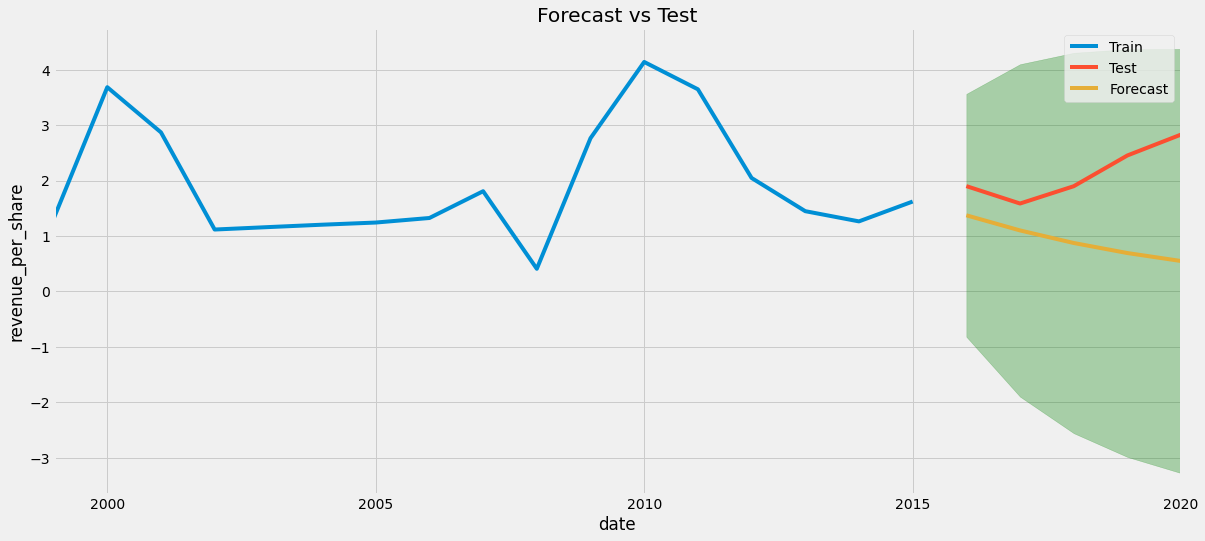

In [ ]:
#create and evaluate auto model
auto_model = create_eval_model(df=df_model_ts_13703, 
                                            ts_col='revenue_per_share', 
                                            auto=True, test_size=5)

                               SARIMAX Results                                
Dep. Variable:      revenue_per_share   No. Observations:                   20
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 -32.718
Date:                Sun, 20 Jun 2021   AIC                             67.436
Time:                        16:53:34   BIC                             68.326
Sample:                    12-31-1999   HQIC                            67.559
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.2199      0.620      3.583      0.000       1.006       3.434
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):                 1.28
Prob(Q):                              0.41   Pr

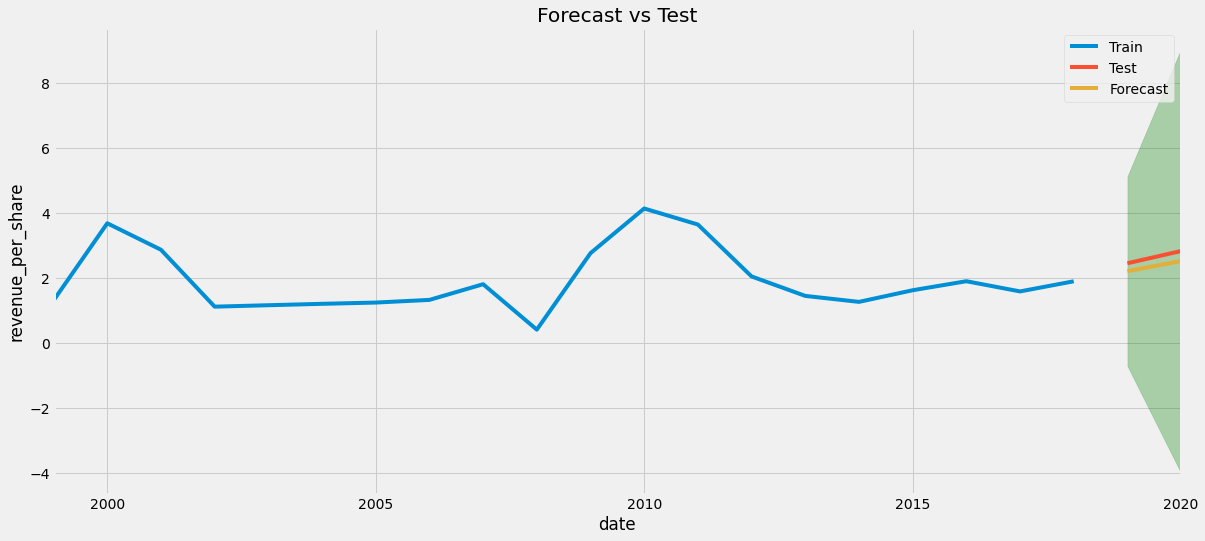

In [ ]:
#create and evaluate manual model
user_model, train, test, user_model_ts = create_eval_model(df=df_model_ts_13703, 
                                            ts_col='revenue_per_share', 
                                            auto=False, order=(0,2,0), test_size=2)

> **OBSERVATIONS**
> - The auto-arima model did not give good results with any train-test split. The manual ARIMA ((0,2,0) with a test size of 2 had a MSE of 0.28 and looks to have a good general trend.

> **ACTIONS**
> - Forecast using the user model

### Model Forecast

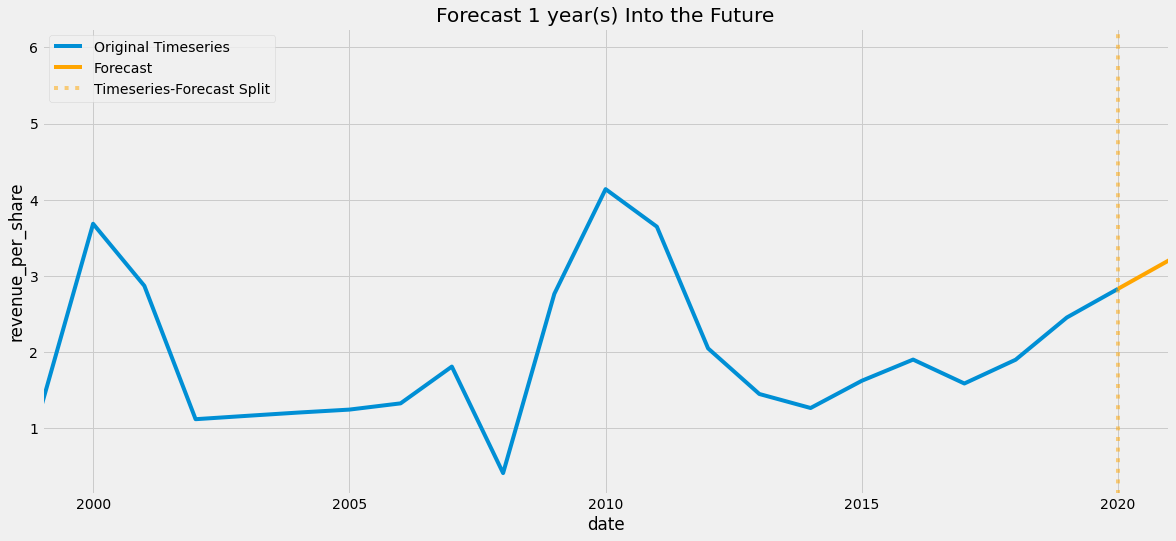



The percent change 1 year(s) into the future is 13.33%


In [ ]:
#forecast 1 year into the future and save percent change
percent_change_13703 = forecast(df_model_ts_13703, ts_col='revenue_per_share', 
                               best_model_ts=user_model_ts, forecast_len=0)

> **OBSERVATIONS**
> - The model forecasts a 12.38% increase in revenue per share between 2020 and 2021.

## Model Symbol ID 11068

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
1993-12-31,11068,0.721,Innodata Inc,Information Technology Services,Nasdaq Global Market,Technology,US,INOD
1994-12-31,11068,0.8109999999999999,Innodata Inc,Information Technology Services,Nasdaq Global Market,Technology,US,INOD
1995-12-31,11068,1.111,Innodata Inc,Information Technology Services,Nasdaq Global Market,Technology,US,INOD
1996-12-31,11068,1.111,Innodata Inc,Information Technology Services,Nasdaq Global Market,Technology,US,INOD
1997-12-31,11068,1.12,Innodata Inc,Information Technology Services,Nasdaq Global Market,Technology,US,INOD
1998-12-31,11068,1.079,Innodata Inc,Information Technology Services,Nasdaq Global Market,Technology,US,INOD
1999-12-31,11068,1.473,Innodata Inc,Information Technology Services,Nasdaq Global Market,Technology,US,INOD
2000-12-31,11068,2.513,Innodata Inc,Information Technology Services,Nasdaq Global Market,Technology,US,INOD
2001-12-31,11068,2.594,Innodata Inc,Information Technology Services,Nasdaq Global Market,Technology,US,INOD


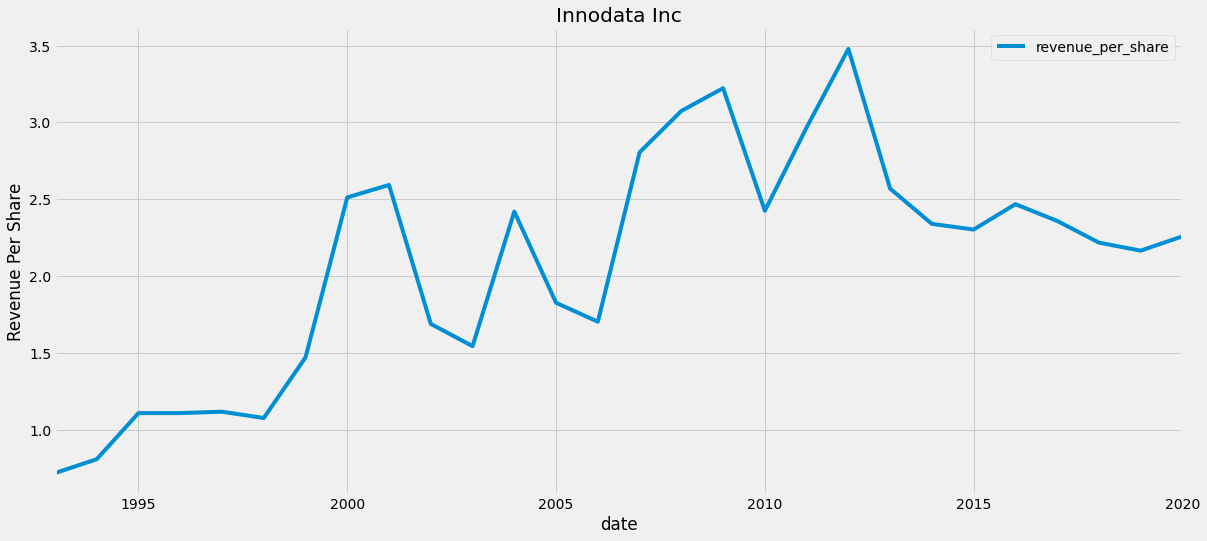

In [ ]:
#create dataframe and plot
df_model_ts_11068 = timeseries_creation(df_model_ts, '11068');

### Seasonality & Stationarity

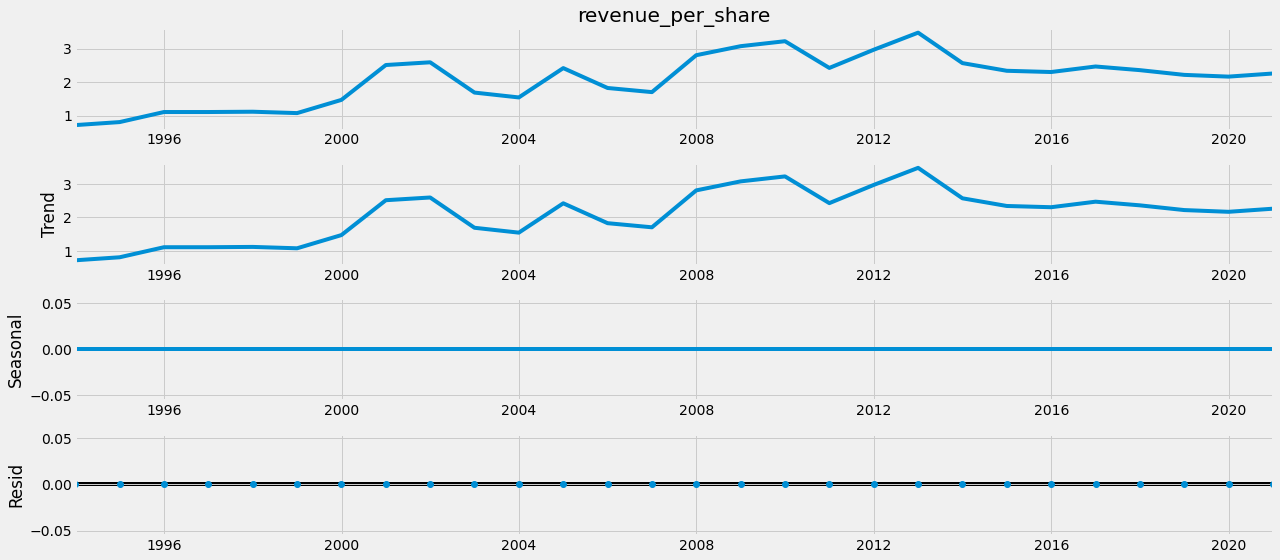

Augmented Dickey-Fuller Test Results
ADF test statistic   -2.3567663412059665
p-value               0.1543122898211578
# lags used                          0.0
# observations                      27.0


The data is not stationary


In [ ]:
#check for seasonality and stationarity
seasonality_stationarity_check(df_model_ts_11068['revenue_per_share'])

> **OBSERVATIONS**
> - The data is not stationary and has no seasonality

### Model Creation & Evaluation

                               SARIMAX Results                                
Dep. Variable:      revenue_per_share   No. Observations:                   23
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -18.115
Date:                Sun, 20 Jun 2021   AIC                             38.230
Time:                        16:53:37   BIC                             39.321
Sample:                    12-31-1993   HQIC                            38.487
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3039      0.102      2.971      0.003       0.103       0.504
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.73   Pr

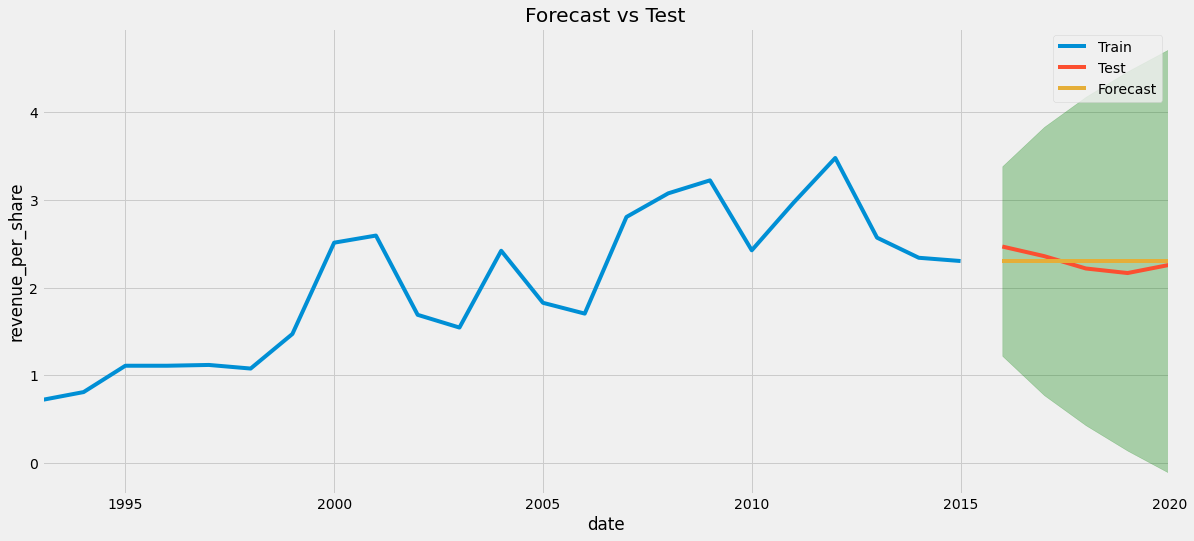

In [ ]:
#create and evaluate auto model
auto_model = create_eval_model(df=df_model_ts_11068, 
                                            ts_col='revenue_per_share', 
                                            auto=True, test_size=5)

                               SARIMAX Results                                
Dep. Variable:      revenue_per_share   No. Observations:                   23
Model:               SARIMAX(1, 2, 1)   Log Likelihood                 -19.140
Date:                Sun, 20 Jun 2021   AIC                             44.280
Time:                        16:53:37   BIC                             47.414
Sample:                    12-31-1993   HQIC                            44.960
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0224      0.348     -0.064      0.949      -0.704       0.659
ma.L1         -0.9981     28.694     -0.035      0.972     -57.238      55.241
sigma2         0.3127      8.967      0.035      0.9

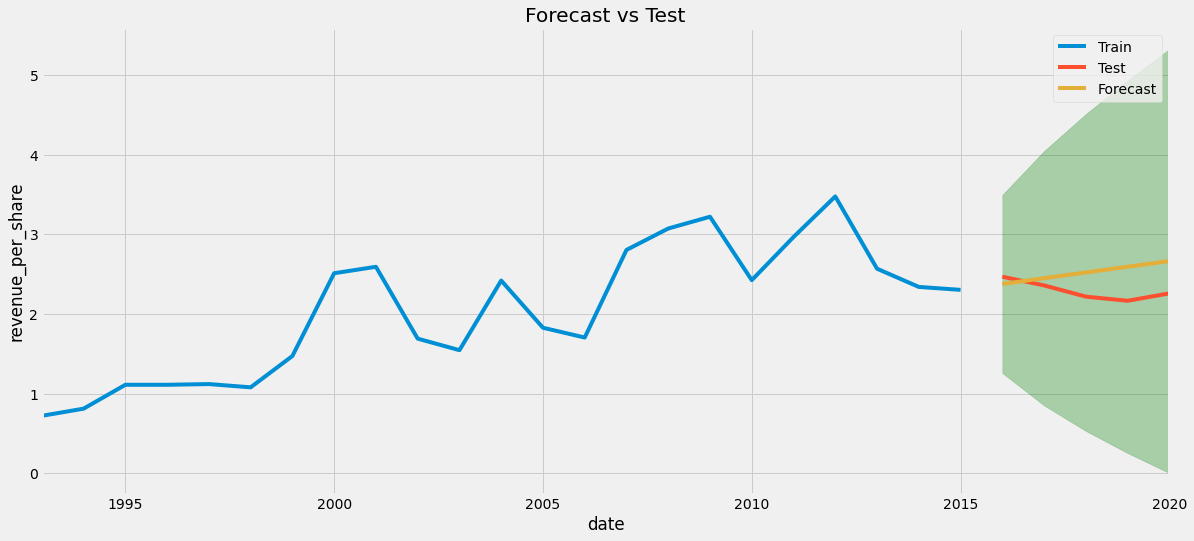

In [ ]:
#create and evaluate auto model
user_model, train, test, user_model_ts = create_eval_model(df=df_model_ts_11068, 
                                            ts_col='revenue_per_share', 
                                            auto=False, order=(1,2,1), test_size=5)

> **OBSERVATIONS**
> - The auto-arima model ARIMA (0,1,0) has a MSE of .11 with a test size of 5 years and the manual model ARIMA (1,2,1) has a MSE of 0.3 with a test size of 5 years. The manual does seem to capture the overall upwards trend better than the auto-arima model

> **ACTIONS**
> - Forecast with the manual ARIMA (1,2,1)

### Model Forecast

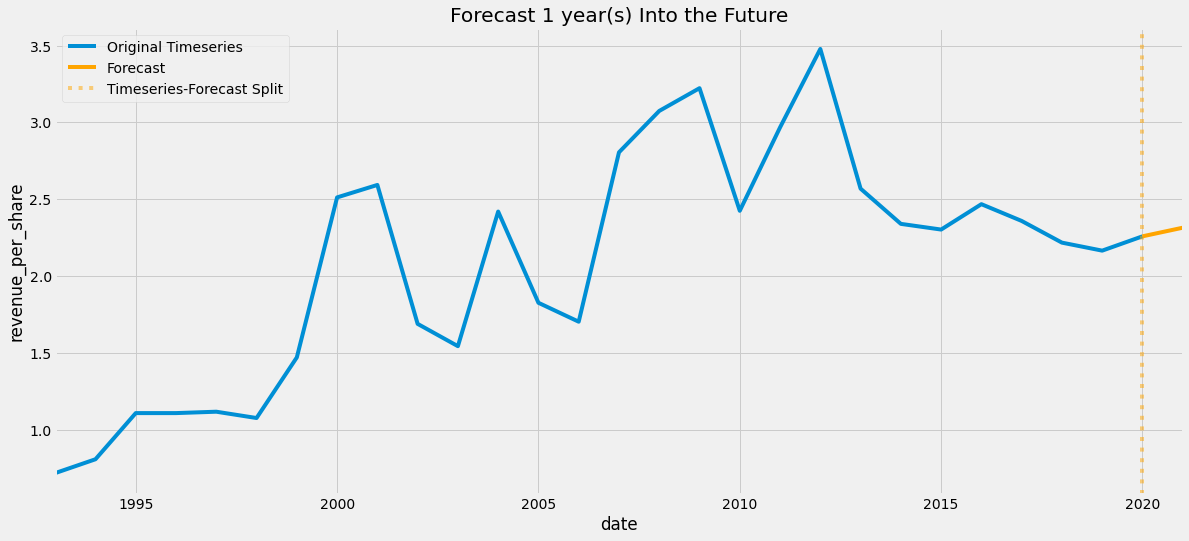



The percent change 1 year(s) into the future is 2.48%


In [ ]:
#forecast 1 year into the future and save percent change
percent_change_11068 = forecast(df_model_ts_11068, ts_col='revenue_per_share', 
                               best_model_ts=user_model_ts, forecast_len=0)

## Model Symbol ID 13895

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
1988-12-31,13895,38.944,New England Realty Associates LP,Real Estate Services,NYSE American,Real Estate,US,NEN
1989-12-31,13895,45.556000000000004,New England Realty Associates LP,Real Estate Services,NYSE American,Real Estate,US,NEN
1990-12-31,13895,46.722,New England Realty Associates LP,Real Estate Services,NYSE American,Real Estate,US,NEN
1991-12-31,13895,46.778,New England Realty Associates LP,Real Estate Services,NYSE American,Real Estate,US,NEN
1992-12-31,13895,46.111000000000004,New England Realty Associates LP,Real Estate Services,NYSE American,Real Estate,US,NEN
1993-12-31,13895,46.778,New England Realty Associates LP,Real Estate Services,NYSE American,Real Estate,US,NEN
1994-12-31,13895,47.278,New England Realty Associates LP,Real Estate Services,NYSE American,Real Estate,US,NEN
1995-12-31,13895,0.774,New England Realty Associates LP,Real Estate Services,NYSE American,Real Estate,US,NEN
1996-12-31,13895,1.036,New England Realty Associates LP,Real Estate Services,NYSE American,Real Estate,US,NEN


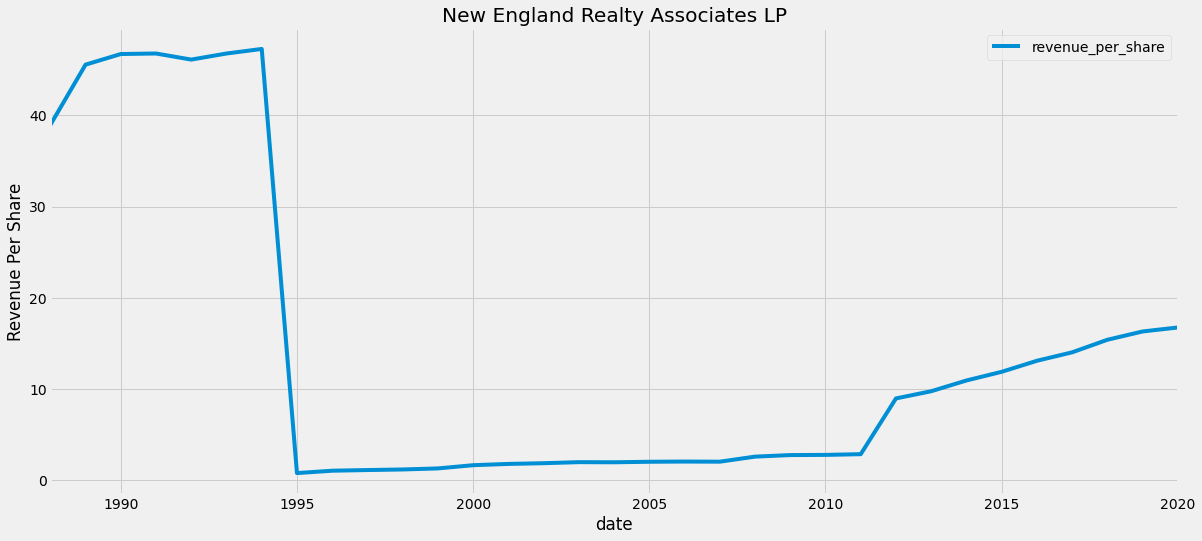

In [ ]:
#create dataframe and plot
df_model_ts_13895 = timeseries_creation(df_model_ts, '13895');

### Seasonality & Stationarity

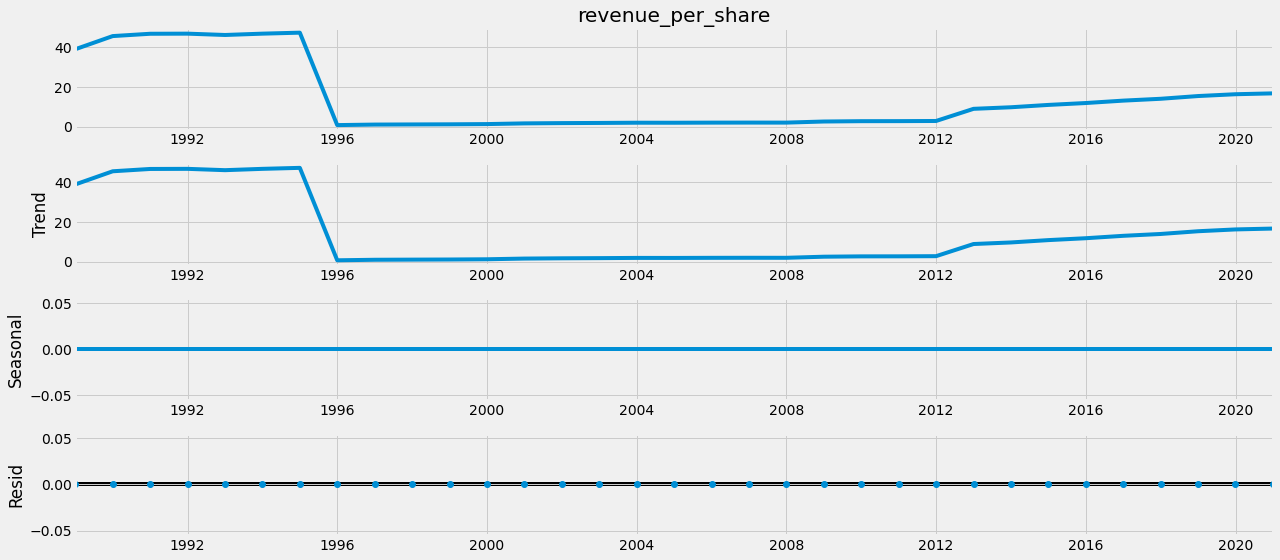

Augmented Dickey-Fuller Test Results
ADF test statistic   -1.7851782932546811
p-value              0.38784469035963953
# lags used                          0.0
# observations                      32.0


The data is not stationary


In [ ]:
#check for seasonality and stationarity
seasonality_stationarity_check(df_model_ts_13895['revenue_per_share'])

> **OBSERVATIONS**
> - The data is not stationary and has no seasonality

> **ACTIONS**
> - Evaluate differencing if the auto-arima model does not

### Model Creation & Evaluation

                               SARIMAX Results                                
Dep. Variable:      revenue_per_share   No. Observations:                   31
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -107.357
Date:                Sun, 20 Jun 2021   AIC                            216.714
Time:                        16:53:40   BIC                            218.115
Sample:                    12-31-1988   HQIC                           217.162
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        75.1329      5.316     14.134      0.000      64.714      85.551
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               796.91
Prob(Q):                              0.91   Pr

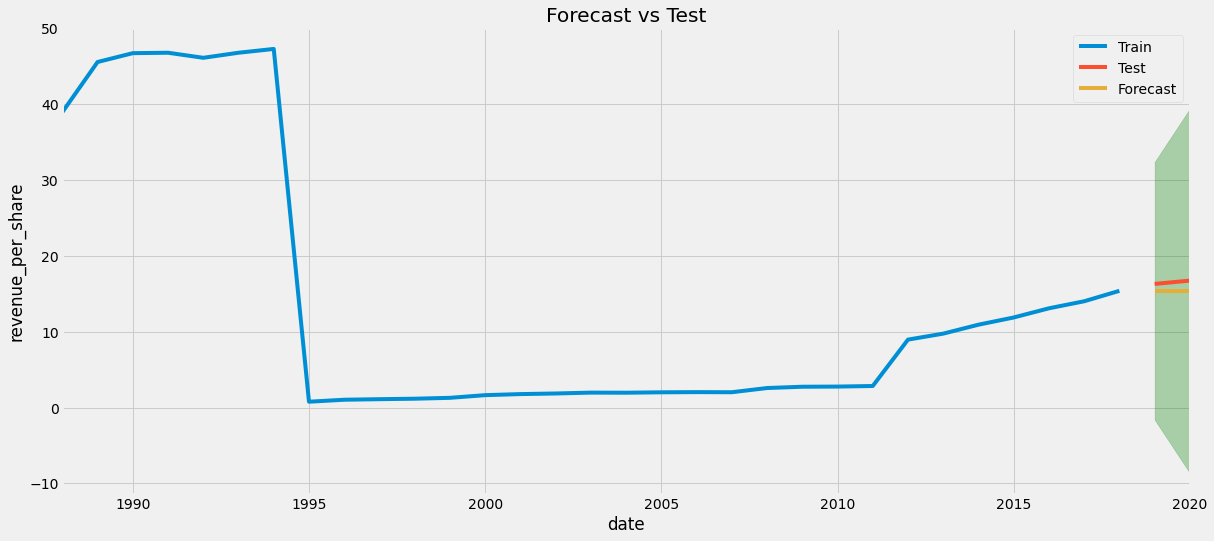

In [ ]:
#create and evaluate auto model
auto_model = create_eval_model(df=df_model_ts_13895, 
                                            ts_col='revenue_per_share', 
                                            auto=True, test_size=2)

                               SARIMAX Results                                
Dep. Variable:      revenue_per_share   No. Observations:                   30
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -106.992
Date:                Sun, 20 Jun 2021   AIC                            217.985
Time:                        16:53:40   BIC                            220.649
Sample:                    12-31-1988   HQIC                           218.799
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4819      0.078     -6.147      0.000      -0.636      -0.328
sigma2       120.9022     12.959      9.330      0.000      95.503     146.301
Ljung-Box (L1) (Q):                   1.01   Jarque-

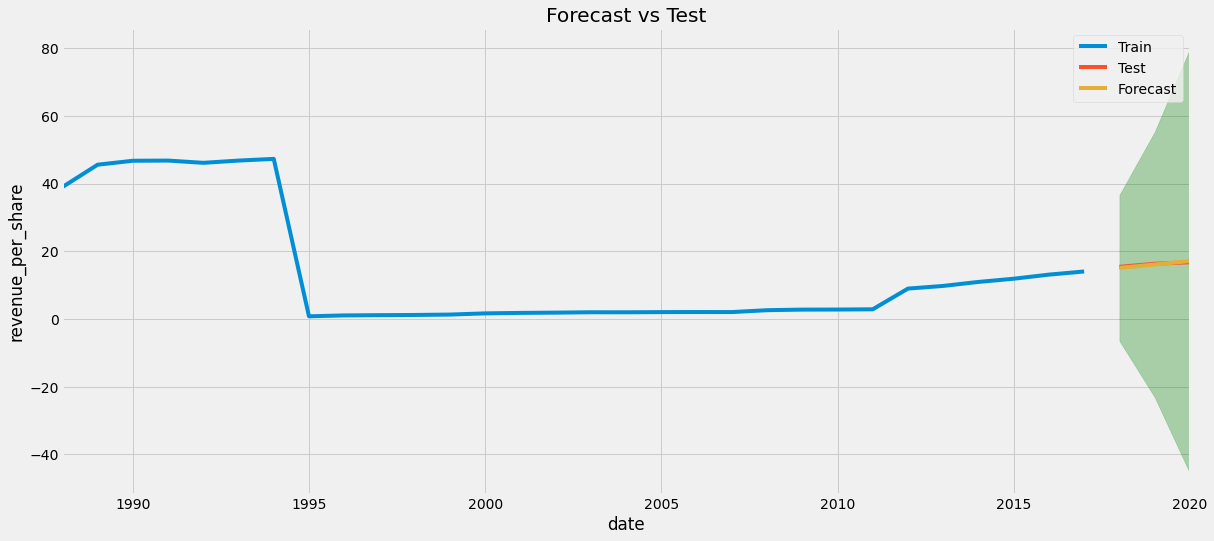

In [ ]:
#create and evaluate auto model
auto_model, train, test, user_model_ts = create_eval_model(df=df_model_ts_13895, 
                                            ts_col='revenue_per_share', 
                                            auto=False, order=(1,2,0), test_size=3)

> **OBSERVATIONS**
> - Auto-arima model ARIMA (0,1,0) has a MSE of 1.15 with a 2 year test size while the manual ARIMA (1,2,0) has a MSE of 0.31 with a 3 year test size.

> **ACTIONS**
> - Forecast using the manual ARIMA (0,2,0) model

### Model Forecast

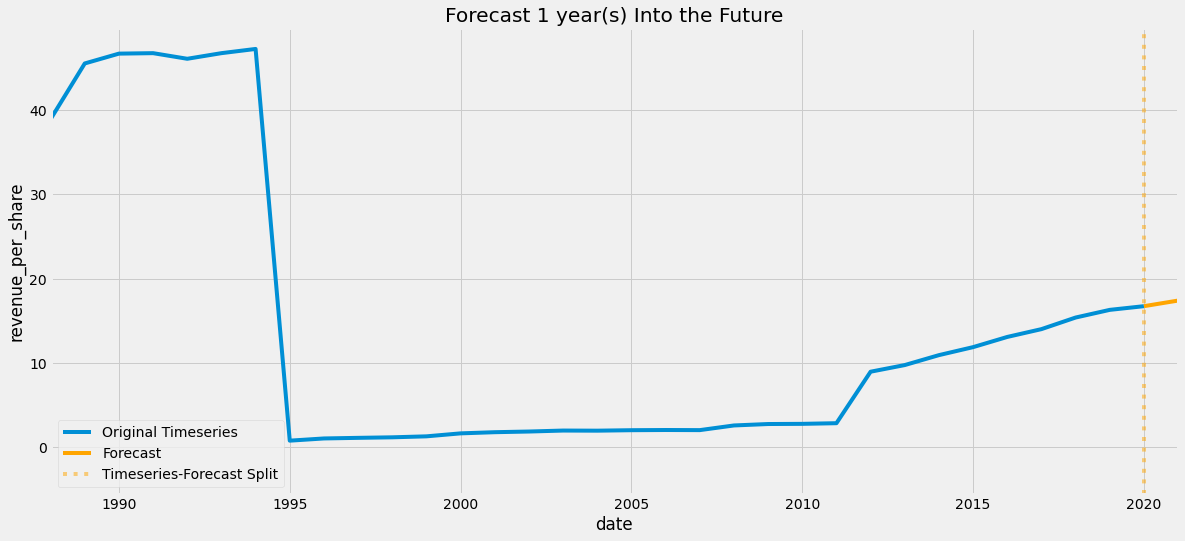



The percent change 1 year(s) into the future is 3.98%


In [ ]:
#forecast 1 year into the future and save percent change
percent_change_13895 = forecast(df_model_ts_13895, ts_col='revenue_per_share', 
                               best_model_ts=user_model_ts, forecast_len=0)

# DATA INTERPRETATION

In [ ]:
#create growth dataframe to rank top 10 value stocks
growth_list = [percent_change_6179,np.nan, percent_change_18476, percent_change_17611,
               percent_change_20212, percent_change_6560,percent_change_3918, 
               percent_change_13703, percent_change_11068, percent_change_13895]

growth_df = pd.DataFrame(growth_list, columns=['1_year_growth_percentage'], 
                         index=['6179', '9192','18476', '17611', '20211', '6560', 
                                '3918', '13703', '11068', '13895'])
growth_df['growth_rank'] = growth_df['1_year_growth_percentage'].rank(na_option='bottom', 
                                                                      ascending=False).astype(int)

#grab top 10 value stocks
df_top_10 = df_clean.loc[:9]
df_top_10.set_index(df_top_10['symbol_id'], inplace=True)
df_top_10.drop(columns='symbol_id', inplace=True)

#merge value and growth dataframes
df_top_10 = df_top_10.merge(growth_df, left_index=True, right_index=True)

#re-rank on both value and growth
df_top_10['total_rank'] = df_top_10['growth_rank'] + df_top_10['2020_value_ranking']
df_top_10.sort_values('total_rank', inplace=True)
df_top_10['final_rank'] = ['1', '1', '1' ,'2', '3', '3' ,'3', '4', '4']
df_top_10['1_year_growth_percentage']

6179     -5.91
18476      0.0
17611     1.02
13703    13.33
9192       nan
11068     2.48
13895     3.98
6560    -31.07
3918    -10.28
Name: 1_year_growth_percentage, dtype: float64

HIT Investments was interested in understanding how the top value stocks have grown over time which was the focus of this analysis. Utilizing each stocks Revenue per share over time has given additional insights beyond the just the value rank. Through the analysis, each of the top 10 value stocks was modeled with respect to each stocks individual history of revenue per share. Both the auto-arima function as well as a manual modeling approach was utilized in order to find the best fitting forecast to the overall performance of the stock. Each stock's best model was used to forecast revenue per share 1 year into the future. The percent difference between the most recent value (last value in the time series for each stock) and the forecasted endpoint lays the foundation to re-rank the stocks based on their future growth potential. A 1 year percentage change in revenue per share metric was utilized in order to determine the growth ranking of each stock. This can be changed to any timeframe based on the needs of the analysis. The results show that 3 of the stocks have a predicted negative growth 1 year into the future, 4 stocks have a predicted positive growth 1 year into the future, 1 stock with a flat predicted growth and 1 stock where a model could not be created due to an inconsistent timeframe. 

One important note: Due to the small amount of modeled stocks, some stocks when ranked for both value and growth came out to be ranked equally. This is a artifact of the small number of stocks which were modeled and can be remedied by trending more stocks. Also, if more stocks were ranked then the top 10 stocks in total rank would more than likely all have a positive predicted growth rate where now 30% of the stocks in the top 10 value stocks had a negative predicted growth. For the future, it is possible to set up a function which utilizes auto-arima to quickly go through every one of the 426 Micro-cap stocks and determine a 1 year percentage change in the stocks revenue per share. This would provide a complete view of how ever stock ranks for growth and would provide a better ranking with less identical rankings. However, as mentioned before, manually modeling did seem to produce better trends in some stocks.



# RECOMMENDATIONS AND CONCLUSIONS

In conclusion, utilzing time series modeling to investigate the growth of high value stocks to gain additional insight on its overall performance has shown to be helpful in truly understanding which stocks could be a good addition to an investment portfolio. 

The top 10 value stocks, shown below, have a very different growth ranking and thefore a different Total ranking:

| Symbol ID | 2020 Value Ranking | 1 Year Growth Rate | Growth Ranking | Total Ranking |
|-----------|--------------------|--------------------|----------------|--------------|
| 6179        |1                 |-5.91%              |7               | 1              |
| 9192        |2                 |nan                 |10              | 3              |
| 18476       |3                 |0%                  |5               | 1              |
| 17611       |4                 |1.02%               |4               | 1              |
| 6560        |6                 |-31.07%             |9               | 4              |
| 3918        |7                 |-10.28%             |8               | 4              |
| 13703       |8                 |13.33%              |1               | 2              |
| 11068       |9                 |2.48%               |3               | 3              |
| 13895       |10                |3.98%               |2               | 3              |

Now that HIT Investments has another meaningful way to analyze stock performance (value and now growth), it is recommended to persue stocks which both rank high for value and have a positive growth rate. Given more time, more stocks should be modeled in order to give a better view of high value stocks which show great future growth potential.